In [1]:
import torch
import torch.nn as nn
import yaml
import torch.distributions as distributions
import torch.optim as optim
from critic import Criticnet, SmallMLP 
from scorenet import Scorenet
import os
from datasets import toy_data
import numpy as np 
import matplotlib
from utils import keep_grad, approx_jacobian_trace, exact_jacobian_trace, \
    set_random_seed, get_logger, dict2namespace, get_opt, visualize_2d
import importlib
import argparse
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

# Config

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config_file = './test_config_toy_2d.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


Namespace(data=Namespace(batch_size=1, cates=None, data_dir=None, dataset_scale=1, dataset_type='pinwheel', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='pinwheel'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/test-toy-2d', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='5e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='5e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1

In [3]:
def sample_data(data, n_points):
    x = toy_data.inf_train_gen(data, n_points=n_points)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

In [4]:
if hasattr(cfg.trainer, "sigmas"):
    np_sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    np_sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
sigmas = torch.tensor(np.array(np_sigmas)).float().to(device).view(-1, 1)

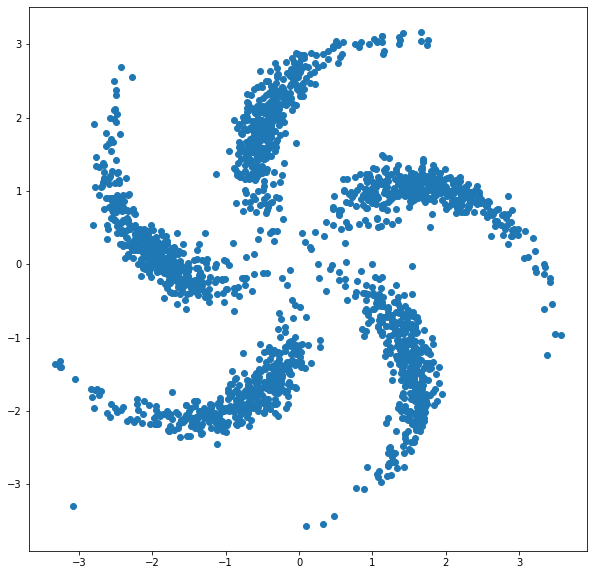

In [5]:
fig = plt.figure(figsize=(10, 10))
sample_tmp = toy_data.inf_train_gen('pinwheel', n_points=2048)
plt.scatter(sample_tmp[:, 0], sample_tmp[:, 1])

# Training

In [6]:
score_net = SmallMLP(in_dim=2)
critic_net = SmallMLP(in_dim=2)

critic_net.to(device)
score_net.to(device)

opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

k_iters = 5
e_iters = 1
epochs = 25000
itr = 0

losses = []
sigmas = sigmas[1:]
for epoch in range(epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
    tr_pts = sample_data('pinwheel', 2048).view(-1, 2)
    tr_pts.requires_grad_()
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * sigmas[..., None]
    
    score_pred = score_net(perturbed_points, sigmas)
    critic_output = critic_net(perturbed_points, sigmas)

    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    
    losses.append(loss)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    
    cycle_iter = itr % (k_iters + e_iters)
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        log_message = "Epoch %d (critic), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)
    else:
        loss.backward()
        opt_scorenet.step()
        log_message = "Epoch %d (score), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)

    print(log_message)
    itr += 1

Epoch 0 (critic), Loss=-0.00875 t1=-0.00336 t2=-0.00539
Epoch 1 (critic), Loss=1.04120 t1=-0.02528 t2=1.06648
Epoch 2 (critic), Loss=0.71481 t1=-0.00993 t2=0.72474
Epoch 3 (critic), Loss=0.35189 t1=-0.00203 t2=0.35392
Epoch 4 (critic), Loss=0.15262 t1=0.00015 t2=0.15247
Epoch 5 (score), Loss=0.11008 t1=-0.00236 t2=0.11245
Epoch 6 (critic), Loss=-0.06622 t1=-0.17837 t2=0.11216
Epoch 7 (critic), Loss=0.03281 t1=0.00072 t2=0.03209
Epoch 8 (critic), Loss=0.17694 t1=0.22998 t2=-0.05304
Epoch 9 (critic), Loss=0.30727 t1=0.43087 t2=-0.12361
Epoch 10 (critic), Loss=0.40932 t1=0.57022 t2=-0.16090
Epoch 11 (score), Loss=0.44631 t1=0.59595 t2=-0.14964
Epoch 12 (critic), Loss=0.00238 t1=0.15077 t2=-0.14840
Epoch 13 (critic), Loss=0.01260 t1=0.11148 t2=-0.09887
Epoch 14 (critic), Loss=0.01698 t1=0.05748 t2=-0.04050
Epoch 15 (critic), Loss=0.02158 t1=0.01140 t2=0.01018
Epoch 16 (critic), Loss=0.03388 t1=-0.01603 t2=0.04990
Epoch 17 (score), Loss=0.04407 t1=-0.03161 t2=0.07568
Epoch 18 (critic), Loss

Epoch 154 (critic), Loss=5.35907 t1=-0.07635 t2=5.43542
Epoch 155 (score), Loss=5.30769 t1=-0.18505 t2=5.49274
Epoch 156 (critic), Loss=5.27685 t1=-0.26443 t2=5.54128
Epoch 157 (critic), Loss=5.22031 t1=-0.14439 t2=5.36470
Epoch 158 (critic), Loss=5.25871 t1=-0.02100 t2=5.27971
Epoch 159 (critic), Loss=5.32598 t1=-0.07354 t2=5.39952
Epoch 160 (critic), Loss=5.47743 t1=-0.21529 t2=5.69272
Epoch 161 (score), Loss=5.41304 t1=-0.22474 t2=5.63778
Epoch 162 (critic), Loss=5.20072 t1=-0.36955 t2=5.57026
Epoch 163 (critic), Loss=5.41225 t1=-0.02344 t2=5.43569
Epoch 164 (critic), Loss=5.47335 t1=0.18489 t2=5.28847
Epoch 165 (critic), Loss=5.50615 t1=0.00127 t2=5.50488
Epoch 166 (critic), Loss=5.41877 t1=-0.25418 t2=5.67295
Epoch 167 (score), Loss=5.58007 t1=-0.25041 t2=5.83048
Epoch 168 (critic), Loss=5.53692 t1=-0.37251 t2=5.90943
Epoch 169 (critic), Loss=5.62771 t1=0.03571 t2=5.59200
Epoch 170 (critic), Loss=5.64346 t1=0.30044 t2=5.34302
Epoch 171 (critic), Loss=5.73328 t1=0.30870 t2=5.42458


Epoch 309 (critic), Loss=10.08834 t1=1.17365 t2=8.91469
Epoch 310 (critic), Loss=10.17327 t1=1.06105 t2=9.11222
Epoch 311 (score), Loss=9.91319 t1=0.48471 t2=9.42848
Epoch 312 (critic), Loss=9.93984 t1=0.40217 t2=9.53766
Epoch 313 (critic), Loss=9.68775 t1=0.08299 t2=9.60476
Epoch 314 (critic), Loss=9.39666 t1=0.06091 t2=9.33575
Epoch 315 (critic), Loss=9.60500 t1=0.21668 t2=9.38832
Epoch 316 (critic), Loss=10.01292 t1=0.42699 t2=9.58593
Epoch 317 (score), Loss=10.15049 t1=0.66692 t2=9.48357
Epoch 318 (critic), Loss=9.79587 t1=0.34612 t2=9.44975
Epoch 319 (critic), Loss=9.59480 t1=0.39370 t2=9.20110
Epoch 320 (critic), Loss=9.22569 t1=-0.14433 t2=9.37002
Epoch 321 (critic), Loss=9.25743 t1=-0.24663 t2=9.50406
Epoch 322 (critic), Loss=9.65224 t1=0.09929 t2=9.55296
Epoch 323 (score), Loss=9.77301 t1=0.54859 t2=9.22442
Epoch 324 (critic), Loss=9.46874 t1=0.19631 t2=9.27243
Epoch 325 (critic), Loss=9.46560 t1=0.37074 t2=9.09485
Epoch 326 (critic), Loss=9.88353 t1=-0.13043 t2=10.01396
Epoch

Epoch 462 (critic), Loss=10.73613 t1=0.09173 t2=10.64440
Epoch 463 (critic), Loss=11.03080 t1=0.50701 t2=10.52379
Epoch 464 (critic), Loss=11.25367 t1=1.06100 t2=10.19267
Epoch 465 (critic), Loss=11.07129 t1=0.62305 t2=10.44825
Epoch 466 (critic), Loss=10.87325 t1=0.09790 t2=10.77535
Epoch 467 (score), Loss=10.90574 t1=0.22121 t2=10.68453
Epoch 468 (critic), Loss=10.93248 t1=0.20297 t2=10.72951
Epoch 469 (critic), Loss=11.32904 t1=1.13644 t2=10.19261
Epoch 470 (critic), Loss=11.34121 t1=1.21346 t2=10.12775
Epoch 471 (critic), Loss=11.26808 t1=0.69920 t2=10.56888
Epoch 472 (critic), Loss=10.86283 t1=0.08922 t2=10.77361
Epoch 473 (score), Loss=11.13669 t1=0.68034 t2=10.45635
Epoch 474 (critic), Loss=10.85759 t1=0.59976 t2=10.25782
Epoch 475 (critic), Loss=10.99456 t1=0.92889 t2=10.06567
Epoch 476 (critic), Loss=11.08105 t1=0.71273 t2=10.36832
Epoch 477 (critic), Loss=10.88740 t1=0.37500 t2=10.51240
Epoch 478 (critic), Loss=10.83963 t1=0.53237 t2=10.30726
Epoch 479 (score), Loss=10.99685 

Epoch 609 (critic), Loss=11.90122 t1=0.89856 t2=11.00266
Epoch 610 (critic), Loss=11.49750 t1=0.64067 t2=10.85683
Epoch 611 (score), Loss=11.59023 t1=0.22483 t2=11.36539
Epoch 612 (critic), Loss=11.09202 t1=-0.05068 t2=11.14269
Epoch 613 (critic), Loss=11.58157 t1=0.09144 t2=11.49013
Epoch 614 (critic), Loss=12.12308 t1=0.79221 t2=11.33088
Epoch 615 (critic), Loss=11.79066 t1=0.88050 t2=10.91015
Epoch 616 (critic), Loss=11.71085 t1=0.85986 t2=10.85099
Epoch 617 (score), Loss=11.47672 t1=0.29067 t2=11.18605
Epoch 618 (critic), Loss=11.38849 t1=0.21337 t2=11.17512
Epoch 619 (critic), Loss=11.64670 t1=0.25366 t2=11.39304
Epoch 620 (critic), Loss=12.04539 t1=0.94676 t2=11.09863
Epoch 621 (critic), Loss=12.21694 t1=1.16787 t2=11.04906
Epoch 622 (critic), Loss=12.01685 t1=0.93423 t2=11.08262
Epoch 623 (score), Loss=11.70912 t1=-0.02150 t2=11.73062
Epoch 624 (critic), Loss=11.68236 t1=-0.02024 t2=11.70260
Epoch 625 (critic), Loss=12.08413 t1=0.28649 t2=11.79763
Epoch 626 (critic), Loss=12.516

Epoch 758 (critic), Loss=11.03539 t1=-0.29202 t2=11.32741
Epoch 759 (critic), Loss=11.40100 t1=0.08900 t2=11.31201
Epoch 760 (critic), Loss=11.54148 t1=0.07155 t2=11.46993
Epoch 761 (score), Loss=11.64231 t1=0.12630 t2=11.51600
Epoch 762 (critic), Loss=11.40955 t1=0.01298 t2=11.39656
Epoch 763 (critic), Loss=11.23813 t1=-0.30697 t2=11.54510
Epoch 764 (critic), Loss=11.46946 t1=-0.14260 t2=11.61206
Epoch 765 (critic), Loss=11.31574 t1=0.18937 t2=11.12637
Epoch 766 (critic), Loss=11.44141 t1=0.34985 t2=11.09155
Epoch 767 (score), Loss=11.68170 t1=0.22200 t2=11.45970
Epoch 768 (critic), Loss=11.46615 t1=0.08234 t2=11.38381
Epoch 769 (critic), Loss=11.51683 t1=-0.25694 t2=11.77376
Epoch 770 (critic), Loss=11.34013 t1=-0.39797 t2=11.73810
Epoch 771 (critic), Loss=11.13867 t1=-0.16471 t2=11.30338
Epoch 772 (critic), Loss=11.32257 t1=0.08635 t2=11.23621
Epoch 773 (score), Loss=11.50963 t1=0.10816 t2=11.40148
Epoch 774 (critic), Loss=11.44613 t1=0.04976 t2=11.39637
Epoch 775 (critic), Loss=11.

Epoch 908 (critic), Loss=11.24369 t1=0.15035 t2=11.09334
Epoch 909 (critic), Loss=11.42472 t1=0.21994 t2=11.20478
Epoch 910 (critic), Loss=11.53702 t1=0.07428 t2=11.46274
Epoch 911 (score), Loss=11.67718 t1=-0.00891 t2=11.68609
Epoch 912 (critic), Loss=11.22172 t1=-0.25678 t2=11.47851
Epoch 913 (critic), Loss=11.15591 t1=-0.11921 t2=11.27513
Epoch 914 (critic), Loss=11.27503 t1=0.27096 t2=11.00407
Epoch 915 (critic), Loss=11.23868 t1=0.23931 t2=10.99937
Epoch 916 (critic), Loss=11.24279 t1=-0.20217 t2=11.44495
Epoch 917 (score), Loss=11.15104 t1=0.16493 t2=10.98611
Epoch 918 (critic), Loss=10.96400 t1=0.02947 t2=10.93453
Epoch 919 (critic), Loss=11.37149 t1=0.66891 t2=10.70258
Epoch 920 (critic), Loss=11.32903 t1=0.42546 t2=10.90357
Epoch 921 (critic), Loss=10.94823 t1=-0.09569 t2=11.04392
Epoch 922 (critic), Loss=11.03555 t1=-0.17609 t2=11.21165
Epoch 923 (score), Loss=11.00141 t1=0.11569 t2=10.88572
Epoch 924 (critic), Loss=10.88530 t1=-0.08255 t2=10.96785
Epoch 925 (critic), Loss=11

Epoch 1053 (critic), Loss=12.30513 t1=1.45479 t2=10.85033
Epoch 1054 (critic), Loss=11.60949 t1=0.70779 t2=10.90170
Epoch 1055 (score), Loss=10.89644 t1=-0.20673 t2=11.10317
Epoch 1056 (critic), Loss=11.18940 t1=-0.14493 t2=11.33433
Epoch 1057 (critic), Loss=11.51369 t1=0.23974 t2=11.27395
Epoch 1058 (critic), Loss=12.05804 t1=1.38464 t2=10.67339
Epoch 1059 (critic), Loss=12.81049 t1=1.96725 t2=10.84324
Epoch 1060 (critic), Loss=11.98302 t1=1.12155 t2=10.86147
Epoch 1061 (score), Loss=11.27265 t1=0.14919 t2=11.12346
Epoch 1062 (critic), Loss=11.17453 t1=0.13927 t2=11.03526
Epoch 1063 (critic), Loss=11.57408 t1=0.26461 t2=11.30946
Epoch 1064 (critic), Loss=12.66207 t1=1.61795 t2=11.04412
Epoch 1065 (critic), Loss=13.01654 t1=2.23974 t2=10.77680
Epoch 1066 (critic), Loss=12.37982 t1=1.58870 t2=10.79111
Epoch 1067 (score), Loss=11.53674 t1=0.47640 t2=11.06034
Epoch 1068 (critic), Loss=11.40112 t1=0.44572 t2=10.95540
Epoch 1069 (critic), Loss=11.26779 t1=0.20791 t2=11.05988
Epoch 1070 (cri

Epoch 1199 (score), Loss=11.74319 t1=0.62097 t2=11.12221
Epoch 1200 (critic), Loss=11.93770 t1=0.68779 t2=11.24990
Epoch 1201 (critic), Loss=11.91607 t1=0.61047 t2=11.30560
Epoch 1202 (critic), Loss=11.40460 t1=0.16801 t2=11.23660
Epoch 1203 (critic), Loss=11.96083 t1=0.64606 t2=11.31477
Epoch 1204 (critic), Loss=11.89334 t1=0.49502 t2=11.39832
Epoch 1205 (score), Loss=11.80505 t1=0.60459 t2=11.20045
Epoch 1206 (critic), Loss=11.69909 t1=0.37525 t2=11.32384
Epoch 1207 (critic), Loss=11.50931 t1=0.39718 t2=11.11213
Epoch 1208 (critic), Loss=11.63016 t1=0.47430 t2=11.15586
Epoch 1209 (critic), Loss=11.36021 t1=0.14688 t2=11.21333
Epoch 1210 (critic), Loss=11.43110 t1=0.07133 t2=11.35976
Epoch 1211 (score), Loss=11.51797 t1=0.17982 t2=11.33815
Epoch 1212 (critic), Loss=11.25045 t1=0.11388 t2=11.13657
Epoch 1213 (critic), Loss=11.16049 t1=-0.01783 t2=11.17832
Epoch 1214 (critic), Loss=10.92851 t1=-0.35101 t2=11.27952
Epoch 1215 (critic), Loss=10.86027 t1=-0.42715 t2=11.28743
Epoch 1216 (cr

Epoch 1347 (critic), Loss=11.04068 t1=-0.40699 t2=11.44767
Epoch 1348 (critic), Loss=10.88041 t1=-0.44089 t2=11.32131
Epoch 1349 (score), Loss=10.22206 t1=-0.44179 t2=10.66386
Epoch 1350 (critic), Loss=10.39081 t1=-0.43041 t2=10.82122
Epoch 1351 (critic), Loss=10.34913 t1=-0.39372 t2=10.74285
Epoch 1352 (critic), Loss=10.98607 t1=-0.19092 t2=11.17700
Epoch 1353 (critic), Loss=10.97617 t1=-0.32348 t2=11.29965
Epoch 1354 (critic), Loss=10.94203 t1=-0.26220 t2=11.20424
Epoch 1355 (score), Loss=10.37812 t1=-0.36174 t2=10.73987
Epoch 1356 (critic), Loss=10.65751 t1=-0.36637 t2=11.02388
Epoch 1357 (critic), Loss=10.29658 t1=-0.39075 t2=10.68733
Epoch 1358 (critic), Loss=10.58832 t1=-0.02344 t2=10.61176
Epoch 1359 (critic), Loss=11.04559 t1=0.25315 t2=10.79243
Epoch 1360 (critic), Loss=10.84982 t1=0.13233 t2=10.71749
Epoch 1361 (score), Loss=10.36961 t1=-0.02522 t2=10.39483
Epoch 1362 (critic), Loss=10.92426 t1=0.09769 t2=10.82657
Epoch 1363 (critic), Loss=10.10060 t1=-0.34629 t2=10.44689
Epo

Epoch 1490 (critic), Loss=9.63597 t1=-0.71519 t2=10.35116
Epoch 1491 (critic), Loss=10.21440 t1=0.05993 t2=10.15448
Epoch 1492 (critic), Loss=10.02493 t1=0.04475 t2=9.98018
Epoch 1493 (score), Loss=9.93698 t1=-0.12481 t2=10.06180
Epoch 1494 (critic), Loss=9.90345 t1=-0.37636 t2=10.27981
Epoch 1495 (critic), Loss=9.85330 t1=-0.38016 t2=10.23346
Epoch 1496 (critic), Loss=9.76334 t1=-0.64501 t2=10.40835
Epoch 1497 (critic), Loss=10.03348 t1=-0.28558 t2=10.31905
Epoch 1498 (critic), Loss=10.18685 t1=0.22610 t2=9.96075
Epoch 1499 (score), Loss=10.05666 t1=0.05417 t2=10.00249
Epoch 1500 (critic), Loss=10.37369 t1=0.16986 t2=10.20384
Epoch 1501 (critic), Loss=9.82718 t1=-0.56673 t2=10.39391
Epoch 1502 (critic), Loss=9.75498 t1=-0.74021 t2=10.49519
Epoch 1503 (critic), Loss=9.89611 t1=-0.70453 t2=10.60065
Epoch 1504 (critic), Loss=10.11552 t1=-0.28247 t2=10.39799
Epoch 1505 (score), Loss=10.20718 t1=0.02597 t2=10.18121
Epoch 1506 (critic), Loss=10.15066 t1=-0.14361 t2=10.29427
Epoch 1507 (crit

Epoch 1634 (critic), Loss=8.93694 t1=-0.57241 t2=9.50935
Epoch 1635 (critic), Loss=9.31190 t1=-0.31954 t2=9.63144
Epoch 1636 (critic), Loss=9.14361 t1=-0.44451 t2=9.58812
Epoch 1637 (score), Loss=9.06859 t1=-0.57533 t2=9.64391
Epoch 1638 (critic), Loss=9.09599 t1=-0.62230 t2=9.71829
Epoch 1639 (critic), Loss=9.23829 t1=-0.26717 t2=9.50546
Epoch 1640 (critic), Loss=9.52128 t1=0.18953 t2=9.33175
Epoch 1641 (critic), Loss=9.65179 t1=0.46184 t2=9.18995
Epoch 1642 (critic), Loss=9.28576 t1=0.08582 t2=9.19994
Epoch 1643 (score), Loss=9.36610 t1=-0.25737 t2=9.62347
Epoch 1644 (critic), Loss=9.08623 t1=-0.33706 t2=9.42328
Epoch 1645 (critic), Loss=8.76562 t1=-0.44612 t2=9.21174
Epoch 1646 (critic), Loss=9.00091 t1=-0.22297 t2=9.22388
Epoch 1647 (critic), Loss=9.31679 t1=0.41464 t2=8.90215
Epoch 1648 (critic), Loss=9.20631 t1=0.28097 t2=8.92534
Epoch 1649 (score), Loss=9.30501 t1=0.28348 t2=9.02152
Epoch 1650 (critic), Loss=9.00919 t1=-0.03473 t2=9.04392
Epoch 1651 (critic), Loss=9.27886 t1=-0.

Epoch 1787 (score), Loss=7.85813 t1=-1.42790 t2=9.28603
Epoch 1788 (critic), Loss=7.64238 t1=-1.49314 t2=9.13553
Epoch 1789 (critic), Loss=7.58181 t1=-1.43935 t2=9.02116
Epoch 1790 (critic), Loss=7.32416 t1=-1.22683 t2=8.55099
Epoch 1791 (critic), Loss=7.56072 t1=-0.87379 t2=8.43451
Epoch 1792 (critic), Loss=7.84633 t1=-0.90296 t2=8.74929
Epoch 1793 (score), Loss=7.40845 t1=-1.24276 t2=8.65122
Epoch 1794 (critic), Loss=7.33439 t1=-1.43473 t2=8.76912
Epoch 1795 (critic), Loss=7.12921 t1=-1.76201 t2=8.89122
Epoch 1796 (critic), Loss=7.20761 t1=-1.59614 t2=8.80375
Epoch 1797 (critic), Loss=7.29552 t1=-1.20932 t2=8.50484
Epoch 1798 (critic), Loss=7.54030 t1=-0.78598 t2=8.32629
Epoch 1799 (score), Loss=7.78768 t1=-0.56975 t2=8.35743
Epoch 1800 (critic), Loss=7.47853 t1=-0.89648 t2=8.37500
Epoch 1801 (critic), Loss=7.50217 t1=-1.02209 t2=8.52426
Epoch 1802 (critic), Loss=7.56313 t1=-1.13951 t2=8.70265
Epoch 1803 (critic), Loss=7.57443 t1=-1.22362 t2=8.79805
Epoch 1804 (critic), Loss=7.59499 

Epoch 1940 (critic), Loss=6.45908 t1=-1.55520 t2=8.01428
Epoch 1941 (critic), Loss=6.79865 t1=-1.54054 t2=8.33920
Epoch 1942 (critic), Loss=6.77055 t1=-1.23892 t2=8.00947
Epoch 1943 (score), Loss=6.77462 t1=-1.07807 t2=7.85269
Epoch 1944 (critic), Loss=6.73115 t1=-1.24297 t2=7.97412
Epoch 1945 (critic), Loss=6.22584 t1=-1.16753 t2=7.39337
Epoch 1946 (critic), Loss=6.48446 t1=-1.20663 t2=7.69110
Epoch 1947 (critic), Loss=6.56375 t1=-1.41638 t2=7.98013
Epoch 1948 (critic), Loss=6.53043 t1=-1.71446 t2=8.24489
Epoch 1949 (score), Loss=6.43287 t1=-1.28502 t2=7.71789
Epoch 1950 (critic), Loss=6.26396 t1=-1.56069 t2=7.82465
Epoch 1951 (critic), Loss=6.10343 t1=-1.54789 t2=7.65132
Epoch 1952 (critic), Loss=6.32069 t1=-1.25506 t2=7.57575
Epoch 1953 (critic), Loss=6.50187 t1=-1.17992 t2=7.68179
Epoch 1954 (critic), Loss=6.62207 t1=-1.34771 t2=7.96978
Epoch 1955 (score), Loss=6.63262 t1=-1.43549 t2=8.06811
Epoch 1956 (critic), Loss=6.13635 t1=-1.81292 t2=7.94927
Epoch 1957 (critic), Loss=6.18584 

Epoch 2093 (score), Loss=5.55304 t1=-1.52877 t2=7.08181
Epoch 2094 (critic), Loss=5.16834 t1=-1.87752 t2=7.04586
Epoch 2095 (critic), Loss=5.27788 t1=-1.80353 t2=7.08141
Epoch 2096 (critic), Loss=5.45187 t1=-1.13228 t2=6.58416
Epoch 2097 (critic), Loss=5.57511 t1=-0.72725 t2=6.30235
Epoch 2098 (critic), Loss=5.33115 t1=-1.06345 t2=6.39461
Epoch 2099 (score), Loss=5.49609 t1=-1.35224 t2=6.84833
Epoch 2100 (critic), Loss=5.07315 t1=-1.72875 t2=6.80191
Epoch 2101 (critic), Loss=5.47517 t1=-1.57047 t2=7.04564
Epoch 2102 (critic), Loss=5.53859 t1=-1.46664 t2=7.00523
Epoch 2103 (critic), Loss=5.61684 t1=-1.15224 t2=6.76908
Epoch 2104 (critic), Loss=5.83632 t1=-0.50765 t2=6.34397
Epoch 2105 (score), Loss=6.28664 t1=-0.06827 t2=6.35491
Epoch 2106 (critic), Loss=5.54806 t1=-0.58075 t2=6.12880
Epoch 2107 (critic), Loss=5.24605 t1=-1.12182 t2=6.36787
Epoch 2108 (critic), Loss=5.54042 t1=-1.23743 t2=6.77786
Epoch 2109 (critic), Loss=5.04077 t1=-1.74902 t2=6.78979
Epoch 2110 (critic), Loss=5.34041 

Epoch 2240 (critic), Loss=4.39208 t1=-1.48409 t2=5.87617
Epoch 2241 (critic), Loss=4.79376 t1=-1.19942 t2=5.99319
Epoch 2242 (critic), Loss=4.56848 t1=-1.36019 t2=5.92867
Epoch 2243 (score), Loss=4.62737 t1=-1.39295 t2=6.02032
Epoch 2244 (critic), Loss=4.29013 t1=-1.53258 t2=5.82271
Epoch 2245 (critic), Loss=4.25541 t1=-1.78900 t2=6.04441
Epoch 2246 (critic), Loss=4.12548 t1=-1.61357 t2=5.73906
Epoch 2247 (critic), Loss=4.58653 t1=-1.24544 t2=5.83197
Epoch 2248 (critic), Loss=4.50192 t1=-1.16142 t2=5.66334
Epoch 2249 (score), Loss=4.68180 t1=-1.32229 t2=6.00409
Epoch 2250 (critic), Loss=4.50889 t1=-1.35833 t2=5.86722
Epoch 2251 (critic), Loss=4.14202 t1=-1.28576 t2=5.42778
Epoch 2252 (critic), Loss=4.20281 t1=-1.48567 t2=5.68848
Epoch 2253 (critic), Loss=4.54952 t1=-1.32005 t2=5.86958
Epoch 2254 (critic), Loss=4.28270 t1=-1.37238 t2=5.65508
Epoch 2255 (score), Loss=4.43708 t1=-1.30705 t2=5.74413
Epoch 2256 (critic), Loss=4.27540 t1=-1.36844 t2=5.64384
Epoch 2257 (critic), Loss=4.28866 

Epoch 2385 (critic), Loss=3.62928 t1=-1.21152 t2=4.84080
Epoch 2386 (critic), Loss=3.79061 t1=-1.37576 t2=5.16637
Epoch 2387 (score), Loss=3.77392 t1=-1.38607 t2=5.15999
Epoch 2388 (critic), Loss=3.68597 t1=-1.73889 t2=5.42486
Epoch 2389 (critic), Loss=3.40524 t1=-1.73530 t2=5.14054
Epoch 2390 (critic), Loss=3.51353 t1=-1.37662 t2=4.89015
Epoch 2391 (critic), Loss=3.73074 t1=-1.13435 t2=4.86509
Epoch 2392 (critic), Loss=3.64810 t1=-0.94296 t2=4.59106
Epoch 2393 (score), Loss=3.46250 t1=-0.96507 t2=4.42758
Epoch 2394 (critic), Loss=3.64288 t1=-1.00098 t2=4.64386
Epoch 2395 (critic), Loss=3.40227 t1=-1.31825 t2=4.72053
Epoch 2396 (critic), Loss=3.28511 t1=-1.38071 t2=4.66582
Epoch 2397 (critic), Loss=3.86392 t1=-1.13786 t2=5.00178
Epoch 2398 (critic), Loss=3.27085 t1=-1.60546 t2=4.87631
Epoch 2399 (score), Loss=3.22455 t1=-1.36755 t2=4.59210
Epoch 2400 (critic), Loss=3.42785 t1=-1.44611 t2=4.87396
Epoch 2401 (critic), Loss=3.49157 t1=-1.21424 t2=4.70581
Epoch 2402 (critic), Loss=3.57475 

Epoch 2530 (critic), Loss=3.12954 t1=-1.17666 t2=4.30620
Epoch 2531 (score), Loss=2.94622 t1=-1.03843 t2=3.98465
Epoch 2532 (critic), Loss=2.80991 t1=-1.45104 t2=4.26096
Epoch 2533 (critic), Loss=2.70670 t1=-1.41997 t2=4.12667
Epoch 2534 (critic), Loss=3.17571 t1=-1.29501 t2=4.47072
Epoch 2535 (critic), Loss=3.44137 t1=-1.40639 t2=4.84776
Epoch 2536 (critic), Loss=3.49038 t1=-1.37530 t2=4.86568
Epoch 2537 (score), Loss=3.51681 t1=-1.25768 t2=4.77449
Epoch 2538 (critic), Loss=2.81382 t1=-1.96898 t2=4.78280
Epoch 2539 (critic), Loss=2.92439 t1=-1.44200 t2=4.36639
Epoch 2540 (critic), Loss=3.03765 t1=-1.40223 t2=4.43988
Epoch 2541 (critic), Loss=2.95377 t1=-1.30752 t2=4.26129
Epoch 2542 (critic), Loss=2.73138 t1=-1.47507 t2=4.20645
Epoch 2543 (score), Loss=2.63703 t1=-1.63927 t2=4.27630
Epoch 2544 (critic), Loss=3.10691 t1=-1.25130 t2=4.35821
Epoch 2545 (critic), Loss=2.53170 t1=-1.72034 t2=4.25204
Epoch 2546 (critic), Loss=2.73218 t1=-1.58426 t2=4.31644
Epoch 2547 (critic), Loss=3.08615 

Epoch 2682 (critic), Loss=2.31332 t1=-0.93022 t2=3.24354
Epoch 2683 (critic), Loss=2.46303 t1=-0.99732 t2=3.46036
Epoch 2684 (critic), Loss=2.44387 t1=-1.12914 t2=3.57300
Epoch 2685 (critic), Loss=2.45530 t1=-1.09506 t2=3.55036
Epoch 2686 (critic), Loss=2.37380 t1=-1.21021 t2=3.58401
Epoch 2687 (score), Loss=2.81756 t1=-0.69367 t2=3.51122
Epoch 2688 (critic), Loss=2.24425 t1=-1.07422 t2=3.31847
Epoch 2689 (critic), Loss=2.22040 t1=-1.35741 t2=3.57781
Epoch 2690 (critic), Loss=2.06594 t1=-1.30979 t2=3.37573
Epoch 2691 (critic), Loss=2.53195 t1=-1.09248 t2=3.62443
Epoch 2692 (critic), Loss=2.03191 t1=-1.43119 t2=3.46310
Epoch 2693 (score), Loss=2.54731 t1=-0.92890 t2=3.47621
Epoch 2694 (critic), Loss=2.44478 t1=-1.22511 t2=3.66988
Epoch 2695 (critic), Loss=2.39629 t1=-1.19235 t2=3.58863
Epoch 2696 (critic), Loss=2.89567 t1=-0.71272 t2=3.60839
Epoch 2697 (critic), Loss=2.40039 t1=-1.19397 t2=3.59436
Epoch 2698 (critic), Loss=2.59841 t1=-1.05910 t2=3.65750
Epoch 2699 (score), Loss=2.66949 

Epoch 2834 (critic), Loss=2.14724 t1=-1.15427 t2=3.30151
Epoch 2835 (critic), Loss=2.21348 t1=-1.02856 t2=3.24205
Epoch 2836 (critic), Loss=2.41581 t1=-0.63002 t2=3.04583
Epoch 2837 (score), Loss=2.07210 t1=-1.02171 t2=3.09381
Epoch 2838 (critic), Loss=2.07451 t1=-1.15577 t2=3.23028
Epoch 2839 (critic), Loss=2.11579 t1=-0.87222 t2=2.98801
Epoch 2840 (critic), Loss=2.16011 t1=-0.91215 t2=3.07226
Epoch 2841 (critic), Loss=2.11375 t1=-0.82027 t2=2.93402
Epoch 2842 (critic), Loss=2.10702 t1=-0.86414 t2=2.97116
Epoch 2843 (score), Loss=2.07807 t1=-0.97405 t2=3.05212
Epoch 2844 (critic), Loss=2.13245 t1=-1.00296 t2=3.13540
Epoch 2845 (critic), Loss=2.48850 t1=-0.70195 t2=3.19044
Epoch 2846 (critic), Loss=1.95971 t1=-0.95344 t2=2.91315
Epoch 2847 (critic), Loss=2.21801 t1=-0.97905 t2=3.19706
Epoch 2848 (critic), Loss=2.24239 t1=-0.72606 t2=2.96846
Epoch 2849 (score), Loss=2.42240 t1=-0.52803 t2=2.95043
Epoch 2850 (critic), Loss=2.02916 t1=-0.96721 t2=2.99637
Epoch 2851 (critic), Loss=2.29495 

Epoch 2986 (critic), Loss=2.25796 t1=-0.84578 t2=3.10374
Epoch 2987 (score), Loss=2.28353 t1=-0.86146 t2=3.14499
Epoch 2988 (critic), Loss=2.11998 t1=-1.14693 t2=3.26691
Epoch 2989 (critic), Loss=1.92160 t1=-1.19532 t2=3.11692
Epoch 2990 (critic), Loss=1.96943 t1=-0.98402 t2=2.95345
Epoch 2991 (critic), Loss=2.07092 t1=-1.07892 t2=3.14983
Epoch 2992 (critic), Loss=2.15213 t1=-0.72172 t2=2.87385
Epoch 2993 (score), Loss=1.87903 t1=-1.00617 t2=2.88520
Epoch 2994 (critic), Loss=1.91319 t1=-0.99776 t2=2.91095
Epoch 2995 (critic), Loss=2.00914 t1=-0.93125 t2=2.94039
Epoch 2996 (critic), Loss=2.43657 t1=-0.77197 t2=3.20853
Epoch 2997 (critic), Loss=2.27285 t1=-0.81017 t2=3.08302
Epoch 2998 (critic), Loss=2.27802 t1=-0.77043 t2=3.04845
Epoch 2999 (score), Loss=2.16177 t1=-1.10698 t2=3.26875
Epoch 3000 (critic), Loss=1.69904 t1=-1.36551 t2=3.06455
Epoch 3001 (critic), Loss=1.94111 t1=-1.18498 t2=3.12610
Epoch 3002 (critic), Loss=2.09613 t1=-0.63885 t2=2.73498
Epoch 3003 (critic), Loss=2.47554 

Epoch 3134 (critic), Loss=1.84568 t1=-0.53961 t2=2.38528
Epoch 3135 (critic), Loss=1.92293 t1=-0.55643 t2=2.47936
Epoch 3136 (critic), Loss=2.19066 t1=-0.26644 t2=2.45710
Epoch 3137 (score), Loss=2.24369 t1=-0.28478 t2=2.52847
Epoch 3138 (critic), Loss=1.42353 t1=-0.88900 t2=2.31253
Epoch 3139 (critic), Loss=1.44122 t1=-0.96629 t2=2.40751
Epoch 3140 (critic), Loss=1.47173 t1=-0.94235 t2=2.41408
Epoch 3141 (critic), Loss=1.74687 t1=-0.75369 t2=2.50057
Epoch 3142 (critic), Loss=1.83008 t1=-0.64744 t2=2.47751
Epoch 3143 (score), Loss=1.90744 t1=-0.51141 t2=2.41885
Epoch 3144 (critic), Loss=1.59618 t1=-0.68141 t2=2.27759
Epoch 3145 (critic), Loss=1.57699 t1=-0.55087 t2=2.12786
Epoch 3146 (critic), Loss=2.20455 t1=-0.01467 t2=2.21922
Epoch 3147 (critic), Loss=1.49356 t1=-0.60080 t2=2.09435
Epoch 3148 (critic), Loss=1.70793 t1=-0.45931 t2=2.16724
Epoch 3149 (score), Loss=1.78699 t1=-0.59478 t2=2.38177
Epoch 3150 (critic), Loss=1.38655 t1=-0.87757 t2=2.26413
Epoch 3151 (critic), Loss=1.89334 

Epoch 3285 (critic), Loss=1.76444 t1=-0.51309 t2=2.27753
Epoch 3286 (critic), Loss=1.79836 t1=-0.45863 t2=2.25699
Epoch 3287 (score), Loss=1.85229 t1=-0.37210 t2=2.22440
Epoch 3288 (critic), Loss=1.84571 t1=-0.43299 t2=2.27870
Epoch 3289 (critic), Loss=2.03568 t1=-0.45209 t2=2.48777
Epoch 3290 (critic), Loss=2.24818 t1=-0.13935 t2=2.38753
Epoch 3291 (critic), Loss=1.53796 t1=-0.66459 t2=2.20254
Epoch 3292 (critic), Loss=2.01396 t1=-0.42745 t2=2.44141
Epoch 3293 (score), Loss=1.84430 t1=-0.46609 t2=2.31039
Epoch 3294 (critic), Loss=1.66240 t1=-0.87787 t2=2.54027
Epoch 3295 (critic), Loss=1.68054 t1=-0.78763 t2=2.46817
Epoch 3296 (critic), Loss=1.81322 t1=-0.64796 t2=2.46118
Epoch 3297 (critic), Loss=1.93828 t1=-0.38180 t2=2.32008
Epoch 3298 (critic), Loss=2.17925 t1=-0.23610 t2=2.41535
Epoch 3299 (score), Loss=1.94648 t1=-0.29881 t2=2.24529
Epoch 3300 (critic), Loss=1.57479 t1=-0.67919 t2=2.25398
Epoch 3301 (critic), Loss=1.46003 t1=-0.61998 t2=2.08000
Epoch 3302 (critic), Loss=1.47982 

Epoch 3438 (critic), Loss=1.23881 t1=-0.97281 t2=2.21162
Epoch 3439 (critic), Loss=1.55369 t1=-0.77483 t2=2.32852
Epoch 3440 (critic), Loss=1.97372 t1=-0.28707 t2=2.26079
Epoch 3441 (critic), Loss=1.92441 t1=-0.27937 t2=2.20378
Epoch 3442 (critic), Loss=1.71260 t1=-0.51622 t2=2.22882
Epoch 3443 (score), Loss=1.48518 t1=-0.56632 t2=2.05151
Epoch 3444 (critic), Loss=1.56115 t1=-0.58979 t2=2.15094
Epoch 3445 (critic), Loss=1.42069 t1=-0.73315 t2=2.15384
Epoch 3446 (critic), Loss=1.46952 t1=-0.86588 t2=2.33540
Epoch 3447 (critic), Loss=1.69858 t1=-0.70515 t2=2.40373
Epoch 3448 (critic), Loss=1.82581 t1=-0.48219 t2=2.30801
Epoch 3449 (score), Loss=2.01532 t1=-0.27292 t2=2.28824
Epoch 3450 (critic), Loss=1.46329 t1=-0.83530 t2=2.29859
Epoch 3451 (critic), Loss=1.72624 t1=-0.58802 t2=2.31427
Epoch 3452 (critic), Loss=1.76590 t1=-0.39370 t2=2.15960
Epoch 3453 (critic), Loss=1.91326 t1=-0.26125 t2=2.17451
Epoch 3454 (critic), Loss=1.56339 t1=-0.36677 t2=1.93016
Epoch 3455 (score), Loss=1.78458 

Epoch 3591 (critic), Loss=2.17866 t1=-0.06441 t2=2.24306
Epoch 3592 (critic), Loss=2.36814 t1=0.07779 t2=2.29035
Epoch 3593 (score), Loss=2.49683 t1=0.27129 t2=2.22554
Epoch 3594 (critic), Loss=1.55569 t1=-0.73154 t2=2.28723
Epoch 3595 (critic), Loss=1.86081 t1=-0.34468 t2=2.20548
Epoch 3596 (critic), Loss=1.90392 t1=-0.25223 t2=2.15615
Epoch 3597 (critic), Loss=1.66653 t1=-0.30461 t2=1.97114
Epoch 3598 (critic), Loss=1.57864 t1=-0.47317 t2=2.05181
Epoch 3599 (score), Loss=1.46425 t1=-0.58649 t2=2.05074
Epoch 3600 (critic), Loss=1.21720 t1=-0.56335 t2=1.78055
Epoch 3601 (critic), Loss=1.68346 t1=-0.54239 t2=2.22585
Epoch 3602 (critic), Loss=1.72838 t1=-0.31645 t2=2.04483
Epoch 3603 (critic), Loss=1.72754 t1=-0.30520 t2=2.03273
Epoch 3604 (critic), Loss=1.57415 t1=-0.33707 t2=1.91121
Epoch 3605 (score), Loss=1.66257 t1=-0.28190 t2=1.94446
Epoch 3606 (critic), Loss=1.67821 t1=-0.36045 t2=2.03866
Epoch 3607 (critic), Loss=1.79942 t1=-0.29410 t2=2.09351
Epoch 3608 (critic), Loss=1.67912 t1

Epoch 3744 (critic), Loss=1.45964 t1=-0.53971 t2=1.99936
Epoch 3745 (critic), Loss=1.61550 t1=-0.37005 t2=1.98556
Epoch 3746 (critic), Loss=1.51813 t1=-0.46173 t2=1.97986
Epoch 3747 (critic), Loss=1.66115 t1=-0.47058 t2=2.13173
Epoch 3748 (critic), Loss=1.62719 t1=-0.30163 t2=1.92882
Epoch 3749 (score), Loss=1.54745 t1=-0.39450 t2=1.94195
Epoch 3750 (critic), Loss=1.29042 t1=-0.63192 t2=1.92234
Epoch 3751 (critic), Loss=1.32101 t1=-0.50041 t2=1.82143
Epoch 3752 (critic), Loss=1.60481 t1=-0.17924 t2=1.78405
Epoch 3753 (critic), Loss=1.28633 t1=-0.63155 t2=1.91788
Epoch 3754 (critic), Loss=1.20081 t1=-0.47615 t2=1.67696
Epoch 3755 (score), Loss=1.35811 t1=-0.42952 t2=1.78763
Epoch 3756 (critic), Loss=1.47129 t1=-0.36789 t2=1.83918
Epoch 3757 (critic), Loss=1.88975 t1=0.15505 t2=1.73470
Epoch 3758 (critic), Loss=1.63534 t1=-0.16908 t2=1.80442
Epoch 3759 (critic), Loss=1.56582 t1=-0.17804 t2=1.74386
Epoch 3760 (critic), Loss=1.83097 t1=-0.12459 t2=1.95557
Epoch 3761 (score), Loss=1.97586 t

Epoch 3897 (critic), Loss=2.00248 t1=-0.45704 t2=2.45952
Epoch 3898 (critic), Loss=2.13803 t1=-0.43863 t2=2.57666
Epoch 3899 (score), Loss=2.02810 t1=-0.43911 t2=2.46721
Epoch 3900 (critic), Loss=1.28793 t1=-1.06321 t2=2.35113
Epoch 3901 (critic), Loss=1.63080 t1=-0.67163 t2=2.30243
Epoch 3902 (critic), Loss=1.70206 t1=-0.60712 t2=2.30918
Epoch 3903 (critic), Loss=2.00082 t1=-0.16292 t2=2.16374
Epoch 3904 (critic), Loss=1.66181 t1=-0.50269 t2=2.16450
Epoch 3905 (score), Loss=1.85750 t1=-0.25056 t2=2.10806
Epoch 3906 (critic), Loss=2.05842 t1=-0.10513 t2=2.16355
Epoch 3907 (critic), Loss=2.00934 t1=-0.02991 t2=2.03925
Epoch 3908 (critic), Loss=1.95842 t1=0.06913 t2=1.88930
Epoch 3909 (critic), Loss=2.88631 t1=0.77740 t2=2.10892
Epoch 3910 (critic), Loss=2.44356 t1=0.46829 t2=1.97527
Epoch 3911 (score), Loss=2.40287 t1=0.41868 t2=1.98419
Epoch 3912 (critic), Loss=2.69129 t1=0.65557 t2=2.03572
Epoch 3913 (critic), Loss=2.73531 t1=0.79045 t2=1.94487
Epoch 3914 (critic), Loss=2.70460 t1=0.8

Epoch 4050 (critic), Loss=1.86441 t1=-0.37454 t2=2.23895
Epoch 4051 (critic), Loss=1.88600 t1=-0.33004 t2=2.21603
Epoch 4052 (critic), Loss=1.98848 t1=-0.25855 t2=2.24703
Epoch 4053 (critic), Loss=1.94639 t1=-0.30523 t2=2.25162
Epoch 4054 (critic), Loss=1.82254 t1=-0.44605 t2=2.26859
Epoch 4055 (score), Loss=1.97185 t1=-0.19072 t2=2.16257
Epoch 4056 (critic), Loss=1.60778 t1=-0.62499 t2=2.23278
Epoch 4057 (critic), Loss=1.92082 t1=-0.13264 t2=2.05346
Epoch 4058 (critic), Loss=1.80485 t1=-0.30128 t2=2.10613
Epoch 4059 (critic), Loss=1.92343 t1=-0.16993 t2=2.09336
Epoch 4060 (critic), Loss=1.99632 t1=-0.06665 t2=2.06298
Epoch 4061 (score), Loss=2.20361 t1=0.15746 t2=2.04615
Epoch 4062 (critic), Loss=1.93529 t1=-0.11910 t2=2.05439
Epoch 4063 (critic), Loss=2.21161 t1=-0.04436 t2=2.25597
Epoch 4064 (critic), Loss=2.14507 t1=-0.04387 t2=2.18893
Epoch 4065 (critic), Loss=2.41180 t1=0.20370 t2=2.20810
Epoch 4066 (critic), Loss=2.26411 t1=-0.16701 t2=2.43112
Epoch 4067 (score), Loss=2.23693 t1

Epoch 4203 (critic), Loss=3.49221 t1=2.35727 t2=1.13493
Epoch 4204 (critic), Loss=3.55011 t1=2.36159 t2=1.18852
Epoch 4205 (score), Loss=3.53591 t1=2.26316 t2=1.27275
Epoch 4206 (critic), Loss=3.41919 t1=2.12779 t2=1.29140
Epoch 4207 (critic), Loss=2.96879 t1=1.56110 t2=1.40769
Epoch 4208 (critic), Loss=3.40509 t1=1.77500 t2=1.63008
Epoch 4209 (critic), Loss=3.09445 t1=1.49740 t2=1.59705
Epoch 4210 (critic), Loss=3.36990 t1=1.71375 t2=1.65615
Epoch 4211 (score), Loss=3.36122 t1=1.45229 t2=1.90892
Epoch 4212 (critic), Loss=2.76569 t1=0.97144 t2=1.79425
Epoch 4213 (critic), Loss=2.90580 t1=0.98665 t2=1.91915
Epoch 4214 (critic), Loss=2.76059 t1=0.80461 t2=1.95597
Epoch 4215 (critic), Loss=2.66296 t1=0.64831 t2=2.01465
Epoch 4216 (critic), Loss=2.71721 t1=0.52433 t2=2.19288
Epoch 4217 (score), Loss=2.93647 t1=0.82787 t2=2.10860
Epoch 4218 (critic), Loss=2.39666 t1=0.26281 t2=2.13385
Epoch 4219 (critic), Loss=2.57809 t1=0.50453 t2=2.07356
Epoch 4220 (critic), Loss=2.20933 t1=0.10601 t2=2.1

Epoch 4356 (critic), Loss=2.45892 t1=0.21145 t2=2.24748
Epoch 4357 (critic), Loss=3.07709 t1=0.62357 t2=2.45351
Epoch 4358 (critic), Loss=2.90442 t1=0.35277 t2=2.55165
Epoch 4359 (critic), Loss=3.15550 t1=0.69466 t2=2.46085
Epoch 4360 (critic), Loss=3.10401 t1=0.67032 t2=2.43369
Epoch 4361 (score), Loss=3.07499 t1=0.56204 t2=2.51295
Epoch 4362 (critic), Loss=2.82561 t1=0.34322 t2=2.48239
Epoch 4363 (critic), Loss=2.78787 t1=0.51672 t2=2.27115
Epoch 4364 (critic), Loss=2.66635 t1=0.49587 t2=2.17047
Epoch 4365 (critic), Loss=2.85974 t1=0.71539 t2=2.14435
Epoch 4366 (critic), Loss=3.32253 t1=1.05573 t2=2.26680
Epoch 4367 (score), Loss=2.87408 t1=0.69709 t2=2.17699
Epoch 4368 (critic), Loss=2.37869 t1=0.32853 t2=2.05015
Epoch 4369 (critic), Loss=2.37008 t1=0.13142 t2=2.23866
Epoch 4370 (critic), Loss=1.97793 t1=-0.21916 t2=2.19709
Epoch 4371 (critic), Loss=2.57088 t1=0.16206 t2=2.40882
Epoch 4372 (critic), Loss=2.13596 t1=-0.10993 t2=2.24588
Epoch 4373 (score), Loss=2.53463 t1=0.23907 t2=2

Epoch 4509 (critic), Loss=1.68443 t1=-0.23767 t2=1.92210
Epoch 4510 (critic), Loss=1.79999 t1=-0.23253 t2=2.03252
Epoch 4511 (score), Loss=1.62055 t1=-0.21284 t2=1.83339
Epoch 4512 (critic), Loss=1.56636 t1=-0.35945 t2=1.92581
Epoch 4513 (critic), Loss=1.84360 t1=-0.18981 t2=2.03340
Epoch 4514 (critic), Loss=1.53319 t1=-0.43019 t2=1.96338
Epoch 4515 (critic), Loss=1.73831 t1=-0.24875 t2=1.98706
Epoch 4516 (critic), Loss=2.15431 t1=-0.01112 t2=2.16543
Epoch 4517 (score), Loss=1.97248 t1=-0.11582 t2=2.08830
Epoch 4518 (critic), Loss=1.79163 t1=-0.29839 t2=2.09002
Epoch 4519 (critic), Loss=1.83454 t1=-0.19110 t2=2.02563
Epoch 4520 (critic), Loss=2.13998 t1=-0.20559 t2=2.34558
Epoch 4521 (critic), Loss=1.92663 t1=-0.24140 t2=2.16802
Epoch 4522 (critic), Loss=1.96773 t1=-0.21259 t2=2.18032
Epoch 4523 (score), Loss=2.14725 t1=-0.09957 t2=2.24683
Epoch 4524 (critic), Loss=2.43662 t1=0.21827 t2=2.21835
Epoch 4525 (critic), Loss=2.63994 t1=0.45628 t2=2.18366
Epoch 4526 (critic), Loss=2.16862 t1

Epoch 4662 (critic), Loss=1.51771 t1=-0.34277 t2=1.86048
Epoch 4663 (critic), Loss=1.39373 t1=-0.44420 t2=1.83792
Epoch 4664 (critic), Loss=2.07435 t1=-0.08936 t2=2.16371
Epoch 4665 (critic), Loss=1.90939 t1=-0.21379 t2=2.12317
Epoch 4666 (critic), Loss=1.81942 t1=-0.24898 t2=2.06840
Epoch 4667 (score), Loss=1.88236 t1=-0.27045 t2=2.15281
Epoch 4668 (critic), Loss=1.70282 t1=-0.39822 t2=2.10105
Epoch 4669 (critic), Loss=1.69811 t1=-0.47674 t2=2.17485
Epoch 4670 (critic), Loss=1.89060 t1=-0.33742 t2=2.22803
Epoch 4671 (critic), Loss=1.70958 t1=-0.34840 t2=2.05798
Epoch 4672 (critic), Loss=1.95284 t1=-0.01061 t2=1.96345
Epoch 4673 (score), Loss=2.06376 t1=0.05986 t2=2.00390
Epoch 4674 (critic), Loss=1.99069 t1=0.14990 t2=1.84079
Epoch 4675 (critic), Loss=1.54625 t1=-0.19079 t2=1.73704
Epoch 4676 (critic), Loss=1.64360 t1=-0.07334 t2=1.71694
Epoch 4677 (critic), Loss=1.67595 t1=-0.33571 t2=2.01167
Epoch 4678 (critic), Loss=2.03427 t1=0.03997 t2=1.99430
Epoch 4679 (score), Loss=1.63861 t1=

Epoch 4815 (critic), Loss=1.77742 t1=-0.13984 t2=1.91725
Epoch 4816 (critic), Loss=1.82710 t1=-0.02911 t2=1.85621
Epoch 4817 (score), Loss=2.11986 t1=0.20067 t2=1.91919
Epoch 4818 (critic), Loss=1.60262 t1=-0.29346 t2=1.89607
Epoch 4819 (critic), Loss=1.73928 t1=-0.33827 t2=2.07754
Epoch 4820 (critic), Loss=2.01378 t1=-0.29193 t2=2.30571
Epoch 4821 (critic), Loss=2.60879 t1=0.09583 t2=2.51296
Epoch 4822 (critic), Loss=2.66830 t1=0.00826 t2=2.66004
Epoch 4823 (score), Loss=2.46204 t1=-0.03767 t2=2.49972
Epoch 4824 (critic), Loss=2.63803 t1=0.09879 t2=2.53924
Epoch 4825 (critic), Loss=2.15790 t1=-0.32195 t2=2.47985
Epoch 4826 (critic), Loss=2.38122 t1=0.12802 t2=2.25320
Epoch 4827 (critic), Loss=2.22288 t1=0.09208 t2=2.13080
Epoch 4828 (critic), Loss=2.25597 t1=0.30098 t2=1.95499
Epoch 4829 (score), Loss=2.15101 t1=0.03709 t2=2.11392
Epoch 4830 (critic), Loss=1.79625 t1=-0.41040 t2=2.20666
Epoch 4831 (critic), Loss=1.90188 t1=-0.38942 t2=2.29130
Epoch 4832 (critic), Loss=1.90413 t1=-0.39

Epoch 4968 (critic), Loss=1.85225 t1=0.10023 t2=1.75202
Epoch 4969 (critic), Loss=1.97900 t1=-0.09504 t2=2.07404
Epoch 4970 (critic), Loss=1.96221 t1=-0.11799 t2=2.08020
Epoch 4971 (critic), Loss=1.75995 t1=-0.09830 t2=1.85824
Epoch 4972 (critic), Loss=1.43249 t1=-0.34859 t2=1.78108
Epoch 4973 (score), Loss=1.68918 t1=-0.11433 t2=1.80351
Epoch 4974 (critic), Loss=1.48862 t1=-0.40809 t2=1.89671
Epoch 4975 (critic), Loss=1.65015 t1=-0.00435 t2=1.65450
Epoch 4976 (critic), Loss=1.44362 t1=-0.18408 t2=1.62770
Epoch 4977 (critic), Loss=1.59791 t1=-0.12296 t2=1.72086
Epoch 4978 (critic), Loss=1.62351 t1=0.00388 t2=1.61963
Epoch 4979 (score), Loss=1.72070 t1=0.00481 t2=1.71589
Epoch 4980 (critic), Loss=1.39755 t1=-0.22910 t2=1.62665
Epoch 4981 (critic), Loss=2.31798 t1=0.60227 t2=1.71571
Epoch 4982 (critic), Loss=1.50026 t1=-0.18480 t2=1.68506
Epoch 4983 (critic), Loss=1.61842 t1=-0.10498 t2=1.72340
Epoch 4984 (critic), Loss=1.58829 t1=-0.08517 t2=1.67346
Epoch 4985 (score), Loss=1.47290 t1=-

Epoch 5113 (critic), Loss=1.26066 t1=-0.35744 t2=1.61810
Epoch 5114 (critic), Loss=1.55700 t1=-0.13460 t2=1.69160
Epoch 5115 (critic), Loss=1.54350 t1=-0.14779 t2=1.69128
Epoch 5116 (critic), Loss=1.56176 t1=-0.19526 t2=1.75702
Epoch 5117 (score), Loss=1.45867 t1=-0.23529 t2=1.69396
Epoch 5118 (critic), Loss=1.69131 t1=-0.28192 t2=1.97323
Epoch 5119 (critic), Loss=1.77241 t1=-0.29089 t2=2.06329
Epoch 5120 (critic), Loss=2.26383 t1=-0.10024 t2=2.36407
Epoch 5121 (critic), Loss=2.28808 t1=-0.11827 t2=2.40635
Epoch 5122 (critic), Loss=2.02735 t1=-0.24986 t2=2.27720
Epoch 5123 (score), Loss=2.11555 t1=-0.18769 t2=2.30324
Epoch 5124 (critic), Loss=2.29928 t1=-0.11813 t2=2.41741
Epoch 5125 (critic), Loss=2.39640 t1=-0.10610 t2=2.50251
Epoch 5126 (critic), Loss=2.30390 t1=0.16846 t2=2.13545
Epoch 5127 (critic), Loss=2.23825 t1=0.07419 t2=2.16406
Epoch 5128 (critic), Loss=2.28765 t1=0.23238 t2=2.05527
Epoch 5129 (score), Loss=2.09248 t1=0.10936 t2=1.98312
Epoch 5130 (critic), Loss=1.88113 t1=-

Epoch 5266 (critic), Loss=2.24988 t1=0.57354 t2=1.67633
Epoch 5267 (score), Loss=1.78416 t1=0.22195 t2=1.56220
Epoch 5268 (critic), Loss=2.14429 t1=0.47625 t2=1.66804
Epoch 5269 (critic), Loss=2.11308 t1=0.45887 t2=1.65421
Epoch 5270 (critic), Loss=2.26023 t1=0.59552 t2=1.66471
Epoch 5271 (critic), Loss=2.00355 t1=0.44059 t2=1.56296
Epoch 5272 (critic), Loss=1.98399 t1=0.56601 t2=1.41798
Epoch 5273 (score), Loss=2.22196 t1=0.69087 t2=1.53110
Epoch 5274 (critic), Loss=1.91201 t1=0.34050 t2=1.57151
Epoch 5275 (critic), Loss=2.11934 t1=0.51767 t2=1.60166
Epoch 5276 (critic), Loss=2.05557 t1=0.49415 t2=1.56142
Epoch 5277 (critic), Loss=2.02012 t1=0.41952 t2=1.60059
Epoch 5278 (critic), Loss=1.97221 t1=0.25755 t2=1.71465
Epoch 5279 (score), Loss=2.07884 t1=0.64174 t2=1.43710
Epoch 5280 (critic), Loss=1.74033 t1=0.28962 t2=1.45071
Epoch 5281 (critic), Loss=1.97713 t1=0.43807 t2=1.53906
Epoch 5282 (critic), Loss=2.22812 t1=0.61633 t2=1.61179
Epoch 5283 (critic), Loss=2.09546 t1=0.44463 t2=1.6

Epoch 5419 (critic), Loss=1.47440 t1=-0.67461 t2=2.14901
Epoch 5420 (critic), Loss=1.31554 t1=-0.73596 t2=2.05150
Epoch 5421 (critic), Loss=1.79240 t1=-0.12908 t2=1.92148
Epoch 5422 (critic), Loss=1.40891 t1=-0.46657 t2=1.87548
Epoch 5423 (score), Loss=1.41258 t1=-0.56950 t2=1.98207
Epoch 5424 (critic), Loss=1.08329 t1=-0.80638 t2=1.88967
Epoch 5425 (critic), Loss=1.37223 t1=-0.72964 t2=2.10187
Epoch 5426 (critic), Loss=1.44531 t1=-0.42534 t2=1.87065
Epoch 5427 (critic), Loss=1.20513 t1=-0.71564 t2=1.92077
Epoch 5428 (critic), Loss=1.17081 t1=-0.66912 t2=1.83993
Epoch 5429 (score), Loss=1.47010 t1=-0.56895 t2=2.03905
Epoch 5430 (critic), Loss=1.30212 t1=-0.71670 t2=2.01882
Epoch 5431 (critic), Loss=1.19160 t1=-0.67243 t2=1.86404
Epoch 5432 (critic), Loss=1.39148 t1=-0.58780 t2=1.97928
Epoch 5433 (critic), Loss=1.23839 t1=-0.71636 t2=1.95475
Epoch 5434 (critic), Loss=1.21736 t1=-0.58734 t2=1.80470
Epoch 5435 (score), Loss=1.17461 t1=-0.73706 t2=1.91167
Epoch 5436 (critic), Loss=1.09604 

Epoch 5572 (critic), Loss=1.82100 t1=0.10084 t2=1.72016
Epoch 5573 (score), Loss=1.83674 t1=0.06670 t2=1.77004
Epoch 5574 (critic), Loss=1.69130 t1=-0.09689 t2=1.78819
Epoch 5575 (critic), Loss=1.96423 t1=0.21376 t2=1.75047
Epoch 5576 (critic), Loss=1.84553 t1=0.10597 t2=1.73956
Epoch 5577 (critic), Loss=2.11678 t1=0.40750 t2=1.70928
Epoch 5578 (critic), Loss=2.02353 t1=0.21156 t2=1.81197
Epoch 5579 (score), Loss=2.10405 t1=0.28016 t2=1.82390
Epoch 5580 (critic), Loss=1.77379 t1=-0.04240 t2=1.81618
Epoch 5581 (critic), Loss=1.85352 t1=0.13808 t2=1.71545
Epoch 5582 (critic), Loss=2.11799 t1=0.31336 t2=1.80463
Epoch 5583 (critic), Loss=2.18017 t1=0.33578 t2=1.84439
Epoch 5584 (critic), Loss=2.38113 t1=0.52607 t2=1.85506
Epoch 5585 (score), Loss=2.25447 t1=0.47663 t2=1.77784
Epoch 5586 (critic), Loss=1.87993 t1=0.14148 t2=1.73845
Epoch 5587 (critic), Loss=1.89649 t1=0.06143 t2=1.83506
Epoch 5588 (critic), Loss=1.90805 t1=0.23641 t2=1.67164
Epoch 5589 (critic), Loss=2.52536 t1=0.61432 t2=1

Epoch 5725 (critic), Loss=1.60358 t1=0.29983 t2=1.30375
Epoch 5726 (critic), Loss=1.45662 t1=0.11800 t2=1.33862
Epoch 5727 (critic), Loss=1.59781 t1=0.22604 t2=1.37177
Epoch 5728 (critic), Loss=1.68483 t1=0.41854 t2=1.26629
Epoch 5729 (score), Loss=1.59888 t1=0.39763 t2=1.20124
Epoch 5730 (critic), Loss=1.56148 t1=0.26358 t2=1.29790
Epoch 5731 (critic), Loss=1.55544 t1=0.34248 t2=1.21296
Epoch 5732 (critic), Loss=1.76288 t1=0.43209 t2=1.33079
Epoch 5733 (critic), Loss=1.76487 t1=0.42386 t2=1.34101
Epoch 5734 (critic), Loss=1.93428 t1=0.58348 t2=1.35080
Epoch 5735 (score), Loss=1.97574 t1=0.52266 t2=1.45308
Epoch 5736 (critic), Loss=1.60434 t1=0.23118 t2=1.37316
Epoch 5737 (critic), Loss=1.85681 t1=0.45953 t2=1.39728
Epoch 5738 (critic), Loss=2.09998 t1=0.55296 t2=1.54702
Epoch 5739 (critic), Loss=2.20827 t1=0.63372 t2=1.57455
Epoch 5740 (critic), Loss=2.28330 t1=0.69779 t2=1.58551
Epoch 5741 (score), Loss=1.64740 t1=0.35923 t2=1.28816
Epoch 5742 (critic), Loss=2.15785 t1=0.64050 t2=1.5

Epoch 5877 (critic), Loss=1.87935 t1=0.04576 t2=1.83358
Epoch 5878 (critic), Loss=2.22988 t1=0.45861 t2=1.77127
Epoch 5879 (score), Loss=2.08920 t1=0.28843 t2=1.80078
Epoch 5880 (critic), Loss=1.91765 t1=0.00312 t2=1.91453
Epoch 5881 (critic), Loss=1.88139 t1=0.02344 t2=1.85795
Epoch 5882 (critic), Loss=1.78157 t1=-0.33034 t2=2.11191
Epoch 5883 (critic), Loss=1.79611 t1=-0.47067 t2=2.26677
Epoch 5884 (critic), Loss=1.86742 t1=-0.39544 t2=2.26287
Epoch 5885 (score), Loss=1.84655 t1=-0.55719 t2=2.40374
Epoch 5886 (critic), Loss=1.80333 t1=-0.52740 t2=2.33073
Epoch 5887 (critic), Loss=1.81569 t1=-0.42189 t2=2.23758
Epoch 5888 (critic), Loss=1.51136 t1=-0.79813 t2=2.30949
Epoch 5889 (critic), Loss=1.63456 t1=-0.87496 t2=2.50952
Epoch 5890 (critic), Loss=1.62128 t1=-0.80053 t2=2.42181
Epoch 5891 (score), Loss=1.85126 t1=-0.75661 t2=2.60787
Epoch 5892 (critic), Loss=1.69534 t1=-0.90882 t2=2.60416
Epoch 5893 (critic), Loss=1.51160 t1=-0.94504 t2=2.45665
Epoch 5894 (critic), Loss=1.63781 t1=-0

Epoch 6027 (critic), Loss=1.88935 t1=0.23192 t2=1.65743
Epoch 6028 (critic), Loss=1.85923 t1=0.10993 t2=1.74930
Epoch 6029 (score), Loss=2.15638 t1=0.36243 t2=1.79395
Epoch 6030 (critic), Loss=1.57250 t1=-0.09471 t2=1.66721
Epoch 6031 (critic), Loss=2.04381 t1=0.35717 t2=1.68664
Epoch 6032 (critic), Loss=1.90336 t1=0.12904 t2=1.77431
Epoch 6033 (critic), Loss=2.08694 t1=0.39857 t2=1.68837
Epoch 6034 (critic), Loss=1.92797 t1=0.08468 t2=1.84329
Epoch 6035 (score), Loss=1.90502 t1=0.06776 t2=1.83726
Epoch 6036 (critic), Loss=1.79584 t1=0.02139 t2=1.77445
Epoch 6037 (critic), Loss=1.69551 t1=-0.03913 t2=1.73463
Epoch 6038 (critic), Loss=1.81666 t1=0.01679 t2=1.79987
Epoch 6039 (critic), Loss=1.80478 t1=0.17557 t2=1.62921
Epoch 6040 (critic), Loss=1.92942 t1=0.25930 t2=1.67012
Epoch 6041 (score), Loss=2.02190 t1=0.51784 t2=1.50406
Epoch 6042 (critic), Loss=1.70639 t1=0.08704 t2=1.61935
Epoch 6043 (critic), Loss=1.60281 t1=0.03874 t2=1.56407
Epoch 6044 (critic), Loss=1.79095 t1=0.10786 t2=1

Epoch 6177 (critic), Loss=1.59982 t1=-0.20094 t2=1.80075
Epoch 6178 (critic), Loss=1.97153 t1=0.24756 t2=1.72397
Epoch 6179 (score), Loss=2.03445 t1=0.14730 t2=1.88716
Epoch 6180 (critic), Loss=1.67083 t1=-0.08124 t2=1.75207
Epoch 6181 (critic), Loss=1.84489 t1=0.00362 t2=1.84127
Epoch 6182 (critic), Loss=1.94614 t1=-0.00595 t2=1.95209
Epoch 6183 (critic), Loss=1.95785 t1=0.08141 t2=1.87644
Epoch 6184 (critic), Loss=2.02248 t1=0.10475 t2=1.91774
Epoch 6185 (score), Loss=2.13247 t1=0.32803 t2=1.80443
Epoch 6186 (critic), Loss=1.60608 t1=-0.08974 t2=1.69583
Epoch 6187 (critic), Loss=1.83905 t1=0.11742 t2=1.72163
Epoch 6188 (critic), Loss=1.93911 t1=0.37570 t2=1.56341
Epoch 6189 (critic), Loss=1.78540 t1=0.30845 t2=1.47695
Epoch 6190 (critic), Loss=2.02257 t1=0.48789 t2=1.53468
Epoch 6191 (score), Loss=1.83608 t1=0.54398 t2=1.29210
Epoch 6192 (critic), Loss=1.67523 t1=0.20406 t2=1.47117
Epoch 6193 (critic), Loss=1.67874 t1=0.14914 t2=1.52961
Epoch 6194 (critic), Loss=1.75682 t1=0.00154 t2

Epoch 6329 (score), Loss=1.29283 t1=-0.43994 t2=1.73277
Epoch 6330 (critic), Loss=1.39245 t1=-0.38030 t2=1.77276
Epoch 6331 (critic), Loss=1.18407 t1=-0.54573 t2=1.72980
Epoch 6332 (critic), Loss=1.21320 t1=-0.39703 t2=1.61023
Epoch 6333 (critic), Loss=1.28355 t1=-0.35663 t2=1.64017
Epoch 6334 (critic), Loss=1.45225 t1=-0.26584 t2=1.71809
Epoch 6335 (score), Loss=1.11850 t1=-0.46215 t2=1.58065
Epoch 6336 (critic), Loss=1.21451 t1=-0.39763 t2=1.61214
Epoch 6337 (critic), Loss=1.15031 t1=-0.36328 t2=1.51359
Epoch 6338 (critic), Loss=1.25104 t1=-0.35594 t2=1.60698
Epoch 6339 (critic), Loss=1.41520 t1=-0.28909 t2=1.70428
Epoch 6340 (critic), Loss=1.32627 t1=-0.23193 t2=1.55820
Epoch 6341 (score), Loss=1.40860 t1=-0.10530 t2=1.51389
Epoch 6342 (critic), Loss=1.31018 t1=-0.29291 t2=1.60309
Epoch 6343 (critic), Loss=1.40756 t1=-0.26006 t2=1.66763
Epoch 6344 (critic), Loss=1.42388 t1=-0.21804 t2=1.64192
Epoch 6345 (critic), Loss=1.41880 t1=-0.29970 t2=1.71850
Epoch 6346 (critic), Loss=1.30290 

Epoch 6481 (critic), Loss=0.89224 t1=-0.67857 t2=1.57082
Epoch 6482 (critic), Loss=1.08569 t1=-0.38636 t2=1.47205
Epoch 6483 (critic), Loss=0.88920 t1=-0.66283 t2=1.55203
Epoch 6484 (critic), Loss=0.82004 t1=-0.57508 t2=1.39513
Epoch 6485 (score), Loss=0.88855 t1=-0.49906 t2=1.38761
Epoch 6486 (critic), Loss=0.93896 t1=-0.52146 t2=1.46042
Epoch 6487 (critic), Loss=1.08317 t1=-0.45431 t2=1.53748
Epoch 6488 (critic), Loss=1.19179 t1=-0.26770 t2=1.45949
Epoch 6489 (critic), Loss=1.02432 t1=-0.40039 t2=1.42471
Epoch 6490 (critic), Loss=1.05042 t1=-0.35714 t2=1.40756
Epoch 6491 (score), Loss=0.99681 t1=-0.43589 t2=1.43270
Epoch 6492 (critic), Loss=1.02363 t1=-0.32180 t2=1.34543
Epoch 6493 (critic), Loss=1.12657 t1=-0.37052 t2=1.49709
Epoch 6494 (critic), Loss=1.07069 t1=-0.40486 t2=1.47555
Epoch 6495 (critic), Loss=1.14548 t1=-0.24267 t2=1.38815
Epoch 6496 (critic), Loss=1.30004 t1=-0.07962 t2=1.37966
Epoch 6497 (score), Loss=1.34114 t1=-0.00154 t2=1.34268
Epoch 6498 (critic), Loss=1.13393 

Epoch 6627 (critic), Loss=0.98175 t1=-0.50116 t2=1.48291
Epoch 6628 (critic), Loss=1.24673 t1=-0.37271 t2=1.61944
Epoch 6629 (score), Loss=1.37408 t1=-0.20148 t2=1.57557
Epoch 6630 (critic), Loss=1.08213 t1=-0.65864 t2=1.74077
Epoch 6631 (critic), Loss=0.95169 t1=-0.54607 t2=1.49776
Epoch 6632 (critic), Loss=1.46096 t1=0.05257 t2=1.40839
Epoch 6633 (critic), Loss=1.11309 t1=-0.12546 t2=1.23855
Epoch 6634 (critic), Loss=1.36055 t1=0.17291 t2=1.18763
Epoch 6635 (score), Loss=1.32879 t1=0.07055 t2=1.25824
Epoch 6636 (critic), Loss=1.17452 t1=-0.01629 t2=1.19080
Epoch 6637 (critic), Loss=1.05572 t1=-0.16060 t2=1.21632
Epoch 6638 (critic), Loss=0.94297 t1=-0.26614 t2=1.20911
Epoch 6639 (critic), Loss=1.01626 t1=-0.27154 t2=1.28780
Epoch 6640 (critic), Loss=1.16167 t1=-0.33765 t2=1.49932
Epoch 6641 (score), Loss=1.17688 t1=-0.51590 t2=1.69278
Epoch 6642 (critic), Loss=1.17325 t1=-0.59958 t2=1.77283
Epoch 6643 (critic), Loss=1.13521 t1=-0.55589 t2=1.69110
Epoch 6644 (critic), Loss=1.38221 t1=

Epoch 6773 (score), Loss=1.56525 t1=0.08674 t2=1.47851
Epoch 6774 (critic), Loss=1.29893 t1=-0.18497 t2=1.48390
Epoch 6775 (critic), Loss=1.29864 t1=-0.08080 t2=1.37943
Epoch 6776 (critic), Loss=1.41204 t1=-0.03903 t2=1.45107
Epoch 6777 (critic), Loss=1.37436 t1=-0.11082 t2=1.48518
Epoch 6778 (critic), Loss=1.37269 t1=0.14024 t2=1.23245
Epoch 6779 (score), Loss=1.50930 t1=0.23822 t2=1.27108
Epoch 6780 (critic), Loss=1.21474 t1=0.07203 t2=1.14271
Epoch 6781 (critic), Loss=1.45833 t1=0.33785 t2=1.12048
Epoch 6782 (critic), Loss=1.26960 t1=0.14896 t2=1.12064
Epoch 6783 (critic), Loss=1.17451 t1=0.14198 t2=1.03253
Epoch 6784 (critic), Loss=1.28693 t1=0.12901 t2=1.15792
Epoch 6785 (score), Loss=1.34939 t1=0.23592 t2=1.11347
Epoch 6786 (critic), Loss=1.20228 t1=0.05079 t2=1.15149
Epoch 6787 (critic), Loss=1.22846 t1=0.09608 t2=1.13238
Epoch 6788 (critic), Loss=1.43103 t1=0.23626 t2=1.19477
Epoch 6789 (critic), Loss=1.38564 t1=0.13868 t2=1.24697
Epoch 6790 (critic), Loss=1.63874 t1=0.29931 t2

Epoch 6925 (critic), Loss=0.98312 t1=-0.60135 t2=1.58447
Epoch 6926 (critic), Loss=1.04976 t1=-0.49092 t2=1.54068
Epoch 6927 (critic), Loss=1.17914 t1=-0.37399 t2=1.55313
Epoch 6928 (critic), Loss=1.16688 t1=-0.41378 t2=1.58066
Epoch 6929 (score), Loss=1.26882 t1=-0.39458 t2=1.66340
Epoch 6930 (critic), Loss=1.18347 t1=-0.46501 t2=1.64848
Epoch 6931 (critic), Loss=1.24951 t1=-0.46686 t2=1.71637
Epoch 6932 (critic), Loss=1.29311 t1=-0.47776 t2=1.77086
Epoch 6933 (critic), Loss=1.31112 t1=-0.52806 t2=1.83918
Epoch 6934 (critic), Loss=1.42467 t1=-0.35107 t2=1.77574
Epoch 6935 (score), Loss=1.27161 t1=-0.58397 t2=1.85558
Epoch 6936 (critic), Loss=1.09422 t1=-0.68744 t2=1.78166
Epoch 6937 (critic), Loss=1.40753 t1=-0.49574 t2=1.90326
Epoch 6938 (critic), Loss=1.18862 t1=-0.54656 t2=1.73518
Epoch 6939 (critic), Loss=1.14499 t1=-0.50113 t2=1.64612
Epoch 6940 (critic), Loss=1.28368 t1=-0.55850 t2=1.84218
Epoch 6941 (score), Loss=1.22361 t1=-0.50431 t2=1.72793
Epoch 6942 (critic), Loss=0.96882 

Epoch 7070 (critic), Loss=1.23235 t1=-0.16254 t2=1.39490
Epoch 7071 (critic), Loss=1.08066 t1=-0.34982 t2=1.43048
Epoch 7072 (critic), Loss=1.08097 t1=-0.28861 t2=1.36958
Epoch 7073 (score), Loss=1.18913 t1=-0.14018 t2=1.32931
Epoch 7074 (critic), Loss=1.12882 t1=-0.11508 t2=1.24390
Epoch 7075 (critic), Loss=1.39369 t1=-0.02284 t2=1.41654
Epoch 7076 (critic), Loss=1.22161 t1=-0.10040 t2=1.32201
Epoch 7077 (critic), Loss=1.24719 t1=0.07344 t2=1.17375
Epoch 7078 (critic), Loss=1.26542 t1=0.19894 t2=1.06648
Epoch 7079 (score), Loss=1.27576 t1=0.23125 t2=1.04450
Epoch 7080 (critic), Loss=1.20906 t1=0.09577 t2=1.11328
Epoch 7081 (critic), Loss=1.34476 t1=0.28154 t2=1.06322
Epoch 7082 (critic), Loss=1.81735 t1=0.67945 t2=1.13790
Epoch 7083 (critic), Loss=1.42992 t1=0.19900 t2=1.23092
Epoch 7084 (critic), Loss=1.50226 t1=0.19683 t2=1.30543
Epoch 7085 (score), Loss=1.36264 t1=0.12853 t2=1.23411
Epoch 7086 (critic), Loss=1.46062 t1=0.07431 t2=1.38631
Epoch 7087 (critic), Loss=1.54677 t1=0.10240

Epoch 7223 (score), Loss=1.21373 t1=-0.22510 t2=1.43883
Epoch 7224 (critic), Loss=1.21637 t1=-0.31361 t2=1.52998
Epoch 7225 (critic), Loss=1.18496 t1=-0.41796 t2=1.60292
Epoch 7226 (critic), Loss=1.08615 t1=-0.50942 t2=1.59557
Epoch 7227 (critic), Loss=1.04068 t1=-0.47287 t2=1.51355
Epoch 7228 (critic), Loss=1.14377 t1=-0.34932 t2=1.49308
Epoch 7229 (score), Loss=1.22427 t1=-0.38656 t2=1.61083
Epoch 7230 (critic), Loss=1.14382 t1=-0.43990 t2=1.58372
Epoch 7231 (critic), Loss=1.09797 t1=-0.43527 t2=1.53324
Epoch 7232 (critic), Loss=1.07591 t1=-0.40292 t2=1.47884
Epoch 7233 (critic), Loss=0.92864 t1=-0.55821 t2=1.48685
Epoch 7234 (critic), Loss=1.13701 t1=-0.43830 t2=1.57531
Epoch 7235 (score), Loss=1.06615 t1=-0.56687 t2=1.63303
Epoch 7236 (critic), Loss=0.94052 t1=-0.60770 t2=1.54822
Epoch 7237 (critic), Loss=0.92804 t1=-0.59589 t2=1.52393
Epoch 7238 (critic), Loss=0.81104 t1=-0.64818 t2=1.45922
Epoch 7239 (critic), Loss=0.98649 t1=-0.42405 t2=1.41055
Epoch 7240 (critic), Loss=0.82527 

Epoch 7376 (critic), Loss=1.17368 t1=-0.11592 t2=1.28960
Epoch 7377 (critic), Loss=0.86771 t1=-0.44870 t2=1.31641
Epoch 7378 (critic), Loss=1.23221 t1=-0.09974 t2=1.33195
Epoch 7379 (score), Loss=1.29136 t1=-0.25089 t2=1.54224
Epoch 7380 (critic), Loss=0.89325 t1=-0.49283 t2=1.38607
Epoch 7381 (critic), Loss=1.20650 t1=-0.29507 t2=1.50157
Epoch 7382 (critic), Loss=0.94687 t1=-0.48549 t2=1.43236
Epoch 7383 (critic), Loss=1.08077 t1=-0.48836 t2=1.56913
Epoch 7384 (critic), Loss=1.48066 t1=0.00064 t2=1.48002
Epoch 7385 (score), Loss=1.30443 t1=-0.11950 t2=1.42394
Epoch 7386 (critic), Loss=0.91203 t1=-0.36242 t2=1.27445
Epoch 7387 (critic), Loss=0.83558 t1=-0.44823 t2=1.28382
Epoch 7388 (critic), Loss=0.98311 t1=-0.39551 t2=1.37862
Epoch 7389 (critic), Loss=1.00401 t1=-0.33779 t2=1.34179
Epoch 7390 (critic), Loss=0.82853 t1=-0.45082 t2=1.27935
Epoch 7391 (score), Loss=1.25080 t1=-0.12450 t2=1.37529
Epoch 7392 (critic), Loss=0.90289 t1=-0.58450 t2=1.48739
Epoch 7393 (critic), Loss=0.85640 t

Epoch 7529 (score), Loss=1.37474 t1=-0.25220 t2=1.62693
Epoch 7530 (critic), Loss=1.31603 t1=-0.35203 t2=1.66806
Epoch 7531 (critic), Loss=1.29716 t1=-0.20881 t2=1.50597
Epoch 7532 (critic), Loss=1.36303 t1=-0.09024 t2=1.45328
Epoch 7533 (critic), Loss=1.26011 t1=-0.10130 t2=1.36140
Epoch 7534 (critic), Loss=1.48302 t1=0.17407 t2=1.30895
Epoch 7535 (score), Loss=1.33603 t1=0.02580 t2=1.31023
Epoch 7536 (critic), Loss=1.49975 t1=0.12205 t2=1.37771
Epoch 7537 (critic), Loss=1.44085 t1=0.09787 t2=1.34298
Epoch 7538 (critic), Loss=1.66695 t1=0.32496 t2=1.34200
Epoch 7539 (critic), Loss=1.99620 t1=0.42157 t2=1.57463
Epoch 7540 (critic), Loss=1.26644 t1=-0.03082 t2=1.29726
Epoch 7541 (score), Loss=1.57255 t1=0.28785 t2=1.28470
Epoch 7542 (critic), Loss=1.23816 t1=-0.06276 t2=1.30093
Epoch 7543 (critic), Loss=1.25039 t1=-0.06198 t2=1.31237
Epoch 7544 (critic), Loss=1.28412 t1=0.08628 t2=1.19784
Epoch 7545 (critic), Loss=1.37796 t1=0.27511 t2=1.10285
Epoch 7546 (critic), Loss=1.55357 t1=0.3687

Epoch 7682 (critic), Loss=1.11469 t1=0.32441 t2=0.79028
Epoch 7683 (critic), Loss=1.17112 t1=0.33201 t2=0.83911
Epoch 7684 (critic), Loss=1.10397 t1=0.38458 t2=0.71939
Epoch 7685 (score), Loss=1.38816 t1=0.58709 t2=0.80106
Epoch 7686 (critic), Loss=0.95530 t1=0.16046 t2=0.79485
Epoch 7687 (critic), Loss=1.03640 t1=0.21742 t2=0.81899
Epoch 7688 (critic), Loss=1.24024 t1=0.41980 t2=0.82045
Epoch 7689 (critic), Loss=1.23145 t1=0.38367 t2=0.84778
Epoch 7690 (critic), Loss=1.23244 t1=0.31554 t2=0.91690
Epoch 7691 (score), Loss=1.12973 t1=0.29059 t2=0.83915
Epoch 7692 (critic), Loss=0.89797 t1=0.07287 t2=0.82510
Epoch 7693 (critic), Loss=0.86118 t1=0.03484 t2=0.82634
Epoch 7694 (critic), Loss=0.92075 t1=0.00427 t2=0.91648
Epoch 7695 (critic), Loss=0.96216 t1=0.00077 t2=0.96139
Epoch 7696 (critic), Loss=1.06036 t1=0.06034 t2=1.00002
Epoch 7697 (score), Loss=1.35663 t1=0.26192 t2=1.09471
Epoch 7698 (critic), Loss=1.17276 t1=0.07356 t2=1.09921
Epoch 7699 (critic), Loss=1.04603 t1=0.03955 t2=1.0

Epoch 7835 (score), Loss=1.36457 t1=-0.04394 t2=1.40852
Epoch 7836 (critic), Loss=1.07352 t1=-0.23196 t2=1.30548
Epoch 7837 (critic), Loss=1.12597 t1=-0.16322 t2=1.28919
Epoch 7838 (critic), Loss=1.01934 t1=-0.27598 t2=1.29531
Epoch 7839 (critic), Loss=1.06113 t1=-0.34228 t2=1.40341
Epoch 7840 (critic), Loss=1.25992 t1=-0.25221 t2=1.51214
Epoch 7841 (score), Loss=1.13062 t1=-0.39953 t2=1.53015
Epoch 7842 (critic), Loss=1.06392 t1=-0.40539 t2=1.46931
Epoch 7843 (critic), Loss=1.10367 t1=-0.38832 t2=1.49199
Epoch 7844 (critic), Loss=1.24095 t1=-0.47913 t2=1.72008
Epoch 7845 (critic), Loss=1.12304 t1=-0.55115 t2=1.67419
Epoch 7846 (critic), Loss=1.23416 t1=-0.56207 t2=1.79623
Epoch 7847 (score), Loss=1.29666 t1=-0.47775 t2=1.77441
Epoch 7848 (critic), Loss=1.11488 t1=-0.65902 t2=1.77389
Epoch 7849 (critic), Loss=1.42043 t1=-0.38836 t2=1.80879
Epoch 7850 (critic), Loss=0.90033 t1=-0.62583 t2=1.52616
Epoch 7851 (critic), Loss=1.05331 t1=-0.50913 t2=1.56244
Epoch 7852 (critic), Loss=0.71203 

Epoch 7986 (critic), Loss=0.88654 t1=-0.41952 t2=1.30606
Epoch 7987 (critic), Loss=1.03873 t1=-0.26369 t2=1.30242
Epoch 7988 (critic), Loss=0.83479 t1=-0.35922 t2=1.19401
Epoch 7989 (critic), Loss=0.84517 t1=-0.33638 t2=1.18155
Epoch 7990 (critic), Loss=0.86831 t1=-0.31211 t2=1.18041
Epoch 7991 (score), Loss=0.87333 t1=-0.34365 t2=1.21698
Epoch 7992 (critic), Loss=0.85502 t1=-0.42708 t2=1.28210
Epoch 7993 (critic), Loss=0.74840 t1=-0.42336 t2=1.17176
Epoch 7994 (critic), Loss=0.89959 t1=-0.35202 t2=1.25161
Epoch 7995 (critic), Loss=0.91470 t1=-0.27899 t2=1.19368
Epoch 7996 (critic), Loss=0.91922 t1=-0.31915 t2=1.23836
Epoch 7997 (score), Loss=1.02744 t1=-0.27515 t2=1.30259
Epoch 7998 (critic), Loss=0.85944 t1=-0.42964 t2=1.28908
Epoch 7999 (critic), Loss=1.07964 t1=-0.23102 t2=1.31066
Epoch 8000 (critic), Loss=1.11778 t1=-0.26138 t2=1.37916
Epoch 8001 (critic), Loss=1.04610 t1=-0.27977 t2=1.32587
Epoch 8002 (critic), Loss=1.27255 t1=-0.09570 t2=1.36825
Epoch 8003 (score), Loss=1.31861 

Epoch 8139 (critic), Loss=1.10485 t1=-0.13598 t2=1.24083
Epoch 8140 (critic), Loss=1.21399 t1=-0.00872 t2=1.22270
Epoch 8141 (score), Loss=1.40660 t1=0.20497 t2=1.20163
Epoch 8142 (critic), Loss=1.12928 t1=-0.11344 t2=1.24272
Epoch 8143 (critic), Loss=1.09051 t1=-0.04801 t2=1.13852
Epoch 8144 (critic), Loss=1.24376 t1=0.13089 t2=1.11287
Epoch 8145 (critic), Loss=1.06229 t1=-0.10447 t2=1.16676
Epoch 8146 (critic), Loss=1.28122 t1=0.18475 t2=1.09647
Epoch 8147 (score), Loss=1.34140 t1=0.24686 t2=1.09454
Epoch 8148 (critic), Loss=1.01651 t1=0.01418 t2=1.00233
Epoch 8149 (critic), Loss=1.56585 t1=0.47809 t2=1.08776
Epoch 8150 (critic), Loss=1.60401 t1=0.57359 t2=1.03043
Epoch 8151 (critic), Loss=1.41082 t1=0.34420 t2=1.06662
Epoch 8152 (critic), Loss=1.23068 t1=0.11354 t2=1.11714
Epoch 8153 (score), Loss=1.31407 t1=0.19621 t2=1.11787
Epoch 8154 (critic), Loss=1.05036 t1=0.04998 t2=1.00038
Epoch 8155 (critic), Loss=1.07107 t1=-0.05177 t2=1.12284
Epoch 8156 (critic), Loss=1.77909 t1=0.67238 

Epoch 8292 (critic), Loss=1.09791 t1=-0.46149 t2=1.55940
Epoch 8293 (critic), Loss=1.02621 t1=-0.56090 t2=1.58711
Epoch 8294 (critic), Loss=1.20513 t1=-0.35440 t2=1.55952
Epoch 8295 (critic), Loss=1.14228 t1=-0.53021 t2=1.67250
Epoch 8296 (critic), Loss=1.05273 t1=-0.56669 t2=1.61942
Epoch 8297 (score), Loss=1.13919 t1=-0.58912 t2=1.72831
Epoch 8298 (critic), Loss=1.02024 t1=-0.64323 t2=1.66348
Epoch 8299 (critic), Loss=1.05039 t1=-0.66942 t2=1.71980
Epoch 8300 (critic), Loss=1.02284 t1=-0.63265 t2=1.65550
Epoch 8301 (critic), Loss=1.28898 t1=-0.50757 t2=1.79655
Epoch 8302 (critic), Loss=1.12701 t1=-0.50745 t2=1.63446
Epoch 8303 (score), Loss=1.16143 t1=-0.47809 t2=1.63953
Epoch 8304 (critic), Loss=0.80397 t1=-0.90936 t2=1.71333
Epoch 8305 (critic), Loss=0.96544 t1=-0.61806 t2=1.58350
Epoch 8306 (critic), Loss=0.92264 t1=-0.50644 t2=1.42908
Epoch 8307 (critic), Loss=1.02501 t1=-0.46855 t2=1.49357
Epoch 8308 (critic), Loss=1.02461 t1=-0.24705 t2=1.27166
Epoch 8309 (score), Loss=0.96137 

Epoch 8445 (critic), Loss=1.06699 t1=-0.25039 t2=1.31738
Epoch 8446 (critic), Loss=1.05229 t1=-0.31019 t2=1.36248
Epoch 8447 (score), Loss=1.02819 t1=-0.24880 t2=1.27699
Epoch 8448 (critic), Loss=0.89558 t1=-0.43344 t2=1.32903
Epoch 8449 (critic), Loss=0.82141 t1=-0.48318 t2=1.30459
Epoch 8450 (critic), Loss=0.93836 t1=-0.38124 t2=1.31959
Epoch 8451 (critic), Loss=1.11153 t1=-0.48428 t2=1.59581
Epoch 8452 (critic), Loss=0.89390 t1=-0.59773 t2=1.49162
Epoch 8453 (score), Loss=0.90013 t1=-0.65625 t2=1.55638
Epoch 8454 (critic), Loss=0.70592 t1=-0.85576 t2=1.56167
Epoch 8455 (critic), Loss=0.91121 t1=-0.68506 t2=1.59626
Epoch 8456 (critic), Loss=0.81164 t1=-0.61610 t2=1.42774
Epoch 8457 (critic), Loss=0.57882 t1=-0.84041 t2=1.41923
Epoch 8458 (critic), Loss=0.89531 t1=-0.31218 t2=1.20749
Epoch 8459 (score), Loss=1.03441 t1=-0.17936 t2=1.21377
Epoch 8460 (critic), Loss=0.81292 t1=-0.30245 t2=1.11537
Epoch 8461 (critic), Loss=1.01305 t1=-0.13443 t2=1.14748
Epoch 8462 (critic), Loss=1.33615 

Epoch 8598 (critic), Loss=0.82331 t1=-0.37609 t2=1.19940
Epoch 8599 (critic), Loss=0.73132 t1=-0.56096 t2=1.29228
Epoch 8600 (critic), Loss=0.88012 t1=-0.40806 t2=1.28818
Epoch 8601 (critic), Loss=0.88924 t1=-0.33757 t2=1.22682
Epoch 8602 (critic), Loss=0.99316 t1=-0.29688 t2=1.29004
Epoch 8603 (score), Loss=0.82012 t1=-0.41822 t2=1.23833
Epoch 8604 (critic), Loss=0.84190 t1=-0.51809 t2=1.35998
Epoch 8605 (critic), Loss=0.82351 t1=-0.47499 t2=1.29849
Epoch 8606 (critic), Loss=0.91498 t1=-0.35447 t2=1.26946
Epoch 8607 (critic), Loss=1.00672 t1=-0.37968 t2=1.38640
Epoch 8608 (critic), Loss=1.13932 t1=-0.22673 t2=1.36605
Epoch 8609 (score), Loss=1.24816 t1=-0.16545 t2=1.41361
Epoch 8610 (critic), Loss=1.11816 t1=-0.23330 t2=1.35145
Epoch 8611 (critic), Loss=1.08366 t1=-0.27971 t2=1.36337
Epoch 8612 (critic), Loss=1.34943 t1=0.03901 t2=1.31042
Epoch 8613 (critic), Loss=1.41845 t1=0.08979 t2=1.32866
Epoch 8614 (critic), Loss=1.40315 t1=0.10749 t2=1.29566
Epoch 8615 (score), Loss=1.45164 t1=

Epoch 8751 (critic), Loss=1.32885 t1=0.15372 t2=1.17514
Epoch 8752 (critic), Loss=1.29669 t1=0.20101 t2=1.09568
Epoch 8753 (score), Loss=1.39378 t1=0.16154 t2=1.23224
Epoch 8754 (critic), Loss=1.10971 t1=-0.20954 t2=1.31925
Epoch 8755 (critic), Loss=1.00953 t1=-0.31506 t2=1.32458
Epoch 8756 (critic), Loss=1.08260 t1=-0.19024 t2=1.27283
Epoch 8757 (critic), Loss=1.22427 t1=-0.11055 t2=1.33482
Epoch 8758 (critic), Loss=1.38060 t1=0.05227 t2=1.32833
Epoch 8759 (score), Loss=1.13796 t1=-0.15217 t2=1.29013
Epoch 8760 (critic), Loss=1.21576 t1=-0.14757 t2=1.36332
Epoch 8761 (critic), Loss=1.03027 t1=-0.28886 t2=1.31913
Epoch 8762 (critic), Loss=0.93535 t1=-0.27619 t2=1.21155
Epoch 8763 (critic), Loss=0.81021 t1=-0.33648 t2=1.14669
Epoch 8764 (critic), Loss=0.96735 t1=-0.17305 t2=1.14040
Epoch 8765 (score), Loss=0.92486 t1=-0.21084 t2=1.13569
Epoch 8766 (critic), Loss=0.93448 t1=-0.22776 t2=1.16225
Epoch 8767 (critic), Loss=0.83225 t1=-0.34528 t2=1.17753
Epoch 8768 (critic), Loss=1.03068 t1=-

Epoch 8904 (critic), Loss=1.04904 t1=0.17057 t2=0.87847
Epoch 8905 (critic), Loss=1.31909 t1=0.44623 t2=0.87287
Epoch 8906 (critic), Loss=0.81848 t1=-0.07471 t2=0.89320
Epoch 8907 (critic), Loss=1.01375 t1=0.06425 t2=0.94950
Epoch 8908 (critic), Loss=0.94005 t1=-0.03719 t2=0.97723
Epoch 8909 (score), Loss=0.94971 t1=0.03957 t2=0.91014
Epoch 8910 (critic), Loss=0.81488 t1=-0.08357 t2=0.89845
Epoch 8911 (critic), Loss=0.78031 t1=-0.11389 t2=0.89420
Epoch 8912 (critic), Loss=1.01753 t1=0.02741 t2=0.99012
Epoch 8913 (critic), Loss=1.02938 t1=-0.07906 t2=1.10844
Epoch 8914 (critic), Loss=1.05886 t1=0.04157 t2=1.01730
Epoch 8915 (score), Loss=1.36066 t1=0.34655 t2=1.01411
Epoch 8916 (critic), Loss=0.78234 t1=-0.17299 t2=0.95533
Epoch 8917 (critic), Loss=0.97081 t1=-0.02686 t2=0.99767
Epoch 8918 (critic), Loss=1.15649 t1=0.08920 t2=1.06728
Epoch 8919 (critic), Loss=1.00762 t1=0.01143 t2=0.99620
Epoch 8920 (critic), Loss=1.15276 t1=0.04113 t2=1.11162
Epoch 8921 (score), Loss=1.24556 t1=0.17159

Epoch 9057 (critic), Loss=0.99604 t1=0.18133 t2=0.81471
Epoch 9058 (critic), Loss=1.04279 t1=0.11764 t2=0.92514
Epoch 9059 (score), Loss=0.96738 t1=-0.06240 t2=1.02977
Epoch 9060 (critic), Loss=0.92805 t1=-0.15880 t2=1.08686
Epoch 9061 (critic), Loss=0.99610 t1=-0.10589 t2=1.10200
Epoch 9062 (critic), Loss=0.85100 t1=-0.33331 t2=1.18431
Epoch 9063 (critic), Loss=1.04775 t1=-0.31331 t2=1.36106
Epoch 9064 (critic), Loss=1.21987 t1=-0.16357 t2=1.38344
Epoch 9065 (score), Loss=1.02752 t1=-0.24893 t2=1.27645
Epoch 9066 (critic), Loss=0.93938 t1=-0.44518 t2=1.38457
Epoch 9067 (critic), Loss=1.13675 t1=-0.11347 t2=1.25023
Epoch 9068 (critic), Loss=1.32078 t1=0.11021 t2=1.21058
Epoch 9069 (critic), Loss=1.16120 t1=0.11120 t2=1.05000
Epoch 9070 (critic), Loss=1.44737 t1=0.31889 t2=1.12849
Epoch 9071 (score), Loss=1.15329 t1=-0.03793 t2=1.19122
Epoch 9072 (critic), Loss=1.00485 t1=-0.13916 t2=1.14401
Epoch 9073 (critic), Loss=1.22242 t1=-0.00430 t2=1.22672
Epoch 9074 (critic), Loss=0.65264 t1=-0

Epoch 9210 (critic), Loss=1.22570 t1=0.02172 t2=1.20398
Epoch 9211 (critic), Loss=1.44562 t1=0.09327 t2=1.35234
Epoch 9212 (critic), Loss=2.05888 t1=0.59561 t2=1.46327
Epoch 9213 (critic), Loss=2.27593 t1=0.86407 t2=1.41185
Epoch 9214 (critic), Loss=2.68774 t1=1.23643 t2=1.45131
Epoch 9215 (score), Loss=2.60356 t1=1.25608 t2=1.34748
Epoch 9216 (critic), Loss=1.92514 t1=0.61183 t2=1.31331
Epoch 9217 (critic), Loss=2.50354 t1=1.24725 t2=1.25629
Epoch 9218 (critic), Loss=2.52723 t1=1.34450 t2=1.18273
Epoch 9219 (critic), Loss=2.72354 t1=1.65822 t2=1.06531
Epoch 9220 (critic), Loss=2.32829 t1=1.32359 t2=1.00469
Epoch 9221 (score), Loss=2.30249 t1=1.35064 t2=0.95185
Epoch 9222 (critic), Loss=1.90173 t1=0.92609 t2=0.97564
Epoch 9223 (critic), Loss=1.59996 t1=0.73187 t2=0.86809
Epoch 9224 (critic), Loss=1.68464 t1=0.68772 t2=0.99691
Epoch 9225 (critic), Loss=1.39688 t1=0.50881 t2=0.88807
Epoch 9226 (critic), Loss=1.35044 t1=0.46750 t2=0.88295
Epoch 9227 (score), Loss=1.20419 t1=0.34107 t2=0.8

Epoch 9363 (critic), Loss=1.51923 t1=-0.38370 t2=1.90293
Epoch 9364 (critic), Loss=1.83269 t1=-0.23502 t2=2.06771
Epoch 9365 (score), Loss=1.61625 t1=-0.44987 t2=2.06612
Epoch 9366 (critic), Loss=1.77155 t1=-0.38103 t2=2.15259
Epoch 9367 (critic), Loss=1.49083 t1=-0.53673 t2=2.02756
Epoch 9368 (critic), Loss=1.63960 t1=-0.48180 t2=2.12140
Epoch 9369 (critic), Loss=1.51135 t1=-0.58137 t2=2.09272
Epoch 9370 (critic), Loss=1.53797 t1=-0.61434 t2=2.15231
Epoch 9371 (score), Loss=1.43737 t1=-0.68198 t2=2.11935
Epoch 9372 (critic), Loss=1.56508 t1=-0.63939 t2=2.20448
Epoch 9373 (critic), Loss=1.58196 t1=-0.66890 t2=2.25086
Epoch 9374 (critic), Loss=1.58664 t1=-0.78244 t2=2.36908
Epoch 9375 (critic), Loss=1.62496 t1=-0.74038 t2=2.36534
Epoch 9376 (critic), Loss=1.53444 t1=-0.73837 t2=2.27280
Epoch 9377 (score), Loss=1.78754 t1=-0.54030 t2=2.32784
Epoch 9378 (critic), Loss=1.51147 t1=-0.79869 t2=2.31017
Epoch 9379 (critic), Loss=1.92610 t1=-0.33128 t2=2.25739
Epoch 9380 (critic), Loss=1.51915 

Epoch 9515 (score), Loss=1.30873 t1=-0.49149 t2=1.80022
Epoch 9516 (critic), Loss=1.44599 t1=-0.51385 t2=1.95984
Epoch 9517 (critic), Loss=1.09980 t1=-0.81693 t2=1.91673
Epoch 9518 (critic), Loss=1.28463 t1=-0.59757 t2=1.88220
Epoch 9519 (critic), Loss=1.12102 t1=-0.65344 t2=1.77446
Epoch 9520 (critic), Loss=1.17286 t1=-0.63442 t2=1.80728
Epoch 9521 (score), Loss=1.10732 t1=-0.69605 t2=1.80338
Epoch 9522 (critic), Loss=1.02795 t1=-0.79251 t2=1.82046
Epoch 9523 (critic), Loss=1.09587 t1=-0.88109 t2=1.97696
Epoch 9524 (critic), Loss=1.25347 t1=-0.74740 t2=2.00087
Epoch 9525 (critic), Loss=1.20640 t1=-0.87157 t2=2.07798
Epoch 9526 (critic), Loss=1.17112 t1=-0.74979 t2=1.92091
Epoch 9527 (score), Loss=1.13285 t1=-0.78122 t2=1.91407
Epoch 9528 (critic), Loss=1.08578 t1=-0.87142 t2=1.95720
Epoch 9529 (critic), Loss=1.16808 t1=-0.77992 t2=1.94800
Epoch 9530 (critic), Loss=1.11329 t1=-0.62313 t2=1.73642
Epoch 9531 (critic), Loss=1.15153 t1=-0.65779 t2=1.80932
Epoch 9532 (critic), Loss=1.22119 

Epoch 9668 (critic), Loss=1.32787 t1=0.48370 t2=0.84418
Epoch 9669 (critic), Loss=1.67972 t1=0.95007 t2=0.72965
Epoch 9670 (critic), Loss=1.10253 t1=0.43521 t2=0.66732
Epoch 9671 (score), Loss=1.39851 t1=0.73909 t2=0.65942
Epoch 9672 (critic), Loss=1.00690 t1=0.34317 t2=0.66374
Epoch 9673 (critic), Loss=1.14119 t1=0.43501 t2=0.70618
Epoch 9674 (critic), Loss=1.10368 t1=0.29334 t2=0.81034
Epoch 9675 (critic), Loss=1.24648 t1=0.45397 t2=0.79251
Epoch 9676 (critic), Loss=1.27885 t1=0.50275 t2=0.77610
Epoch 9677 (score), Loss=1.26927 t1=0.59049 t2=0.67879
Epoch 9678 (critic), Loss=1.23113 t1=0.53866 t2=0.69247
Epoch 9679 (critic), Loss=1.25407 t1=0.51898 t2=0.73509
Epoch 9680 (critic), Loss=1.10462 t1=0.60711 t2=0.49751
Epoch 9681 (critic), Loss=1.44764 t1=0.89564 t2=0.55200
Epoch 9682 (critic), Loss=1.44135 t1=0.82530 t2=0.61604
Epoch 9683 (score), Loss=1.46683 t1=0.92751 t2=0.53932
Epoch 9684 (critic), Loss=1.33171 t1=0.66748 t2=0.66423
Epoch 9685 (critic), Loss=1.40758 t1=0.86008 t2=0.5

Epoch 9815 (score), Loss=1.54447 t1=-0.05104 t2=1.59551
Epoch 9816 (critic), Loss=1.13388 t1=-0.20294 t2=1.33682
Epoch 9817 (critic), Loss=1.02784 t1=-0.41977 t2=1.44761
Epoch 9818 (critic), Loss=1.11893 t1=-0.26525 t2=1.38418
Epoch 9819 (critic), Loss=1.33564 t1=-0.14509 t2=1.48073
Epoch 9820 (critic), Loss=1.40663 t1=-0.07573 t2=1.48236
Epoch 9821 (score), Loss=1.25039 t1=-0.38246 t2=1.63285
Epoch 9822 (critic), Loss=1.03353 t1=-0.46976 t2=1.50330
Epoch 9823 (critic), Loss=1.04176 t1=-0.73437 t2=1.77612
Epoch 9824 (critic), Loss=0.92380 t1=-0.72058 t2=1.64438
Epoch 9825 (critic), Loss=1.06343 t1=-0.42999 t2=1.49341
Epoch 9826 (critic), Loss=0.95258 t1=-0.51110 t2=1.46368
Epoch 9827 (score), Loss=0.88152 t1=-0.44355 t2=1.32507
Epoch 9828 (critic), Loss=0.89762 t1=-0.45489 t2=1.35251
Epoch 9829 (critic), Loss=1.01372 t1=-0.22497 t2=1.23869
Epoch 9830 (critic), Loss=0.86688 t1=-0.38701 t2=1.25389
Epoch 9831 (critic), Loss=1.05792 t1=-0.16588 t2=1.22380
Epoch 9832 (critic), Loss=1.07158 

Epoch 9962 (critic), Loss=1.28743 t1=0.02275 t2=1.26467
Epoch 9963 (critic), Loss=1.10485 t1=-0.12876 t2=1.23361
Epoch 9964 (critic), Loss=1.10556 t1=-0.02284 t2=1.12840
Epoch 9965 (score), Loss=1.14613 t1=-0.10606 t2=1.25219
Epoch 9966 (critic), Loss=0.92791 t1=-0.25690 t2=1.18481
Epoch 9967 (critic), Loss=0.88249 t1=-0.13738 t2=1.01986
Epoch 9968 (critic), Loss=1.06434 t1=-0.03627 t2=1.10061
Epoch 9969 (critic), Loss=1.06500 t1=-0.00815 t2=1.07315
Epoch 9970 (critic), Loss=1.00893 t1=0.00155 t2=1.00738
Epoch 9971 (score), Loss=1.15656 t1=-0.07302 t2=1.22958
Epoch 9972 (critic), Loss=0.96391 t1=-0.24857 t2=1.21248
Epoch 9973 (critic), Loss=1.07490 t1=-0.22950 t2=1.30440
Epoch 9974 (critic), Loss=1.18399 t1=-0.17949 t2=1.36348
Epoch 9975 (critic), Loss=0.95087 t1=-0.32801 t2=1.27888
Epoch 9976 (critic), Loss=1.04561 t1=-0.20492 t2=1.25053
Epoch 9977 (score), Loss=0.99335 t1=-0.09853 t2=1.09189
Epoch 9978 (critic), Loss=0.89653 t1=-0.32744 t2=1.22397
Epoch 9979 (critic), Loss=0.81517 t1

Epoch 10108 (critic), Loss=0.91535 t1=-0.12774 t2=1.04309
Epoch 10109 (score), Loss=0.95816 t1=-0.24048 t2=1.19864
Epoch 10110 (critic), Loss=0.82777 t1=-0.42680 t2=1.25456
Epoch 10111 (critic), Loss=0.97043 t1=-0.38412 t2=1.35455
Epoch 10112 (critic), Loss=0.83221 t1=-0.47244 t2=1.30464
Epoch 10113 (critic), Loss=0.92423 t1=-0.47606 t2=1.40029
Epoch 10114 (critic), Loss=0.83980 t1=-0.46181 t2=1.30161
Epoch 10115 (score), Loss=0.90492 t1=-0.49882 t2=1.40373
Epoch 10116 (critic), Loss=0.86302 t1=-0.60390 t2=1.46692
Epoch 10117 (critic), Loss=0.81408 t1=-0.59769 t2=1.41177
Epoch 10118 (critic), Loss=0.86814 t1=-0.51809 t2=1.38622
Epoch 10119 (critic), Loss=0.79453 t1=-0.61620 t2=1.41073
Epoch 10120 (critic), Loss=0.95371 t1=-0.28998 t2=1.24368
Epoch 10121 (score), Loss=0.64175 t1=-0.55772 t2=1.19947
Epoch 10122 (critic), Loss=0.48557 t1=-0.63816 t2=1.12372
Epoch 10123 (critic), Loss=0.61260 t1=-0.48300 t2=1.09560
Epoch 10124 (critic), Loss=0.69300 t1=-0.44547 t2=1.13848
Epoch 10125 (crit

Epoch 10252 (critic), Loss=0.87637 t1=-0.15338 t2=1.02975
Epoch 10253 (score), Loss=1.02965 t1=0.10324 t2=0.92642
Epoch 10254 (critic), Loss=0.70851 t1=-0.31866 t2=1.02717
Epoch 10255 (critic), Loss=0.66470 t1=-0.03124 t2=0.69594
Epoch 10256 (critic), Loss=0.78744 t1=0.14734 t2=0.64010
Epoch 10257 (critic), Loss=0.71833 t1=0.30575 t2=0.41258
Epoch 10258 (critic), Loss=0.85165 t1=0.34757 t2=0.50408
Epoch 10259 (score), Loss=0.93039 t1=0.49332 t2=0.43708
Epoch 10260 (critic), Loss=0.63265 t1=0.29169 t2=0.34096
Epoch 10261 (critic), Loss=0.76776 t1=0.40254 t2=0.36522
Epoch 10262 (critic), Loss=0.78688 t1=0.44753 t2=0.33936
Epoch 10263 (critic), Loss=0.83589 t1=0.52914 t2=0.30675
Epoch 10264 (critic), Loss=0.96505 t1=0.44625 t2=0.51880
Epoch 10265 (score), Loss=1.03861 t1=0.53756 t2=0.50105
Epoch 10266 (critic), Loss=1.18693 t1=0.61967 t2=0.56727
Epoch 10267 (critic), Loss=1.50578 t1=0.86169 t2=0.64410
Epoch 10268 (critic), Loss=1.57362 t1=0.91028 t2=0.66335
Epoch 10269 (critic), Loss=1.78

Epoch 10396 (critic), Loss=1.83441 t1=-0.62109 t2=2.45550
Epoch 10397 (score), Loss=1.88306 t1=-0.57733 t2=2.46039
Epoch 10398 (critic), Loss=1.71377 t1=-0.80068 t2=2.51445
Epoch 10399 (critic), Loss=2.18309 t1=-0.33854 t2=2.52162
Epoch 10400 (critic), Loss=2.03131 t1=-0.44221 t2=2.47352
Epoch 10401 (critic), Loss=1.82599 t1=-0.65049 t2=2.47648
Epoch 10402 (critic), Loss=2.26647 t1=-0.03892 t2=2.30539
Epoch 10403 (score), Loss=2.01986 t1=-0.42122 t2=2.44109
Epoch 10404 (critic), Loss=1.68982 t1=-0.61124 t2=2.30106
Epoch 10405 (critic), Loss=1.70733 t1=-0.53108 t2=2.23841
Epoch 10406 (critic), Loss=1.79281 t1=-0.33673 t2=2.12954
Epoch 10407 (critic), Loss=1.64729 t1=-0.58144 t2=2.22874
Epoch 10408 (critic), Loss=1.75553 t1=-0.47046 t2=2.22599
Epoch 10409 (score), Loss=1.90661 t1=-0.65922 t2=2.56582
Epoch 10410 (critic), Loss=1.51327 t1=-0.78192 t2=2.29520
Epoch 10411 (critic), Loss=2.09625 t1=-0.45948 t2=2.55572
Epoch 10412 (critic), Loss=1.91759 t1=-0.59817 t2=2.51576
Epoch 10413 (crit

Epoch 10541 (score), Loss=0.90077 t1=-0.94296 t2=1.84373
Epoch 10542 (critic), Loss=0.82348 t1=-1.10364 t2=1.92712
Epoch 10543 (critic), Loss=0.95510 t1=-0.99623 t2=1.95133
Epoch 10544 (critic), Loss=0.95501 t1=-0.90573 t2=1.86075
Epoch 10545 (critic), Loss=0.97147 t1=-0.84058 t2=1.81206
Epoch 10546 (critic), Loss=1.04385 t1=-0.65816 t2=1.70201
Epoch 10547 (score), Loss=1.08976 t1=-0.46500 t2=1.55477
Epoch 10548 (critic), Loss=0.72480 t1=-0.76526 t2=1.49005
Epoch 10549 (critic), Loss=0.82380 t1=-0.67174 t2=1.49554
Epoch 10550 (critic), Loss=0.92919 t1=-0.57554 t2=1.50473
Epoch 10551 (critic), Loss=0.96359 t1=-0.62870 t2=1.59229
Epoch 10552 (critic), Loss=1.05252 t1=-0.46631 t2=1.51882
Epoch 10553 (score), Loss=0.91124 t1=-0.64249 t2=1.55373
Epoch 10554 (critic), Loss=1.02383 t1=-0.55446 t2=1.57830
Epoch 10555 (critic), Loss=1.12089 t1=-0.51578 t2=1.63667
Epoch 10556 (critic), Loss=1.15718 t1=-0.44697 t2=1.60415
Epoch 10557 (critic), Loss=1.26002 t1=-0.24693 t2=1.50695
Epoch 10558 (crit

Epoch 10688 (critic), Loss=0.95443 t1=0.15397 t2=0.80047
Epoch 10689 (critic), Loss=0.94862 t1=0.12122 t2=0.82740
Epoch 10690 (critic), Loss=1.04195 t1=0.15983 t2=0.88212
Epoch 10691 (score), Loss=1.13960 t1=0.29603 t2=0.84357
Epoch 10692 (critic), Loss=1.00627 t1=0.01200 t2=0.99427
Epoch 10693 (critic), Loss=0.83860 t1=-0.12220 t2=0.96080
Epoch 10694 (critic), Loss=0.80098 t1=-0.16534 t2=0.96631
Epoch 10695 (critic), Loss=0.73241 t1=-0.19448 t2=0.92689
Epoch 10696 (critic), Loss=0.90223 t1=-0.00474 t2=0.90697
Epoch 10697 (score), Loss=0.85592 t1=-0.10062 t2=0.95654
Epoch 10698 (critic), Loss=0.68218 t1=-0.16413 t2=0.84632
Epoch 10699 (critic), Loss=1.16321 t1=0.27548 t2=0.88773
Epoch 10700 (critic), Loss=1.08768 t1=0.06562 t2=1.02206
Epoch 10701 (critic), Loss=0.93643 t1=0.06997 t2=0.86646
Epoch 10702 (critic), Loss=0.74791 t1=0.09012 t2=0.65779
Epoch 10703 (score), Loss=0.93073 t1=0.09819 t2=0.83255
Epoch 10704 (critic), Loss=1.06610 t1=0.28778 t2=0.77833
Epoch 10705 (critic), Loss=0

Epoch 10834 (critic), Loss=0.98164 t1=-0.01406 t2=0.99569
Epoch 10835 (score), Loss=0.74405 t1=-0.11618 t2=0.86023
Epoch 10836 (critic), Loss=0.74851 t1=-0.18296 t2=0.93147
Epoch 10837 (critic), Loss=0.90215 t1=-0.05613 t2=0.95828
Epoch 10838 (critic), Loss=0.90358 t1=-0.08615 t2=0.98973
Epoch 10839 (critic), Loss=0.79116 t1=-0.14007 t2=0.93123
Epoch 10840 (critic), Loss=1.26361 t1=0.28898 t2=0.97464
Epoch 10841 (score), Loss=1.03334 t1=0.04869 t2=0.98465
Epoch 10842 (critic), Loss=1.00512 t1=0.00279 t2=1.00233
Epoch 10843 (critic), Loss=0.88716 t1=-0.17105 t2=1.05821
Epoch 10844 (critic), Loss=0.98320 t1=-0.19474 t2=1.17794
Epoch 10845 (critic), Loss=0.89956 t1=-0.15410 t2=1.05365
Epoch 10846 (critic), Loss=0.77411 t1=-0.30642 t2=1.08053
Epoch 10847 (score), Loss=0.74811 t1=-0.28588 t2=1.03399
Epoch 10848 (critic), Loss=0.72830 t1=-0.32131 t2=1.04961
Epoch 10849 (critic), Loss=0.81498 t1=-0.31507 t2=1.13005
Epoch 10850 (critic), Loss=0.76727 t1=-0.33510 t2=1.10237
Epoch 10851 (critic)

Epoch 10980 (critic), Loss=1.23063 t1=0.30091 t2=0.92971
Epoch 10981 (critic), Loss=1.26745 t1=0.31159 t2=0.95586
Epoch 10982 (critic), Loss=1.40167 t1=0.38537 t2=1.01631
Epoch 10983 (critic), Loss=1.33029 t1=0.35729 t2=0.97300
Epoch 10984 (critic), Loss=1.54003 t1=0.58579 t2=0.95423
Epoch 10985 (score), Loss=1.32923 t1=0.46343 t2=0.86581
Epoch 10986 (critic), Loss=1.11687 t1=0.30344 t2=0.81343
Epoch 10987 (critic), Loss=1.23585 t1=0.39822 t2=0.83763
Epoch 10988 (critic), Loss=1.76054 t1=0.84396 t2=0.91658
Epoch 10989 (critic), Loss=1.25199 t1=0.46009 t2=0.79190
Epoch 10990 (critic), Loss=1.39690 t1=0.69027 t2=0.70663
Epoch 10991 (score), Loss=1.84619 t1=1.19190 t2=0.65429
Epoch 10992 (critic), Loss=1.32536 t1=0.59915 t2=0.72621
Epoch 10993 (critic), Loss=1.32326 t1=0.66506 t2=0.65820
Epoch 10994 (critic), Loss=1.39522 t1=0.63658 t2=0.75865
Epoch 10995 (critic), Loss=1.34262 t1=0.62645 t2=0.71617
Epoch 10996 (critic), Loss=1.43612 t1=0.47916 t2=0.95696
Epoch 10997 (score), Loss=1.42075

Epoch 11127 (critic), Loss=0.85515 t1=-0.19199 t2=1.04713
Epoch 11128 (critic), Loss=0.83538 t1=-0.24795 t2=1.08333
Epoch 11129 (score), Loss=0.79440 t1=-0.38005 t2=1.17445
Epoch 11130 (critic), Loss=0.94968 t1=-0.20247 t2=1.15215
Epoch 11131 (critic), Loss=0.74960 t1=-0.42928 t2=1.17888
Epoch 11132 (critic), Loss=0.71226 t1=-0.32805 t2=1.04031
Epoch 11133 (critic), Loss=0.96111 t1=-0.16256 t2=1.12367
Epoch 11134 (critic), Loss=0.99628 t1=-0.16790 t2=1.16418
Epoch 11135 (score), Loss=0.76111 t1=-0.25698 t2=1.01809
Epoch 11136 (critic), Loss=0.75693 t1=-0.20488 t2=0.96181
Epoch 11137 (critic), Loss=0.86065 t1=-0.18314 t2=1.04379
Epoch 11138 (critic), Loss=0.78415 t1=-0.29974 t2=1.08389
Epoch 11139 (critic), Loss=0.93169 t1=-0.20677 t2=1.13846
Epoch 11140 (critic), Loss=0.95547 t1=-0.15909 t2=1.11455
Epoch 11141 (score), Loss=0.80045 t1=-0.25403 t2=1.05448
Epoch 11142 (critic), Loss=0.82756 t1=-0.22828 t2=1.05584
Epoch 11143 (critic), Loss=0.84846 t1=-0.20993 t2=1.05839
Epoch 11144 (crit

Epoch 11272 (critic), Loss=0.60380 t1=-0.01191 t2=0.61571
Epoch 11273 (score), Loss=0.72484 t1=0.10866 t2=0.61618
Epoch 11274 (critic), Loss=0.43235 t1=-0.12831 t2=0.56066
Epoch 11275 (critic), Loss=0.61625 t1=-0.03545 t2=0.65170
Epoch 11276 (critic), Loss=0.52976 t1=-0.07078 t2=0.60053
Epoch 11277 (critic), Loss=0.52487 t1=-0.12040 t2=0.64527
Epoch 11278 (critic), Loss=0.80238 t1=0.12354 t2=0.67884
Epoch 11279 (score), Loss=0.71191 t1=0.02953 t2=0.68239
Epoch 11280 (critic), Loss=0.63628 t1=-0.02059 t2=0.65687
Epoch 11281 (critic), Loss=0.82397 t1=0.07771 t2=0.74626
Epoch 11282 (critic), Loss=0.69864 t1=0.06748 t2=0.63117
Epoch 11283 (critic), Loss=0.89255 t1=0.19718 t2=0.69537
Epoch 11284 (critic), Loss=0.63045 t1=0.04699 t2=0.58346
Epoch 11285 (score), Loss=0.71162 t1=0.17080 t2=0.54082
Epoch 11286 (critic), Loss=0.75896 t1=0.15164 t2=0.60732
Epoch 11287 (critic), Loss=0.52300 t1=-0.02863 t2=0.55163
Epoch 11288 (critic), Loss=0.61313 t1=-0.11656 t2=0.72969
Epoch 11289 (critic), Loss

Epoch 11419 (critic), Loss=0.44128 t1=-0.55591 t2=0.99720
Epoch 11420 (critic), Loss=0.52780 t1=-0.48508 t2=1.01288
Epoch 11421 (critic), Loss=0.45763 t1=-0.54921 t2=1.00683
Epoch 11422 (critic), Loss=0.51684 t1=-0.44689 t2=0.96373
Epoch 11423 (score), Loss=0.78082 t1=-0.13303 t2=0.91385
Epoch 11424 (critic), Loss=0.54419 t1=-0.37275 t2=0.91695
Epoch 11425 (critic), Loss=0.54227 t1=-0.35559 t2=0.89786
Epoch 11426 (critic), Loss=0.57214 t1=-0.29238 t2=0.86453
Epoch 11427 (critic), Loss=0.62079 t1=-0.24481 t2=0.86560
Epoch 11428 (critic), Loss=0.60073 t1=-0.38528 t2=0.98602
Epoch 11429 (score), Loss=0.83119 t1=-0.08387 t2=0.91505
Epoch 11430 (critic), Loss=0.57906 t1=-0.43314 t2=1.01220
Epoch 11431 (critic), Loss=0.63344 t1=-0.29863 t2=0.93207
Epoch 11432 (critic), Loss=0.63637 t1=-0.35777 t2=0.99414
Epoch 11433 (critic), Loss=0.78279 t1=-0.21349 t2=0.99628
Epoch 11434 (critic), Loss=0.73445 t1=-0.22095 t2=0.95540
Epoch 11435 (score), Loss=0.81953 t1=-0.12933 t2=0.94886
Epoch 11436 (crit

Epoch 11564 (critic), Loss=3.33830 t1=3.24385 t2=0.09445
Epoch 11565 (critic), Loss=3.09387 t1=3.08570 t2=0.00817
Epoch 11566 (critic), Loss=3.75074 t1=3.64003 t2=0.11070
Epoch 11567 (score), Loss=4.16699 t1=4.08202 t2=0.08497
Epoch 11568 (critic), Loss=2.50257 t1=2.34267 t2=0.15990
Epoch 11569 (critic), Loss=2.30894 t1=2.16293 t2=0.14602
Epoch 11570 (critic), Loss=2.76480 t1=2.48419 t2=0.28061
Epoch 11571 (critic), Loss=2.40368 t1=1.98413 t2=0.41955
Epoch 11572 (critic), Loss=2.30234 t1=1.84629 t2=0.45605
Epoch 11573 (score), Loss=2.05446 t1=1.56061 t2=0.49385
Epoch 11574 (critic), Loss=1.02788 t1=0.47740 t2=0.55048
Epoch 11575 (critic), Loss=0.85160 t1=0.31081 t2=0.54079
Epoch 11576 (critic), Loss=0.89166 t1=0.21864 t2=0.67302
Epoch 11577 (critic), Loss=0.82165 t1=-0.02009 t2=0.84174
Epoch 11578 (critic), Loss=1.07967 t1=0.01191 t2=1.06776
Epoch 11579 (score), Loss=0.98465 t1=0.01511 t2=0.96953
Epoch 11580 (critic), Loss=0.70619 t1=-0.25473 t2=0.96092
Epoch 11581 (critic), Loss=1.309

Epoch 11709 (critic), Loss=2.13381 t1=-0.25400 t2=2.38781
Epoch 11710 (critic), Loss=2.14999 t1=-0.30467 t2=2.45466
Epoch 11711 (score), Loss=2.25469 t1=-0.26125 t2=2.51595
Epoch 11712 (critic), Loss=2.12425 t1=-0.41825 t2=2.54251
Epoch 11713 (critic), Loss=2.35319 t1=-0.12461 t2=2.47780
Epoch 11714 (critic), Loss=2.38403 t1=-0.14586 t2=2.52989
Epoch 11715 (critic), Loss=2.45423 t1=0.09084 t2=2.36339
Epoch 11716 (critic), Loss=2.13833 t1=0.08222 t2=2.05610
Epoch 11717 (score), Loss=2.42975 t1=0.19902 t2=2.23073
Epoch 11718 (critic), Loss=2.28865 t1=0.04236 t2=2.24629
Epoch 11719 (critic), Loss=2.11953 t1=-0.00093 t2=2.12046
Epoch 11720 (critic), Loss=2.21338 t1=0.01474 t2=2.19864
Epoch 11721 (critic), Loss=2.13339 t1=-0.03341 t2=2.16680
Epoch 11722 (critic), Loss=2.20202 t1=-0.19884 t2=2.40086
Epoch 11723 (score), Loss=2.44066 t1=-0.04738 t2=2.48804
Epoch 11724 (critic), Loss=2.22685 t1=-0.19092 t2=2.41778
Epoch 11725 (critic), Loss=2.24985 t1=-0.22201 t2=2.47186
Epoch 11726 (critic), 

Epoch 11853 (critic), Loss=1.14205 t1=-0.25289 t2=1.39494
Epoch 11854 (critic), Loss=1.42824 t1=-0.25221 t2=1.68045
Epoch 11855 (score), Loss=1.21866 t1=-0.51244 t2=1.73110
Epoch 11856 (critic), Loss=1.31520 t1=-0.40877 t2=1.72397
Epoch 11857 (critic), Loss=1.31662 t1=-0.50453 t2=1.82115
Epoch 11858 (critic), Loss=1.35913 t1=-0.49852 t2=1.85765
Epoch 11859 (critic), Loss=1.48458 t1=-0.39284 t2=1.87743
Epoch 11860 (critic), Loss=1.45034 t1=-0.37094 t2=1.82128
Epoch 11861 (score), Loss=1.19889 t1=-0.43023 t2=1.62912
Epoch 11862 (critic), Loss=1.38004 t1=-0.38601 t2=1.76604
Epoch 11863 (critic), Loss=1.36410 t1=-0.25735 t2=1.62145
Epoch 11864 (critic), Loss=1.31944 t1=-0.28866 t2=1.60811
Epoch 11865 (critic), Loss=1.39228 t1=-0.22246 t2=1.61474
Epoch 11866 (critic), Loss=1.36757 t1=-0.19227 t2=1.55984
Epoch 11867 (score), Loss=1.48567 t1=-0.16731 t2=1.65298
Epoch 11868 (critic), Loss=1.25356 t1=-0.26357 t2=1.51714
Epoch 11869 (critic), Loss=1.24607 t1=-0.30140 t2=1.54746
Epoch 11870 (crit

Epoch 11999 (score), Loss=0.69641 t1=-0.19477 t2=0.89119
Epoch 12000 (critic), Loss=0.82174 t1=-0.16173 t2=0.98347
Epoch 12001 (critic), Loss=0.90721 t1=-0.16517 t2=1.07238
Epoch 12002 (critic), Loss=0.80493 t1=-0.23083 t2=1.03575
Epoch 12003 (critic), Loss=0.78005 t1=-0.24598 t2=1.02603
Epoch 12004 (critic), Loss=0.98781 t1=-0.02747 t2=1.01529
Epoch 12005 (score), Loss=0.78904 t1=-0.19031 t2=0.97936
Epoch 12006 (critic), Loss=0.96641 t1=-0.19451 t2=1.16092
Epoch 12007 (critic), Loss=0.84230 t1=-0.09638 t2=0.93868
Epoch 12008 (critic), Loss=0.84348 t1=-0.16886 t2=1.01235
Epoch 12009 (critic), Loss=0.92977 t1=-0.14131 t2=1.07108
Epoch 12010 (critic), Loss=0.75980 t1=-0.19836 t2=0.95815
Epoch 12011 (score), Loss=0.91113 t1=-0.13622 t2=1.04735
Epoch 12012 (critic), Loss=0.87708 t1=-0.19916 t2=1.07623
Epoch 12013 (critic), Loss=0.85568 t1=-0.28192 t2=1.13760
Epoch 12014 (critic), Loss=1.03076 t1=-0.29402 t2=1.32478
Epoch 12015 (critic), Loss=0.70367 t1=-0.40973 t2=1.11340
Epoch 12016 (crit

Epoch 12145 (critic), Loss=0.89576 t1=-0.21841 t2=1.11417
Epoch 12146 (critic), Loss=0.89879 t1=-0.25177 t2=1.15056
Epoch 12147 (critic), Loss=0.80895 t1=-0.39999 t2=1.20894
Epoch 12148 (critic), Loss=0.69353 t1=-0.43933 t2=1.13286
Epoch 12149 (score), Loss=0.99502 t1=-0.21262 t2=1.20764
Epoch 12150 (critic), Loss=0.89985 t1=-0.38032 t2=1.28017
Epoch 12151 (critic), Loss=0.89957 t1=-0.30859 t2=1.20816
Epoch 12152 (critic), Loss=0.94886 t1=-0.30693 t2=1.25579
Epoch 12153 (critic), Loss=0.90145 t1=-0.28470 t2=1.18615
Epoch 12154 (critic), Loss=1.00110 t1=-0.30441 t2=1.30551
Epoch 12155 (score), Loss=0.91159 t1=-0.32142 t2=1.23300
Epoch 12156 (critic), Loss=0.89634 t1=-0.30466 t2=1.20100
Epoch 12157 (critic), Loss=0.88138 t1=-0.36314 t2=1.24452
Epoch 12158 (critic), Loss=0.79472 t1=-0.38761 t2=1.18232
Epoch 12159 (critic), Loss=0.97841 t1=-0.37769 t2=1.35611
Epoch 12160 (critic), Loss=1.03173 t1=-0.37475 t2=1.40648
Epoch 12161 (score), Loss=1.23578 t1=-0.36631 t2=1.60209
Epoch 12162 (crit

Epoch 12289 (critic), Loss=1.60562 t1=0.43858 t2=1.16704
Epoch 12290 (critic), Loss=1.36459 t1=0.28257 t2=1.08203
Epoch 12291 (critic), Loss=1.51211 t1=0.41111 t2=1.10100
Epoch 12292 (critic), Loss=1.44209 t1=0.42035 t2=1.02174
Epoch 12293 (score), Loss=1.26577 t1=0.35684 t2=0.90893
Epoch 12294 (critic), Loss=1.13647 t1=0.00318 t2=1.13329
Epoch 12295 (critic), Loss=1.07352 t1=0.06664 t2=1.00688
Epoch 12296 (critic), Loss=1.37213 t1=0.43532 t2=0.93681
Epoch 12297 (critic), Loss=1.03521 t1=0.06608 t2=0.96913
Epoch 12298 (critic), Loss=0.93773 t1=0.02304 t2=0.91469
Epoch 12299 (score), Loss=0.82810 t1=-0.13684 t2=0.96494
Epoch 12300 (critic), Loss=0.82638 t1=-0.13747 t2=0.96385
Epoch 12301 (critic), Loss=0.89111 t1=-0.08473 t2=0.97584
Epoch 12302 (critic), Loss=0.91940 t1=-0.07910 t2=0.99850
Epoch 12303 (critic), Loss=0.75320 t1=-0.12886 t2=0.88206
Epoch 12304 (critic), Loss=0.79025 t1=-0.19916 t2=0.98940
Epoch 12305 (score), Loss=0.75235 t1=-0.05803 t2=0.81038
Epoch 12306 (critic), Loss=

Epoch 12434 (critic), Loss=1.37346 t1=0.67843 t2=0.69503
Epoch 12435 (critic), Loss=1.17242 t1=0.39096 t2=0.78146
Epoch 12436 (critic), Loss=1.09674 t1=0.36882 t2=0.72792
Epoch 12437 (score), Loss=1.40253 t1=0.57293 t2=0.82960
Epoch 12438 (critic), Loss=1.21039 t1=0.40001 t2=0.81038
Epoch 12439 (critic), Loss=1.09881 t1=0.33676 t2=0.76205
Epoch 12440 (critic), Loss=1.24130 t1=0.28642 t2=0.95488
Epoch 12441 (critic), Loss=1.54400 t1=0.47608 t2=1.06792
Epoch 12442 (critic), Loss=1.42027 t1=0.34300 t2=1.07727
Epoch 12443 (score), Loss=1.31358 t1=0.16877 t2=1.14481
Epoch 12444 (critic), Loss=1.39773 t1=0.28130 t2=1.11643
Epoch 12445 (critic), Loss=1.09750 t1=-0.11524 t2=1.21275
Epoch 12446 (critic), Loss=0.97365 t1=-0.25479 t2=1.22843
Epoch 12447 (critic), Loss=0.98630 t1=-0.29711 t2=1.28341
Epoch 12448 (critic), Loss=1.00122 t1=-0.49248 t2=1.49371
Epoch 12449 (score), Loss=1.03234 t1=-0.52673 t2=1.55907
Epoch 12450 (critic), Loss=0.79492 t1=-0.70337 t2=1.49829
Epoch 12451 (critic), Loss=0

Epoch 12578 (critic), Loss=1.15778 t1=0.07859 t2=1.07919
Epoch 12579 (critic), Loss=1.22086 t1=0.14232 t2=1.07854
Epoch 12580 (critic), Loss=1.28049 t1=0.30106 t2=0.97943
Epoch 12581 (score), Loss=1.39851 t1=0.29302 t2=1.10549
Epoch 12582 (critic), Loss=1.36674 t1=0.32815 t2=1.03859
Epoch 12583 (critic), Loss=1.36814 t1=0.27793 t2=1.09021
Epoch 12584 (critic), Loss=1.45883 t1=0.21174 t2=1.24710
Epoch 12585 (critic), Loss=1.94500 t1=0.76463 t2=1.18036
Epoch 12586 (critic), Loss=2.07646 t1=1.04296 t2=1.03350
Epoch 12587 (score), Loss=1.75036 t1=0.83315 t2=0.91721
Epoch 12588 (critic), Loss=1.57349 t1=0.54996 t2=1.02353
Epoch 12589 (critic), Loss=1.71662 t1=0.77651 t2=0.94011
Epoch 12590 (critic), Loss=1.75193 t1=0.99126 t2=0.76068
Epoch 12591 (critic), Loss=1.82446 t1=1.17286 t2=0.65159
Epoch 12592 (critic), Loss=1.82569 t1=1.18043 t2=0.64526
Epoch 12593 (score), Loss=2.09296 t1=1.44648 t2=0.64648
Epoch 12594 (critic), Loss=1.32088 t1=0.60125 t2=0.71963
Epoch 12595 (critic), Loss=1.25336

Epoch 12722 (critic), Loss=1.15183 t1=0.27735 t2=0.87448
Epoch 12723 (critic), Loss=1.40089 t1=0.55425 t2=0.84664
Epoch 12724 (critic), Loss=1.61511 t1=0.81390 t2=0.80121
Epoch 12725 (score), Loss=1.32442 t1=0.64316 t2=0.68127
Epoch 12726 (critic), Loss=1.38118 t1=0.71860 t2=0.66258
Epoch 12727 (critic), Loss=1.36468 t1=0.90283 t2=0.46185
Epoch 12728 (critic), Loss=2.08063 t1=1.59373 t2=0.48690
Epoch 12729 (critic), Loss=2.01401 t1=1.63507 t2=0.37894
Epoch 12730 (critic), Loss=2.28943 t1=1.87992 t2=0.40952
Epoch 12731 (score), Loss=2.68132 t1=2.18236 t2=0.49895
Epoch 12732 (critic), Loss=1.93174 t1=1.60682 t2=0.32493
Epoch 12733 (critic), Loss=2.03786 t1=1.69088 t2=0.34698
Epoch 12734 (critic), Loss=1.96050 t1=1.48356 t2=0.47694
Epoch 12735 (critic), Loss=2.14135 t1=1.54452 t2=0.59683
Epoch 12736 (critic), Loss=2.20314 t1=1.53804 t2=0.66510
Epoch 12737 (score), Loss=2.22364 t1=1.37536 t2=0.84829
Epoch 12738 (critic), Loss=1.66692 t1=0.83879 t2=0.82813
Epoch 12739 (critic), Loss=1.77342

Epoch 12867 (critic), Loss=1.66751 t1=0.17044 t2=1.49707
Epoch 12868 (critic), Loss=1.71579 t1=0.27881 t2=1.43698
Epoch 12869 (score), Loss=1.69367 t1=0.01932 t2=1.67436
Epoch 12870 (critic), Loss=1.47424 t1=-0.23906 t2=1.71330
Epoch 12871 (critic), Loss=1.49618 t1=-0.09353 t2=1.58971
Epoch 12872 (critic), Loss=1.37837 t1=-0.25069 t2=1.62906
Epoch 12873 (critic), Loss=1.41779 t1=-0.18278 t2=1.60057
Epoch 12874 (critic), Loss=1.36038 t1=-0.21035 t2=1.57073
Epoch 12875 (score), Loss=1.40023 t1=-0.07439 t2=1.47462
Epoch 12876 (critic), Loss=1.38771 t1=-0.09298 t2=1.48069
Epoch 12877 (critic), Loss=1.29080 t1=-0.26106 t2=1.55186
Epoch 12878 (critic), Loss=1.40799 t1=-0.09989 t2=1.50789
Epoch 12879 (critic), Loss=1.19136 t1=-0.30875 t2=1.50011
Epoch 12880 (critic), Loss=1.26458 t1=-0.23026 t2=1.49484
Epoch 12881 (score), Loss=1.46908 t1=-0.21163 t2=1.68071
Epoch 12882 (critic), Loss=1.34779 t1=-0.20085 t2=1.54864
Epoch 12883 (critic), Loss=1.19782 t1=-0.24571 t2=1.44352
Epoch 12884 (critic)

Epoch 13017 (critic), Loss=1.08484 t1=-0.55056 t2=1.63540
Epoch 13018 (critic), Loss=1.16034 t1=-0.46785 t2=1.62819
Epoch 13019 (score), Loss=1.03800 t1=-0.47463 t2=1.51263
Epoch 13020 (critic), Loss=1.00177 t1=-0.69137 t2=1.69315
Epoch 13021 (critic), Loss=1.13758 t1=-0.45073 t2=1.58831
Epoch 13022 (critic), Loss=0.89319 t1=-0.42933 t2=1.32252
Epoch 13023 (critic), Loss=0.93605 t1=-0.48726 t2=1.42332
Epoch 13024 (critic), Loss=1.16967 t1=-0.25348 t2=1.42315
Epoch 13025 (score), Loss=1.18491 t1=-0.28931 t2=1.47422
Epoch 13026 (critic), Loss=0.96299 t1=-0.57887 t2=1.54186
Epoch 13027 (critic), Loss=1.02248 t1=-0.53083 t2=1.55331
Epoch 13028 (critic), Loss=0.97238 t1=-0.45560 t2=1.42798
Epoch 13029 (critic), Loss=1.03524 t1=-0.42872 t2=1.46397
Epoch 13030 (critic), Loss=1.04024 t1=-0.47322 t2=1.51346
Epoch 13031 (score), Loss=1.02196 t1=-0.44813 t2=1.47010
Epoch 13032 (critic), Loss=1.08236 t1=-0.54684 t2=1.62921
Epoch 13033 (critic), Loss=0.85028 t1=-0.47553 t2=1.32581
Epoch 13034 (crit

Epoch 13161 (critic), Loss=1.93481 t1=0.64301 t2=1.29180
Epoch 13162 (critic), Loss=2.36130 t1=1.01171 t2=1.34959
Epoch 13163 (score), Loss=2.37377 t1=1.04371 t2=1.33006
Epoch 13164 (critic), Loss=2.19569 t1=0.80858 t2=1.38711
Epoch 13165 (critic), Loss=2.09266 t1=0.68647 t2=1.40620
Epoch 13166 (critic), Loss=2.19959 t1=0.79507 t2=1.40452
Epoch 13167 (critic), Loss=2.39163 t1=0.95777 t2=1.43386
Epoch 13168 (critic), Loss=2.44595 t1=1.17998 t2=1.26598
Epoch 13169 (score), Loss=2.48763 t1=1.14662 t2=1.34102
Epoch 13170 (critic), Loss=1.94438 t1=0.63537 t2=1.30901
Epoch 13171 (critic), Loss=2.29892 t1=1.00476 t2=1.29416
Epoch 13172 (critic), Loss=1.79158 t1=0.67897 t2=1.11261
Epoch 13173 (critic), Loss=1.86864 t1=0.71544 t2=1.15320
Epoch 13174 (critic), Loss=1.93545 t1=0.89667 t2=1.03877
Epoch 13175 (score), Loss=1.76606 t1=0.64062 t2=1.12543
Epoch 13176 (critic), Loss=1.24746 t1=0.09203 t2=1.15543
Epoch 13177 (critic), Loss=1.31368 t1=0.27847 t2=1.03521
Epoch 13178 (critic), Loss=1.13114

Epoch 13313 (score), Loss=1.36965 t1=-0.21387 t2=1.58352
Epoch 13314 (critic), Loss=1.33586 t1=-0.25274 t2=1.58860
Epoch 13315 (critic), Loss=1.21702 t1=-0.38424 t2=1.60126
Epoch 13316 (critic), Loss=1.39747 t1=-0.31077 t2=1.70824
Epoch 13317 (critic), Loss=1.29528 t1=-0.44140 t2=1.73668
Epoch 13318 (critic), Loss=1.49458 t1=-0.21385 t2=1.70843
Epoch 13319 (score), Loss=1.79226 t1=-0.19451 t2=1.98677
Epoch 13320 (critic), Loss=1.48639 t1=-0.43559 t2=1.92198
Epoch 13321 (critic), Loss=1.58217 t1=-0.44291 t2=2.02509
Epoch 13322 (critic), Loss=1.48575 t1=-0.37583 t2=1.86158
Epoch 13323 (critic), Loss=1.58167 t1=-0.18122 t2=1.76289
Epoch 13324 (critic), Loss=1.38929 t1=-0.24558 t2=1.63487
Epoch 13325 (score), Loss=1.41126 t1=-0.15854 t2=1.56979
Epoch 13326 (critic), Loss=1.11891 t1=-0.42762 t2=1.54653
Epoch 13327 (critic), Loss=1.16102 t1=-0.40074 t2=1.56175
Epoch 13328 (critic), Loss=1.04084 t1=-0.52328 t2=1.56412
Epoch 13329 (critic), Loss=1.31833 t1=-0.25076 t2=1.56909
Epoch 13330 (crit

Epoch 13457 (score), Loss=1.00037 t1=-0.37640 t2=1.37676
Epoch 13458 (critic), Loss=0.94895 t1=-0.50419 t2=1.45313
Epoch 13459 (critic), Loss=0.98399 t1=-0.47567 t2=1.45966
Epoch 13460 (critic), Loss=1.06700 t1=-0.41587 t2=1.48286
Epoch 13461 (critic), Loss=1.25409 t1=-0.27912 t2=1.53321
Epoch 13462 (critic), Loss=1.32212 t1=-0.12745 t2=1.44956
Epoch 13463 (score), Loss=1.16008 t1=-0.32981 t2=1.48989
Epoch 13464 (critic), Loss=0.76489 t1=-0.65879 t2=1.42368
Epoch 13465 (critic), Loss=0.93286 t1=-0.52516 t2=1.45802
Epoch 13466 (critic), Loss=0.92793 t1=-0.52582 t2=1.45374
Epoch 13467 (critic), Loss=0.64719 t1=-0.64977 t2=1.29696
Epoch 13468 (critic), Loss=0.70670 t1=-0.50163 t2=1.20832
Epoch 13469 (score), Loss=0.72203 t1=-0.39510 t2=1.11714
Epoch 13470 (critic), Loss=0.77041 t1=-0.46730 t2=1.23771
Epoch 13471 (critic), Loss=0.72093 t1=-0.41836 t2=1.13929
Epoch 13472 (critic), Loss=0.78265 t1=-0.34975 t2=1.13241
Epoch 13473 (critic), Loss=0.76168 t1=-0.33685 t2=1.09853
Epoch 13474 (crit

Epoch 13605 (critic), Loss=0.92532 t1=-0.02338 t2=0.94870
Epoch 13606 (critic), Loss=0.82615 t1=-0.09043 t2=0.91658
Epoch 13607 (score), Loss=1.05154 t1=0.03181 t2=1.01974
Epoch 13608 (critic), Loss=0.99823 t1=-0.08567 t2=1.08390
Epoch 13609 (critic), Loss=1.21191 t1=0.07330 t2=1.13861
Epoch 13610 (critic), Loss=1.22436 t1=0.13572 t2=1.08864
Epoch 13611 (critic), Loss=1.22611 t1=0.17970 t2=1.04641
Epoch 13612 (critic), Loss=1.35926 t1=0.24952 t2=1.10974
Epoch 13613 (score), Loss=1.44181 t1=0.41015 t2=1.03166
Epoch 13614 (critic), Loss=1.15943 t1=0.03994 t2=1.11949
Epoch 13615 (critic), Loss=1.23334 t1=0.18110 t2=1.05224
Epoch 13616 (critic), Loss=1.00144 t1=0.14263 t2=0.85881
Epoch 13617 (critic), Loss=1.07497 t1=0.29935 t2=0.77562
Epoch 13618 (critic), Loss=1.06397 t1=0.40486 t2=0.65910
Epoch 13619 (score), Loss=1.23595 t1=0.49184 t2=0.74411
Epoch 13620 (critic), Loss=0.81499 t1=0.15460 t2=0.66039
Epoch 13621 (critic), Loss=1.03002 t1=0.23459 t2=0.79543
Epoch 13622 (critic), Loss=1.02

Epoch 13749 (critic), Loss=0.96548 t1=-0.06212 t2=1.02760
Epoch 13750 (critic), Loss=0.94289 t1=-0.12095 t2=1.06384
Epoch 13751 (score), Loss=0.69853 t1=-0.15163 t2=0.85016
Epoch 13752 (critic), Loss=0.92328 t1=-0.12261 t2=1.04589
Epoch 13753 (critic), Loss=1.23057 t1=0.14030 t2=1.09027
Epoch 13754 (critic), Loss=1.08248 t1=-0.06559 t2=1.14807
Epoch 13755 (critic), Loss=1.16390 t1=0.11736 t2=1.04654
Epoch 13756 (critic), Loss=1.27043 t1=0.24535 t2=1.02508
Epoch 13757 (score), Loss=1.45350 t1=0.36201 t2=1.09150
Epoch 13758 (critic), Loss=1.62419 t1=0.57625 t2=1.04794
Epoch 13759 (critic), Loss=2.02407 t1=0.79603 t2=1.22805
Epoch 13760 (critic), Loss=2.05965 t1=0.70126 t2=1.35838
Epoch 13761 (critic), Loss=2.23013 t1=0.94991 t2=1.28022
Epoch 13762 (critic), Loss=2.61596 t1=1.14781 t2=1.46815
Epoch 13763 (score), Loss=2.40133 t1=1.02119 t2=1.38014
Epoch 13764 (critic), Loss=2.48776 t1=1.07543 t2=1.41234
Epoch 13765 (critic), Loss=2.42086 t1=1.12956 t2=1.29130
Epoch 13766 (critic), Loss=2.

Epoch 13894 (critic), Loss=0.86697 t1=-0.76782 t2=1.63478
Epoch 13895 (score), Loss=0.88675 t1=-0.75978 t2=1.64652
Epoch 13896 (critic), Loss=0.66285 t1=-0.91700 t2=1.57985
Epoch 13897 (critic), Loss=0.83858 t1=-0.72665 t2=1.56523
Epoch 13898 (critic), Loss=0.82898 t1=-0.84891 t2=1.67789
Epoch 13899 (critic), Loss=0.89516 t1=-0.77422 t2=1.66938
Epoch 13900 (critic), Loss=0.81372 t1=-0.91200 t2=1.72572
Epoch 13901 (score), Loss=0.88107 t1=-0.91599 t2=1.79706
Epoch 13902 (critic), Loss=0.71228 t1=-1.09246 t2=1.80474
Epoch 13903 (critic), Loss=0.97971 t1=-0.93548 t2=1.91519
Epoch 13904 (critic), Loss=0.80825 t1=-1.03753 t2=1.84578
Epoch 13905 (critic), Loss=0.75625 t1=-1.01840 t2=1.77465
Epoch 13906 (critic), Loss=0.84234 t1=-0.98242 t2=1.82476
Epoch 13907 (score), Loss=0.84634 t1=-0.99884 t2=1.84519
Epoch 13908 (critic), Loss=0.65141 t1=-1.09008 t2=1.74150
Epoch 13909 (critic), Loss=0.76293 t1=-0.91540 t2=1.67832
Epoch 13910 (critic), Loss=0.84932 t1=-0.81555 t2=1.66487
Epoch 13911 (crit

Epoch 14038 (critic), Loss=0.96338 t1=0.00845 t2=0.95493
Epoch 14039 (score), Loss=1.07405 t1=0.17240 t2=0.90165
Epoch 14040 (critic), Loss=0.98873 t1=0.00585 t2=0.98289
Epoch 14041 (critic), Loss=0.81915 t1=-0.09616 t2=0.91531
Epoch 14042 (critic), Loss=0.90528 t1=-0.08469 t2=0.98997
Epoch 14043 (critic), Loss=0.94753 t1=-0.03758 t2=0.98511
Epoch 14044 (critic), Loss=0.72341 t1=-0.14360 t2=0.86701
Epoch 14045 (score), Loss=0.89731 t1=0.03668 t2=0.86063
Epoch 14046 (critic), Loss=0.77091 t1=-0.09004 t2=0.86095
Epoch 14047 (critic), Loss=0.71718 t1=-0.19920 t2=0.91638
Epoch 14048 (critic), Loss=0.72321 t1=-0.08968 t2=0.81288
Epoch 14049 (critic), Loss=0.79835 t1=-0.00182 t2=0.80017
Epoch 14050 (critic), Loss=0.89666 t1=0.10096 t2=0.79570
Epoch 14051 (score), Loss=0.85497 t1=0.14170 t2=0.71327
Epoch 14052 (critic), Loss=1.17607 t1=0.36075 t2=0.81532
Epoch 14053 (critic), Loss=0.67687 t1=-0.01822 t2=0.69509
Epoch 14054 (critic), Loss=0.66604 t1=-0.11427 t2=0.78031
Epoch 14055 (critic), Lo

Epoch 14183 (score), Loss=0.89509 t1=-0.20419 t2=1.09928
Epoch 14184 (critic), Loss=0.95490 t1=-0.24091 t2=1.19581
Epoch 14185 (critic), Loss=0.83548 t1=-0.41238 t2=1.24786
Epoch 14186 (critic), Loss=0.81695 t1=-0.39021 t2=1.20716
Epoch 14187 (critic), Loss=0.88635 t1=-0.42424 t2=1.31059
Epoch 14188 (critic), Loss=0.85266 t1=-0.38852 t2=1.24117
Epoch 14189 (score), Loss=0.93600 t1=-0.46949 t2=1.40548
Epoch 14190 (critic), Loss=0.78494 t1=-0.52584 t2=1.31078
Epoch 14191 (critic), Loss=0.77857 t1=-0.46388 t2=1.24245
Epoch 14192 (critic), Loss=0.83809 t1=-0.40767 t2=1.24576
Epoch 14193 (critic), Loss=0.69953 t1=-0.49953 t2=1.19906
Epoch 14194 (critic), Loss=0.91999 t1=-0.33333 t2=1.25332
Epoch 14195 (score), Loss=0.96619 t1=-0.26143 t2=1.22762
Epoch 14196 (critic), Loss=0.83258 t1=-0.47024 t2=1.30281
Epoch 14197 (critic), Loss=0.63844 t1=-0.59181 t2=1.23025
Epoch 14198 (critic), Loss=0.70055 t1=-0.40010 t2=1.10066
Epoch 14199 (critic), Loss=0.70791 t1=-0.51058 t2=1.21850
Epoch 14200 (crit

Epoch 14327 (score), Loss=0.82701 t1=-0.16924 t2=0.99625
Epoch 14328 (critic), Loss=0.70550 t1=-0.16374 t2=0.86924
Epoch 14329 (critic), Loss=0.74867 t1=-0.07998 t2=0.82865
Epoch 14330 (critic), Loss=0.79189 t1=-0.05244 t2=0.84434
Epoch 14331 (critic), Loss=0.79672 t1=-0.13904 t2=0.93576
Epoch 14332 (critic), Loss=0.72877 t1=-0.16279 t2=0.89156
Epoch 14333 (score), Loss=0.77309 t1=-0.16196 t2=0.93505
Epoch 14334 (critic), Loss=0.62963 t1=-0.31113 t2=0.94075
Epoch 14335 (critic), Loss=0.62062 t1=-0.30547 t2=0.92609
Epoch 14336 (critic), Loss=0.68142 t1=-0.16833 t2=0.84975
Epoch 14337 (critic), Loss=0.74190 t1=-0.23720 t2=0.97910
Epoch 14338 (critic), Loss=0.70518 t1=-0.19208 t2=0.89727
Epoch 14339 (score), Loss=0.65463 t1=-0.22753 t2=0.88217
Epoch 14340 (critic), Loss=0.55577 t1=-0.35716 t2=0.91293
Epoch 14341 (critic), Loss=0.69412 t1=-0.21101 t2=0.90513
Epoch 14342 (critic), Loss=0.73099 t1=-0.15315 t2=0.88414
Epoch 14343 (critic), Loss=0.80882 t1=-0.22885 t2=1.03767
Epoch 14344 (crit

Epoch 14471 (score), Loss=1.14378 t1=-0.29193 t2=1.43571
Epoch 14472 (critic), Loss=0.85054 t1=-0.48017 t2=1.33071
Epoch 14473 (critic), Loss=0.93951 t1=-0.52472 t2=1.46423
Epoch 14474 (critic), Loss=0.94060 t1=-0.41101 t2=1.35162
Epoch 14475 (critic), Loss=1.01433 t1=-0.38602 t2=1.40035
Epoch 14476 (critic), Loss=0.97418 t1=-0.40200 t2=1.37618
Epoch 14477 (score), Loss=1.03529 t1=-0.41872 t2=1.45400
Epoch 14478 (critic), Loss=0.76109 t1=-0.63339 t2=1.39449
Epoch 14479 (critic), Loss=0.78504 t1=-0.57657 t2=1.36161
Epoch 14480 (critic), Loss=1.03695 t1=-0.39985 t2=1.43680
Epoch 14481 (critic), Loss=1.01141 t1=-0.39199 t2=1.40340
Epoch 14482 (critic), Loss=1.09408 t1=-0.24488 t2=1.33896
Epoch 14483 (score), Loss=0.90050 t1=-0.24319 t2=1.14369
Epoch 14484 (critic), Loss=0.68126 t1=-0.51307 t2=1.19433
Epoch 14485 (critic), Loss=0.80920 t1=-0.35121 t2=1.16042
Epoch 14486 (critic), Loss=0.89520 t1=-0.16641 t2=1.06161
Epoch 14487 (critic), Loss=0.89897 t1=-0.25221 t2=1.15118
Epoch 14488 (crit

Epoch 14617 (critic), Loss=1.03233 t1=0.27750 t2=0.75483
Epoch 14618 (critic), Loss=1.18001 t1=0.35488 t2=0.82513
Epoch 14619 (critic), Loss=1.25093 t1=0.41604 t2=0.83489
Epoch 14620 (critic), Loss=1.25031 t1=0.41463 t2=0.83569
Epoch 14621 (score), Loss=1.25874 t1=0.40781 t2=0.85093
Epoch 14622 (critic), Loss=1.08213 t1=0.17678 t2=0.90535
Epoch 14623 (critic), Loss=1.19311 t1=0.25363 t2=0.93947
Epoch 14624 (critic), Loss=1.09918 t1=0.19409 t2=0.90509
Epoch 14625 (critic), Loss=1.41066 t1=0.30927 t2=1.10139
Epoch 14626 (critic), Loss=1.31868 t1=0.22343 t2=1.09526
Epoch 14627 (score), Loss=1.25866 t1=0.30217 t2=0.95649
Epoch 14628 (critic), Loss=1.10176 t1=0.06985 t2=1.03191
Epoch 14629 (critic), Loss=1.05301 t1=0.06342 t2=0.98959
Epoch 14630 (critic), Loss=1.07241 t1=0.13694 t2=0.93548
Epoch 14631 (critic), Loss=1.21564 t1=0.22973 t2=0.98591
Epoch 14632 (critic), Loss=1.24094 t1=0.23992 t2=1.00101
Epoch 14633 (score), Loss=1.29831 t1=0.36609 t2=0.93222
Epoch 14634 (critic), Loss=1.03604

Epoch 14761 (critic), Loss=0.82763 t1=-0.08086 t2=0.90849
Epoch 14762 (critic), Loss=1.06045 t1=0.16852 t2=0.89193
Epoch 14763 (critic), Loss=1.14205 t1=0.09366 t2=1.04838
Epoch 14764 (critic), Loss=1.14556 t1=0.24044 t2=0.90512
Epoch 14765 (score), Loss=1.14361 t1=0.22646 t2=0.91715
Epoch 14766 (critic), Loss=0.65449 t1=-0.24864 t2=0.90312
Epoch 14767 (critic), Loss=1.04669 t1=0.08014 t2=0.96655
Epoch 14768 (critic), Loss=0.83214 t1=-0.06390 t2=0.89604
Epoch 14769 (critic), Loss=1.06223 t1=0.19984 t2=0.86240
Epoch 14770 (critic), Loss=0.79235 t1=0.08167 t2=0.71068
Epoch 14771 (score), Loss=1.03653 t1=0.22710 t2=0.80943
Epoch 14772 (critic), Loss=1.04253 t1=0.29019 t2=0.75234
Epoch 14773 (critic), Loss=1.05079 t1=0.34117 t2=0.70962
Epoch 14774 (critic), Loss=1.07965 t1=0.46927 t2=0.61038
Epoch 14775 (critic), Loss=1.35617 t1=0.66635 t2=0.68982
Epoch 14776 (critic), Loss=1.16680 t1=0.45409 t2=0.71272
Epoch 14777 (score), Loss=1.35989 t1=0.63973 t2=0.72016
Epoch 14778 (critic), Loss=1.30

Epoch 14905 (critic), Loss=1.21479 t1=0.10121 t2=1.11358
Epoch 14906 (critic), Loss=1.28230 t1=0.11729 t2=1.16500
Epoch 14907 (critic), Loss=1.16186 t1=0.06472 t2=1.09715
Epoch 14908 (critic), Loss=1.14279 t1=0.07921 t2=1.06357
Epoch 14909 (score), Loss=1.07717 t1=0.09821 t2=0.97897
Epoch 14910 (critic), Loss=0.91887 t1=-0.06706 t2=0.98593
Epoch 14911 (critic), Loss=1.12552 t1=0.16006 t2=0.96546
Epoch 14912 (critic), Loss=0.76797 t1=-0.01022 t2=0.77819
Epoch 14913 (critic), Loss=0.89972 t1=0.14306 t2=0.75666
Epoch 14914 (critic), Loss=0.82709 t1=0.07822 t2=0.74887
Epoch 14915 (score), Loss=0.83181 t1=0.15256 t2=0.67925
Epoch 14916 (critic), Loss=0.72830 t1=-0.01363 t2=0.74194
Epoch 14917 (critic), Loss=0.81999 t1=0.03688 t2=0.78311
Epoch 14918 (critic), Loss=0.74355 t1=-0.09435 t2=0.83790
Epoch 14919 (critic), Loss=0.66494 t1=-0.19826 t2=0.86320
Epoch 14920 (critic), Loss=0.83235 t1=-0.13783 t2=0.97018
Epoch 14921 (score), Loss=0.73821 t1=-0.26094 t2=0.99915
Epoch 14922 (critic), Loss=

Epoch 15050 (critic), Loss=1.09997 t1=0.05078 t2=1.04919
Epoch 15051 (critic), Loss=1.13025 t1=0.16950 t2=0.96074
Epoch 15052 (critic), Loss=1.48444 t1=0.41270 t2=1.07174
Epoch 15053 (score), Loss=1.66472 t1=0.48614 t2=1.17859
Epoch 15054 (critic), Loss=1.42944 t1=0.26568 t2=1.16376
Epoch 15055 (critic), Loss=1.42763 t1=0.30842 t2=1.11921
Epoch 15056 (critic), Loss=1.86120 t1=0.90872 t2=0.95248
Epoch 15057 (critic), Loss=1.45959 t1=0.58663 t2=0.87296
Epoch 15058 (critic), Loss=1.46406 t1=0.63529 t2=0.82877
Epoch 15059 (score), Loss=1.59544 t1=0.76612 t2=0.82931
Epoch 15060 (critic), Loss=1.31730 t1=0.55390 t2=0.76340
Epoch 15061 (critic), Loss=1.42015 t1=0.66359 t2=0.75655
Epoch 15062 (critic), Loss=1.63225 t1=0.75164 t2=0.88061
Epoch 15063 (critic), Loss=1.62027 t1=0.75926 t2=0.86100
Epoch 15064 (critic), Loss=1.66281 t1=0.71648 t2=0.94632
Epoch 15065 (score), Loss=1.72605 t1=0.76541 t2=0.96064
Epoch 15066 (critic), Loss=1.38883 t1=0.53361 t2=0.85523
Epoch 15067 (critic), Loss=1.51481

Epoch 15201 (critic), Loss=1.10591 t1=0.41470 t2=0.69121
Epoch 15202 (critic), Loss=0.83076 t1=0.07342 t2=0.75734
Epoch 15203 (score), Loss=0.76087 t1=-0.01625 t2=0.77712
Epoch 15204 (critic), Loss=0.68653 t1=-0.06822 t2=0.75476
Epoch 15205 (critic), Loss=0.72675 t1=-0.11397 t2=0.84072
Epoch 15206 (critic), Loss=0.61681 t1=-0.13394 t2=0.75076
Epoch 15207 (critic), Loss=0.62346 t1=-0.18590 t2=0.80937
Epoch 15208 (critic), Loss=0.74496 t1=-0.15456 t2=0.89952
Epoch 15209 (score), Loss=0.68520 t1=-0.17210 t2=0.85730
Epoch 15210 (critic), Loss=0.70629 t1=-0.18958 t2=0.89587
Epoch 15211 (critic), Loss=0.58939 t1=-0.21447 t2=0.80386
Epoch 15212 (critic), Loss=0.69275 t1=-0.13840 t2=0.83116
Epoch 15213 (critic), Loss=0.80368 t1=0.04269 t2=0.76099
Epoch 15214 (critic), Loss=0.51025 t1=-0.27712 t2=0.78737
Epoch 15215 (score), Loss=0.79144 t1=-0.04149 t2=0.83293
Epoch 15216 (critic), Loss=0.65320 t1=-0.11471 t2=0.76791
Epoch 15217 (critic), Loss=0.48541 t1=-0.19314 t2=0.67855
Epoch 15218 (critic)

Epoch 15350 (critic), Loss=0.61944 t1=-0.46351 t2=1.08295
Epoch 15351 (critic), Loss=1.08921 t1=-0.02642 t2=1.11563
Epoch 15352 (critic), Loss=0.70132 t1=-0.39308 t2=1.09440
Epoch 15353 (score), Loss=0.85908 t1=-0.19158 t2=1.05066
Epoch 15354 (critic), Loss=0.64575 t1=-0.40643 t2=1.05218
Epoch 15355 (critic), Loss=0.56922 t1=-0.58583 t2=1.15505
Epoch 15356 (critic), Loss=0.63411 t1=-0.45294 t2=1.08705
Epoch 15357 (critic), Loss=0.72192 t1=-0.38766 t2=1.10958
Epoch 15358 (critic), Loss=0.59470 t1=-0.42659 t2=1.02130
Epoch 15359 (score), Loss=0.55062 t1=-0.34587 t2=0.89649
Epoch 15360 (critic), Loss=0.80360 t1=-0.25657 t2=1.06017
Epoch 15361 (critic), Loss=0.69475 t1=-0.32061 t2=1.01536
Epoch 15362 (critic), Loss=0.70159 t1=-0.24096 t2=0.94254
Epoch 15363 (critic), Loss=0.83765 t1=-0.17899 t2=1.01664
Epoch 15364 (critic), Loss=0.85887 t1=-0.07795 t2=0.93682
Epoch 15365 (score), Loss=1.03762 t1=0.05934 t2=0.97828
Epoch 15366 (critic), Loss=0.88922 t1=0.00932 t2=0.87990
Epoch 15367 (critic

Epoch 15494 (critic), Loss=0.90471 t1=-0.03248 t2=0.93720
Epoch 15495 (critic), Loss=0.80020 t1=-0.11484 t2=0.91504
Epoch 15496 (critic), Loss=0.84298 t1=-0.15934 t2=1.00232
Epoch 15497 (score), Loss=0.82144 t1=-0.18730 t2=1.00874
Epoch 15498 (critic), Loss=0.74377 t1=-0.27164 t2=1.01541
Epoch 15499 (critic), Loss=0.76557 t1=-0.30833 t2=1.07390
Epoch 15500 (critic), Loss=0.86213 t1=-0.21136 t2=1.07349
Epoch 15501 (critic), Loss=0.80660 t1=-0.15973 t2=0.96633
Epoch 15502 (critic), Loss=1.12586 t1=0.02781 t2=1.09805
Epoch 15503 (score), Loss=1.01661 t1=-0.08769 t2=1.10430
Epoch 15504 (critic), Loss=1.20046 t1=0.10250 t2=1.09796
Epoch 15505 (critic), Loss=1.24774 t1=0.15028 t2=1.09746
Epoch 15506 (critic), Loss=1.47434 t1=0.38945 t2=1.08489
Epoch 15507 (critic), Loss=1.35289 t1=0.21324 t2=1.13965
Epoch 15508 (critic), Loss=1.09406 t1=0.11254 t2=0.98152
Epoch 15509 (score), Loss=1.61898 t1=0.57179 t2=1.04719
Epoch 15510 (critic), Loss=1.33311 t1=0.38712 t2=0.94599
Epoch 15511 (critic), Los

Epoch 15638 (critic), Loss=1.30331 t1=0.73917 t2=0.56414
Epoch 15639 (critic), Loss=1.26049 t1=0.75101 t2=0.50947
Epoch 15640 (critic), Loss=1.52521 t1=0.88092 t2=0.64429
Epoch 15641 (score), Loss=1.42362 t1=0.86046 t2=0.56316
Epoch 15642 (critic), Loss=1.28138 t1=0.72030 t2=0.56107
Epoch 15643 (critic), Loss=1.34677 t1=0.76654 t2=0.58023
Epoch 15644 (critic), Loss=1.19743 t1=0.62003 t2=0.57741
Epoch 15645 (critic), Loss=1.41374 t1=0.71046 t2=0.70328
Epoch 15646 (critic), Loss=1.51795 t1=0.85204 t2=0.66591
Epoch 15647 (score), Loss=1.19507 t1=0.66725 t2=0.52783
Epoch 15648 (critic), Loss=1.07039 t1=0.49280 t2=0.57759
Epoch 15649 (critic), Loss=1.16004 t1=0.45579 t2=0.70425
Epoch 15650 (critic), Loss=1.33421 t1=0.48724 t2=0.84696
Epoch 15651 (critic), Loss=1.05695 t1=0.33728 t2=0.71968
Epoch 15652 (critic), Loss=1.07962 t1=0.32735 t2=0.75227
Epoch 15653 (score), Loss=1.20362 t1=0.41061 t2=0.79301
Epoch 15654 (critic), Loss=1.01130 t1=0.17753 t2=0.83377
Epoch 15655 (critic), Loss=0.77512

Epoch 15781 (critic), Loss=0.98193 t1=-0.13846 t2=1.12039
Epoch 15782 (critic), Loss=1.09617 t1=-0.01856 t2=1.11474
Epoch 15783 (critic), Loss=0.97646 t1=-0.22643 t2=1.20288
Epoch 15784 (critic), Loss=0.83833 t1=-0.26123 t2=1.09956
Epoch 15785 (score), Loss=0.84457 t1=-0.29743 t2=1.14200
Epoch 15786 (critic), Loss=1.25195 t1=0.06358 t2=1.18837
Epoch 15787 (critic), Loss=1.08607 t1=-0.17620 t2=1.26227
Epoch 15788 (critic), Loss=0.86659 t1=-0.28004 t2=1.14663
Epoch 15789 (critic), Loss=0.98524 t1=-0.30617 t2=1.29141
Epoch 15790 (critic), Loss=0.91051 t1=-0.37174 t2=1.28225
Epoch 15791 (score), Loss=0.84701 t1=-0.38882 t2=1.23583
Epoch 15792 (critic), Loss=0.75409 t1=-0.39702 t2=1.15111
Epoch 15793 (critic), Loss=0.94166 t1=-0.25029 t2=1.19195
Epoch 15794 (critic), Loss=0.79745 t1=-0.43676 t2=1.23421
Epoch 15795 (critic), Loss=0.97400 t1=-0.24800 t2=1.22200
Epoch 15796 (critic), Loss=0.86711 t1=-0.36262 t2=1.22973
Epoch 15797 (score), Loss=1.00121 t1=-0.23882 t2=1.24003
Epoch 15798 (criti

Epoch 15927 (critic), Loss=0.65600 t1=-0.25140 t2=0.90740
Epoch 15928 (critic), Loss=0.75923 t1=-0.13274 t2=0.89196
Epoch 15929 (score), Loss=0.79412 t1=-0.06670 t2=0.86082
Epoch 15930 (critic), Loss=0.57054 t1=-0.19610 t2=0.76664
Epoch 15931 (critic), Loss=0.71115 t1=-0.06415 t2=0.77530
Epoch 15932 (critic), Loss=0.69596 t1=-0.19167 t2=0.88763
Epoch 15933 (critic), Loss=0.74113 t1=-0.11726 t2=0.85839
Epoch 15934 (critic), Loss=0.64960 t1=-0.14813 t2=0.79773
Epoch 15935 (score), Loss=0.72079 t1=-0.12483 t2=0.84561
Epoch 15936 (critic), Loss=0.68492 t1=-0.20324 t2=0.88816
Epoch 15937 (critic), Loss=0.68183 t1=-0.24904 t2=0.93087
Epoch 15938 (critic), Loss=0.62949 t1=-0.32093 t2=0.95042
Epoch 15939 (critic), Loss=0.77373 t1=-0.30827 t2=1.08201
Epoch 15940 (critic), Loss=0.72308 t1=-0.32764 t2=1.05072
Epoch 15941 (score), Loss=0.61640 t1=-0.37223 t2=0.98864
Epoch 15942 (critic), Loss=0.58587 t1=-0.43681 t2=1.02268
Epoch 15943 (critic), Loss=0.70423 t1=-0.48496 t2=1.18919
Epoch 15944 (crit

Epoch 16074 (critic), Loss=0.74832 t1=-0.19252 t2=0.94083
Epoch 16075 (critic), Loss=0.79721 t1=-0.04879 t2=0.84600
Epoch 16076 (critic), Loss=0.77141 t1=0.01405 t2=0.75736
Epoch 16077 (critic), Loss=0.88081 t1=0.10281 t2=0.77800
Epoch 16078 (critic), Loss=0.74196 t1=-0.01248 t2=0.75445
Epoch 16079 (score), Loss=1.01277 t1=0.18641 t2=0.82636
Epoch 16080 (critic), Loss=0.82928 t1=0.05465 t2=0.77463
Epoch 16081 (critic), Loss=0.79188 t1=0.03353 t2=0.75835
Epoch 16082 (critic), Loss=0.87256 t1=0.11881 t2=0.75374
Epoch 16083 (critic), Loss=1.23434 t1=0.52476 t2=0.70958
Epoch 16084 (critic), Loss=0.95046 t1=0.31869 t2=0.63178
Epoch 16085 (score), Loss=1.25070 t1=0.72866 t2=0.52204
Epoch 16086 (critic), Loss=0.86940 t1=0.28970 t2=0.57970
Epoch 16087 (critic), Loss=0.98367 t1=0.40032 t2=0.58335
Epoch 16088 (critic), Loss=1.26011 t1=0.68098 t2=0.57913
Epoch 16089 (critic), Loss=1.25034 t1=0.82894 t2=0.42140
Epoch 16090 (critic), Loss=1.35712 t1=0.80803 t2=0.54909
Epoch 16091 (score), Loss=1.58

Epoch 16218 (critic), Loss=1.14355 t1=0.55537 t2=0.58818
Epoch 16219 (critic), Loss=1.23771 t1=0.58964 t2=0.64807
Epoch 16220 (critic), Loss=1.31624 t1=0.50433 t2=0.81192
Epoch 16221 (critic), Loss=1.13780 t1=0.33677 t2=0.80103
Epoch 16222 (critic), Loss=1.08877 t1=0.27510 t2=0.81368
Epoch 16223 (score), Loss=1.04960 t1=0.18247 t2=0.86713
Epoch 16224 (critic), Loss=1.31792 t1=0.47960 t2=0.83832
Epoch 16225 (critic), Loss=1.57417 t1=0.69396 t2=0.88022
Epoch 16226 (critic), Loss=0.97376 t1=0.10246 t2=0.87129
Epoch 16227 (critic), Loss=1.03290 t1=0.15618 t2=0.87672
Epoch 16228 (critic), Loss=1.16593 t1=0.25072 t2=0.91521
Epoch 16229 (score), Loss=1.17789 t1=0.24063 t2=0.93726
Epoch 16230 (critic), Loss=0.91070 t1=-0.00260 t2=0.91331
Epoch 16231 (critic), Loss=0.82711 t1=-0.18686 t2=1.01398
Epoch 16232 (critic), Loss=0.83619 t1=-0.10617 t2=0.94236
Epoch 16233 (critic), Loss=0.98070 t1=-0.04400 t2=1.02470
Epoch 16234 (critic), Loss=0.86882 t1=-0.12244 t2=0.99126
Epoch 16235 (score), Loss=1.

Epoch 16364 (critic), Loss=0.87165 t1=-0.28319 t2=1.15484
Epoch 16365 (critic), Loss=0.89963 t1=-0.25829 t2=1.15792
Epoch 16366 (critic), Loss=1.05549 t1=-0.12240 t2=1.17788
Epoch 16367 (score), Loss=0.87794 t1=-0.27660 t2=1.15453
Epoch 16368 (critic), Loss=1.01663 t1=-0.12162 t2=1.13825
Epoch 16369 (critic), Loss=0.92812 t1=-0.29130 t2=1.21942
Epoch 16370 (critic), Loss=0.90718 t1=-0.27980 t2=1.18698
Epoch 16371 (critic), Loss=0.93392 t1=-0.29084 t2=1.22476
Epoch 16372 (critic), Loss=1.03285 t1=-0.18997 t2=1.22282
Epoch 16373 (score), Loss=1.12882 t1=-0.10933 t2=1.23815
Epoch 16374 (critic), Loss=1.07509 t1=-0.24037 t2=1.31546
Epoch 16375 (critic), Loss=1.05476 t1=-0.27957 t2=1.33433
Epoch 16376 (critic), Loss=1.04075 t1=-0.34215 t2=1.38290
Epoch 16377 (critic), Loss=1.02237 t1=-0.26697 t2=1.28935
Epoch 16378 (critic), Loss=1.01504 t1=-0.15945 t2=1.17449
Epoch 16379 (score), Loss=1.02906 t1=-0.21922 t2=1.24828
Epoch 16380 (critic), Loss=0.70133 t1=-0.42545 t2=1.12678
Epoch 16381 (crit

Epoch 16507 (critic), Loss=0.77020 t1=-0.06434 t2=0.83454
Epoch 16508 (critic), Loss=0.69736 t1=0.01633 t2=0.68103
Epoch 16509 (critic), Loss=0.84424 t1=0.10152 t2=0.74272
Epoch 16510 (critic), Loss=0.73028 t1=-0.05113 t2=0.78142
Epoch 16511 (score), Loss=0.80133 t1=0.01639 t2=0.78494
Epoch 16512 (critic), Loss=0.73448 t1=-0.02114 t2=0.75563
Epoch 16513 (critic), Loss=0.79826 t1=-0.00544 t2=0.80370
Epoch 16514 (critic), Loss=0.89025 t1=0.04769 t2=0.84256
Epoch 16515 (critic), Loss=0.87717 t1=-0.04132 t2=0.91849
Epoch 16516 (critic), Loss=1.10629 t1=0.14247 t2=0.96382
Epoch 16517 (score), Loss=0.93616 t1=-0.09618 t2=1.03234
Epoch 16518 (critic), Loss=0.99214 t1=-0.06839 t2=1.06053
Epoch 16519 (critic), Loss=0.71082 t1=-0.27972 t2=0.99054
Epoch 16520 (critic), Loss=0.84846 t1=-0.17124 t2=1.01969
Epoch 16521 (critic), Loss=0.73525 t1=-0.26674 t2=1.00198
Epoch 16522 (critic), Loss=0.72836 t1=-0.20776 t2=0.93612
Epoch 16523 (score), Loss=0.80297 t1=-0.25284 t2=1.05581
Epoch 16524 (critic), 

Epoch 16658 (critic), Loss=0.60695 t1=-0.23005 t2=0.83700
Epoch 16659 (critic), Loss=0.65824 t1=-0.22907 t2=0.88731
Epoch 16660 (critic), Loss=0.81331 t1=-0.26256 t2=1.07586
Epoch 16661 (score), Loss=0.70594 t1=-0.23572 t2=0.94166
Epoch 16662 (critic), Loss=0.74920 t1=-0.31958 t2=1.06878
Epoch 16663 (critic), Loss=0.80149 t1=-0.23016 t2=1.03165
Epoch 16664 (critic), Loss=0.77658 t1=-0.39430 t2=1.17088
Epoch 16665 (critic), Loss=0.78465 t1=-0.38586 t2=1.17051
Epoch 16666 (critic), Loss=0.93746 t1=-0.31325 t2=1.25071
Epoch 16667 (score), Loss=0.70809 t1=-0.32300 t2=1.03109
Epoch 16668 (critic), Loss=0.80163 t1=-0.20695 t2=1.00859
Epoch 16669 (critic), Loss=0.76403 t1=-0.22040 t2=0.98443
Epoch 16670 (critic), Loss=0.76793 t1=-0.21903 t2=0.98696
Epoch 16671 (critic), Loss=0.66114 t1=-0.22530 t2=0.88644
Epoch 16672 (critic), Loss=0.61552 t1=-0.24688 t2=0.86240
Epoch 16673 (score), Loss=0.72757 t1=-0.35013 t2=1.07770
Epoch 16674 (critic), Loss=0.48727 t1=-0.33461 t2=0.82188
Epoch 16675 (crit

Epoch 16802 (critic), Loss=0.68934 t1=-0.20454 t2=0.89388
Epoch 16803 (critic), Loss=0.89913 t1=-0.02485 t2=0.92398
Epoch 16804 (critic), Loss=0.76466 t1=-0.09702 t2=0.86169
Epoch 16805 (score), Loss=0.90300 t1=0.00384 t2=0.89916
Epoch 16806 (critic), Loss=0.92864 t1=0.10056 t2=0.82808
Epoch 16807 (critic), Loss=0.66697 t1=-0.07028 t2=0.73724
Epoch 16808 (critic), Loss=0.88419 t1=0.09292 t2=0.79127
Epoch 16809 (critic), Loss=0.68603 t1=0.01422 t2=0.67181
Epoch 16810 (critic), Loss=0.64553 t1=-0.07017 t2=0.71570
Epoch 16811 (score), Loss=0.86740 t1=0.11712 t2=0.75028
Epoch 16812 (critic), Loss=0.82824 t1=0.11003 t2=0.71821
Epoch 16813 (critic), Loss=0.74505 t1=0.10890 t2=0.63614
Epoch 16814 (critic), Loss=0.72633 t1=0.12411 t2=0.60223
Epoch 16815 (critic), Loss=0.78632 t1=0.30713 t2=0.47919
Epoch 16816 (critic), Loss=0.85981 t1=0.38982 t2=0.46999
Epoch 16817 (score), Loss=1.17478 t1=0.88334 t2=0.29144
Epoch 16818 (critic), Loss=0.92755 t1=0.58334 t2=0.34422
Epoch 16819 (critic), Loss=1.

Epoch 16946 (critic), Loss=0.80285 t1=0.19884 t2=0.60401
Epoch 16947 (critic), Loss=1.05572 t1=0.38252 t2=0.67319
Epoch 16948 (critic), Loss=0.89622 t1=0.24174 t2=0.65447
Epoch 16949 (score), Loss=0.73686 t1=0.07123 t2=0.66562
Epoch 16950 (critic), Loss=0.72709 t1=0.06461 t2=0.66247
Epoch 16951 (critic), Loss=0.74575 t1=-0.03319 t2=0.77893
Epoch 16952 (critic), Loss=0.78366 t1=0.04500 t2=0.73866
Epoch 16953 (critic), Loss=0.78378 t1=0.00329 t2=0.78049
Epoch 16954 (critic), Loss=0.81637 t1=0.02106 t2=0.79531
Epoch 16955 (score), Loss=0.92087 t1=0.04809 t2=0.87278
Epoch 16956 (critic), Loss=0.72154 t1=-0.13020 t2=0.85174
Epoch 16957 (critic), Loss=0.91534 t1=-0.00290 t2=0.91824
Epoch 16958 (critic), Loss=0.91842 t1=-0.01943 t2=0.93785
Epoch 16959 (critic), Loss=0.89604 t1=-0.04332 t2=0.93937
Epoch 16960 (critic), Loss=1.13300 t1=0.17113 t2=0.96187
Epoch 16961 (score), Loss=1.07099 t1=0.19127 t2=0.87971
Epoch 16962 (critic), Loss=0.84960 t1=-0.04467 t2=0.89427
Epoch 16963 (critic), Loss=0

Epoch 17090 (critic), Loss=1.38818 t1=0.04924 t2=1.33894
Epoch 17091 (critic), Loss=1.38165 t1=0.13404 t2=1.24761
Epoch 17092 (critic), Loss=1.27233 t1=0.02298 t2=1.24934
Epoch 17093 (score), Loss=1.60607 t1=0.18011 t2=1.42596
Epoch 17094 (critic), Loss=1.33683 t1=-0.04732 t2=1.38415
Epoch 17095 (critic), Loss=1.32961 t1=-0.04344 t2=1.37305
Epoch 17096 (critic), Loss=1.47393 t1=-0.03351 t2=1.50744
Epoch 17097 (critic), Loss=1.46798 t1=0.05049 t2=1.41749
Epoch 17098 (critic), Loss=1.66407 t1=0.09422 t2=1.56985
Epoch 17099 (score), Loss=1.22474 t1=-0.25694 t2=1.48167
Epoch 17100 (critic), Loss=1.24311 t1=-0.24030 t2=1.48341
Epoch 17101 (critic), Loss=1.26166 t1=-0.22242 t2=1.48409
Epoch 17102 (critic), Loss=1.52989 t1=0.00149 t2=1.52840
Epoch 17103 (critic), Loss=1.29060 t1=-0.10128 t2=1.39188
Epoch 17104 (critic), Loss=1.33302 t1=0.02123 t2=1.31179
Epoch 17105 (score), Loss=1.33347 t1=-0.05838 t2=1.39185
Epoch 17106 (critic), Loss=1.11959 t1=-0.24692 t2=1.36650
Epoch 17107 (critic), Los

Epoch 17234 (critic), Loss=0.52763 t1=-0.75261 t2=1.28024
Epoch 17235 (critic), Loss=0.62766 t1=-0.54174 t2=1.16940
Epoch 17236 (critic), Loss=0.91208 t1=-0.33355 t2=1.24563
Epoch 17237 (score), Loss=0.86384 t1=-0.31124 t2=1.17507
Epoch 17238 (critic), Loss=0.67394 t1=-0.39333 t2=1.06727
Epoch 17239 (critic), Loss=0.78353 t1=-0.25434 t2=1.03787
Epoch 17240 (critic), Loss=0.74776 t1=-0.27628 t2=1.02404
Epoch 17241 (critic), Loss=0.84686 t1=-0.13170 t2=0.97856
Epoch 17242 (critic), Loss=0.77173 t1=-0.20554 t2=0.97728
Epoch 17243 (score), Loss=0.90117 t1=-0.08935 t2=0.99052
Epoch 17244 (critic), Loss=1.04543 t1=0.14342 t2=0.90201
Epoch 17245 (critic), Loss=0.79363 t1=-0.06590 t2=0.85953
Epoch 17246 (critic), Loss=0.87867 t1=-0.02363 t2=0.90230
Epoch 17247 (critic), Loss=1.13177 t1=0.16127 t2=0.97049
Epoch 17248 (critic), Loss=1.04649 t1=0.19785 t2=0.84864
Epoch 17249 (score), Loss=1.19441 t1=0.43982 t2=0.75458
Epoch 17250 (critic), Loss=1.00889 t1=0.28756 t2=0.72133
Epoch 17251 (critic), 

Epoch 17383 (critic), Loss=1.05291 t1=0.84455 t2=0.20836
Epoch 17384 (critic), Loss=1.61221 t1=1.24768 t2=0.36453
Epoch 17385 (critic), Loss=1.28507 t1=0.97160 t2=0.31347
Epoch 17386 (critic), Loss=1.41478 t1=1.07350 t2=0.34128
Epoch 17387 (score), Loss=1.20383 t1=0.90276 t2=0.30106
Epoch 17388 (critic), Loss=0.86458 t1=0.49226 t2=0.37232
Epoch 17389 (critic), Loss=1.07623 t1=0.62455 t2=0.45167
Epoch 17390 (critic), Loss=0.99755 t1=0.46282 t2=0.53473
Epoch 17391 (critic), Loss=1.07324 t1=0.47763 t2=0.59561
Epoch 17392 (critic), Loss=1.20842 t1=0.60936 t2=0.59905
Epoch 17393 (score), Loss=1.30665 t1=0.52518 t2=0.78147
Epoch 17394 (critic), Loss=1.01450 t1=0.31282 t2=0.70168
Epoch 17395 (critic), Loss=0.98496 t1=0.36273 t2=0.62223
Epoch 17396 (critic), Loss=1.22992 t1=0.59054 t2=0.63939
Epoch 17397 (critic), Loss=1.03055 t1=0.30907 t2=0.72148
Epoch 17398 (critic), Loss=1.37881 t1=0.65617 t2=0.72264
Epoch 17399 (score), Loss=1.08942 t1=0.42229 t2=0.66712
Epoch 17400 (critic), Loss=0.97738

Epoch 17530 (critic), Loss=0.89321 t1=-0.08742 t2=0.98063
Epoch 17531 (score), Loss=0.84000 t1=-0.09700 t2=0.93700
Epoch 17532 (critic), Loss=0.95722 t1=0.00323 t2=0.95399
Epoch 17533 (critic), Loss=1.23262 t1=0.21854 t2=1.01408
Epoch 17534 (critic), Loss=1.30810 t1=0.24120 t2=1.06690
Epoch 17535 (critic), Loss=1.52513 t1=0.46618 t2=1.05894
Epoch 17536 (critic), Loss=1.35406 t1=0.25206 t2=1.10200
Epoch 17537 (score), Loss=1.53240 t1=0.37203 t2=1.16037
Epoch 17538 (critic), Loss=1.80754 t1=0.62183 t2=1.18571
Epoch 17539 (critic), Loss=2.17011 t1=0.91855 t2=1.25156
Epoch 17540 (critic), Loss=1.79956 t1=0.61428 t2=1.18528
Epoch 17541 (critic), Loss=2.20509 t1=0.99381 t2=1.21128
Epoch 17542 (critic), Loss=1.99474 t1=0.80437 t2=1.19037
Epoch 17543 (score), Loss=2.13043 t1=0.87466 t2=1.25577
Epoch 17544 (critic), Loss=1.37381 t1=0.29336 t2=1.08045
Epoch 17545 (critic), Loss=1.50733 t1=0.38071 t2=1.12662
Epoch 17546 (critic), Loss=1.51161 t1=0.38657 t2=1.12504
Epoch 17547 (critic), Loss=1.453

Epoch 17680 (critic), Loss=1.50024 t1=-0.11770 t2=1.61794
Epoch 17681 (score), Loss=1.37016 t1=-0.14031 t2=1.51047
Epoch 17682 (critic), Loss=1.19386 t1=-0.35908 t2=1.55294
Epoch 17683 (critic), Loss=1.44182 t1=-0.19683 t2=1.63865
Epoch 17684 (critic), Loss=1.22503 t1=-0.30995 t2=1.53498
Epoch 17685 (critic), Loss=0.98109 t1=-0.52661 t2=1.50770
Epoch 17686 (critic), Loss=1.18077 t1=-0.41647 t2=1.59724
Epoch 17687 (score), Loss=1.26628 t1=-0.26127 t2=1.52755
Epoch 17688 (critic), Loss=1.22518 t1=-0.38366 t2=1.60884
Epoch 17689 (critic), Loss=1.33263 t1=-0.33676 t2=1.66939
Epoch 17690 (critic), Loss=1.03536 t1=-0.47883 t2=1.51419
Epoch 17691 (critic), Loss=1.10526 t1=-0.43084 t2=1.53609
Epoch 17692 (critic), Loss=1.10720 t1=-0.36664 t2=1.47384
Epoch 17693 (score), Loss=1.14914 t1=-0.27224 t2=1.42138
Epoch 17694 (critic), Loss=1.20043 t1=-0.22831 t2=1.42874
Epoch 17695 (critic), Loss=0.98334 t1=-0.34542 t2=1.32876
Epoch 17696 (critic), Loss=0.95013 t1=-0.41438 t2=1.36451
Epoch 17697 (crit

Epoch 17826 (critic), Loss=1.25102 t1=0.22944 t2=1.02158
Epoch 17827 (critic), Loss=1.55457 t1=0.42350 t2=1.13107
Epoch 17828 (critic), Loss=1.53805 t1=0.44060 t2=1.09745
Epoch 17829 (critic), Loss=1.39617 t1=0.38531 t2=1.01086
Epoch 17830 (critic), Loss=1.60077 t1=0.47066 t2=1.13011
Epoch 17831 (score), Loss=1.56030 t1=0.46070 t2=1.09960
Epoch 17832 (critic), Loss=1.30223 t1=0.13235 t2=1.16988
Epoch 17833 (critic), Loss=1.12431 t1=0.08641 t2=1.03790
Epoch 17834 (critic), Loss=1.41551 t1=0.21764 t2=1.19788
Epoch 17835 (critic), Loss=1.28676 t1=0.13237 t2=1.15439
Epoch 17836 (critic), Loss=1.52240 t1=0.41534 t2=1.10706
Epoch 17837 (score), Loss=1.14243 t1=0.02426 t2=1.11817
Epoch 17838 (critic), Loss=1.16486 t1=-0.07346 t2=1.23832
Epoch 17839 (critic), Loss=0.98254 t1=-0.12241 t2=1.10496
Epoch 17840 (critic), Loss=0.89109 t1=-0.23051 t2=1.12160
Epoch 17841 (critic), Loss=1.11445 t1=-0.04518 t2=1.15963
Epoch 17842 (critic), Loss=0.94613 t1=-0.15931 t2=1.10544
Epoch 17843 (score), Loss=1.

Epoch 17970 (critic), Loss=0.70063 t1=-0.01841 t2=0.71905
Epoch 17971 (critic), Loss=0.90625 t1=0.14455 t2=0.76170
Epoch 17972 (critic), Loss=0.86361 t1=0.06479 t2=0.79882
Epoch 17973 (critic), Loss=0.93237 t1=0.11291 t2=0.81947
Epoch 17974 (critic), Loss=0.87516 t1=0.11499 t2=0.76017
Epoch 17975 (score), Loss=0.90998 t1=0.04536 t2=0.86463
Epoch 17976 (critic), Loss=0.67689 t1=-0.12944 t2=0.80634
Epoch 17977 (critic), Loss=0.77368 t1=-0.09374 t2=0.86742
Epoch 17978 (critic), Loss=0.82546 t1=-0.20534 t2=1.03080
Epoch 17979 (critic), Loss=0.82526 t1=-0.11908 t2=0.94434
Epoch 17980 (critic), Loss=0.85202 t1=-0.09112 t2=0.94314
Epoch 17981 (score), Loss=0.80627 t1=-0.18339 t2=0.98965
Epoch 17982 (critic), Loss=0.69958 t1=-0.42781 t2=1.12739
Epoch 17983 (critic), Loss=0.83801 t1=-0.24384 t2=1.08184
Epoch 17984 (critic), Loss=0.81464 t1=-0.25597 t2=1.07061
Epoch 17985 (critic), Loss=0.79852 t1=-0.22007 t2=1.01859
Epoch 17986 (critic), Loss=0.92640 t1=-0.16215 t2=1.08856
Epoch 17987 (score), 

Epoch 18114 (critic), Loss=0.76358 t1=-0.56989 t2=1.33347
Epoch 18115 (critic), Loss=1.01303 t1=-0.36825 t2=1.38128
Epoch 18116 (critic), Loss=0.91373 t1=-0.35702 t2=1.27074
Epoch 18117 (critic), Loss=1.02882 t1=-0.20631 t2=1.23513
Epoch 18118 (critic), Loss=0.97703 t1=-0.24174 t2=1.21877
Epoch 18119 (score), Loss=0.97477 t1=-0.24177 t2=1.21654
Epoch 18120 (critic), Loss=1.36550 t1=0.20702 t2=1.15848
Epoch 18121 (critic), Loss=1.08259 t1=-0.06608 t2=1.14867
Epoch 18122 (critic), Loss=1.04830 t1=-0.13667 t2=1.18498
Epoch 18123 (critic), Loss=1.08701 t1=-0.06550 t2=1.15250
Epoch 18124 (critic), Loss=1.13299 t1=-0.00256 t2=1.13555
Epoch 18125 (score), Loss=1.09981 t1=-0.01685 t2=1.11666
Epoch 18126 (critic), Loss=1.11813 t1=-0.01690 t2=1.13502
Epoch 18127 (critic), Loss=0.89726 t1=-0.12563 t2=1.02288
Epoch 18128 (critic), Loss=0.96186 t1=-0.09646 t2=1.05833
Epoch 18129 (critic), Loss=1.04315 t1=-0.07389 t2=1.11704
Epoch 18130 (critic), Loss=1.31594 t1=0.34917 t2=0.96678
Epoch 18131 (score

Epoch 18263 (score), Loss=0.80921 t1=-0.42681 t2=1.23603
Epoch 18264 (critic), Loss=0.47948 t1=-0.64401 t2=1.12350
Epoch 18265 (critic), Loss=0.81240 t1=-0.33744 t2=1.14983
Epoch 18266 (critic), Loss=0.81136 t1=-0.34457 t2=1.15594
Epoch 18267 (critic), Loss=1.11435 t1=-0.06034 t2=1.17468
Epoch 18268 (critic), Loss=0.82359 t1=-0.31142 t2=1.13501
Epoch 18269 (score), Loss=0.94872 t1=-0.14108 t2=1.08979
Epoch 18270 (critic), Loss=0.73153 t1=-0.38457 t2=1.11609
Epoch 18271 (critic), Loss=0.85571 t1=-0.28441 t2=1.14012
Epoch 18272 (critic), Loss=0.77923 t1=-0.30497 t2=1.08419
Epoch 18273 (critic), Loss=0.85160 t1=-0.29483 t2=1.14643
Epoch 18274 (critic), Loss=1.11918 t1=0.04218 t2=1.07700
Epoch 18275 (score), Loss=0.95089 t1=-0.14872 t2=1.09960
Epoch 18276 (critic), Loss=1.01288 t1=-0.18174 t2=1.19461
Epoch 18277 (critic), Loss=0.97677 t1=-0.15314 t2=1.12991
Epoch 18278 (critic), Loss=1.03610 t1=-0.14170 t2=1.17780
Epoch 18279 (critic), Loss=0.95821 t1=-0.12230 t2=1.08051
Epoch 18280 (criti

Epoch 18407 (score), Loss=1.37942 t1=0.50787 t2=0.87155
Epoch 18408 (critic), Loss=1.49748 t1=0.66127 t2=0.83621
Epoch 18409 (critic), Loss=1.49521 t1=0.60463 t2=0.89058
Epoch 18410 (critic), Loss=1.98930 t1=0.90434 t2=1.08496
Epoch 18411 (critic), Loss=2.04133 t1=0.91412 t2=1.12722
Epoch 18412 (critic), Loss=2.34045 t1=1.02403 t2=1.31642
Epoch 18413 (score), Loss=2.57204 t1=1.20619 t2=1.36585
Epoch 18414 (critic), Loss=2.13098 t1=0.74315 t2=1.38784
Epoch 18415 (critic), Loss=2.67386 t1=1.28116 t2=1.39270
Epoch 18416 (critic), Loss=2.40640 t1=0.96192 t2=1.44448
Epoch 18417 (critic), Loss=2.84451 t1=1.18494 t2=1.65956
Epoch 18418 (critic), Loss=2.28846 t1=0.83288 t2=1.45558
Epoch 18419 (score), Loss=2.20901 t1=0.81591 t2=1.39310
Epoch 18420 (critic), Loss=1.69377 t1=0.31010 t2=1.38367
Epoch 18421 (critic), Loss=1.76219 t1=0.46264 t2=1.29955
Epoch 18422 (critic), Loss=1.58707 t1=0.28529 t2=1.30178
Epoch 18423 (critic), Loss=1.53359 t1=0.51773 t2=1.01586
Epoch 18424 (critic), Loss=1.25541

Epoch 18551 (score), Loss=1.27036 t1=0.01938 t2=1.25098
Epoch 18552 (critic), Loss=1.13513 t1=-0.09971 t2=1.23484
Epoch 18553 (critic), Loss=0.92678 t1=-0.31716 t2=1.24394
Epoch 18554 (critic), Loss=1.04521 t1=-0.32910 t2=1.37431
Epoch 18555 (critic), Loss=0.90463 t1=-0.44206 t2=1.34669
Epoch 18556 (critic), Loss=1.10391 t1=-0.28106 t2=1.38497
Epoch 18557 (score), Loss=1.16479 t1=-0.20475 t2=1.36954
Epoch 18558 (critic), Loss=1.13801 t1=-0.32184 t2=1.45985
Epoch 18559 (critic), Loss=1.08872 t1=-0.23348 t2=1.32220
Epoch 18560 (critic), Loss=1.00485 t1=-0.34171 t2=1.34655
Epoch 18561 (critic), Loss=0.99718 t1=-0.38947 t2=1.38664
Epoch 18562 (critic), Loss=1.08944 t1=-0.23138 t2=1.32083
Epoch 18563 (score), Loss=1.19017 t1=-0.37905 t2=1.56922
Epoch 18564 (critic), Loss=1.07937 t1=-0.45517 t2=1.53455
Epoch 18565 (critic), Loss=1.11377 t1=-0.52977 t2=1.64354
Epoch 18566 (critic), Loss=1.06367 t1=-0.55039 t2=1.61405
Epoch 18567 (critic), Loss=1.03293 t1=-0.48121 t2=1.51414
Epoch 18568 (criti

Epoch 18695 (score), Loss=1.01079 t1=-0.51240 t2=1.52319
Epoch 18696 (critic), Loss=0.85473 t1=-0.58864 t2=1.44337
Epoch 18697 (critic), Loss=0.90336 t1=-0.58650 t2=1.48986
Epoch 18698 (critic), Loss=0.91209 t1=-0.45560 t2=1.36769
Epoch 18699 (critic), Loss=0.83156 t1=-0.49568 t2=1.32724
Epoch 18700 (critic), Loss=0.73577 t1=-0.56131 t2=1.29708
Epoch 18701 (score), Loss=0.82269 t1=-0.49869 t2=1.32139
Epoch 18702 (critic), Loss=0.84484 t1=-0.43019 t2=1.27503
Epoch 18703 (critic), Loss=0.76247 t1=-0.40651 t2=1.16898
Epoch 18704 (critic), Loss=0.66115 t1=-0.52139 t2=1.18254
Epoch 18705 (critic), Loss=0.86322 t1=-0.25509 t2=1.11831
Epoch 18706 (critic), Loss=0.92501 t1=-0.19167 t2=1.11667
Epoch 18707 (score), Loss=0.88616 t1=-0.26556 t2=1.15172
Epoch 18708 (critic), Loss=0.85516 t1=-0.24810 t2=1.10326
Epoch 18709 (critic), Loss=1.11104 t1=-0.02205 t2=1.13309
Epoch 18710 (critic), Loss=0.82421 t1=-0.32855 t2=1.15276
Epoch 18711 (critic), Loss=0.83424 t1=-0.34508 t2=1.17932
Epoch 18712 (crit

Epoch 18839 (score), Loss=0.61517 t1=0.00370 t2=0.61147
Epoch 18840 (critic), Loss=0.69203 t1=0.03146 t2=0.66057
Epoch 18841 (critic), Loss=0.58765 t1=-0.09686 t2=0.68451
Epoch 18842 (critic), Loss=0.48950 t1=-0.07306 t2=0.56257
Epoch 18843 (critic), Loss=0.64589 t1=0.12004 t2=0.52586
Epoch 18844 (critic), Loss=0.70186 t1=-0.01776 t2=0.71963
Epoch 18845 (score), Loss=0.64288 t1=-0.01105 t2=0.65393
Epoch 18846 (critic), Loss=0.66836 t1=-0.08410 t2=0.75245
Epoch 18847 (critic), Loss=0.62378 t1=-0.01181 t2=0.63560
Epoch 18848 (critic), Loss=0.70308 t1=-0.05795 t2=0.76103
Epoch 18849 (critic), Loss=0.53952 t1=-0.30542 t2=0.84494
Epoch 18850 (critic), Loss=0.69084 t1=-0.14421 t2=0.83504
Epoch 18851 (score), Loss=0.76046 t1=-0.16733 t2=0.92780
Epoch 18852 (critic), Loss=0.71816 t1=-0.19294 t2=0.91110
Epoch 18853 (critic), Loss=0.62244 t1=-0.22878 t2=0.85122
Epoch 18854 (critic), Loss=0.62101 t1=-0.21894 t2=0.83995
Epoch 18855 (critic), Loss=0.60547 t1=-0.22649 t2=0.83195
Epoch 18856 (critic)

Epoch 18983 (score), Loss=0.75988 t1=0.10742 t2=0.65245
Epoch 18984 (critic), Loss=0.62876 t1=-0.06717 t2=0.69593
Epoch 18985 (critic), Loss=0.84732 t1=0.14596 t2=0.70136
Epoch 18986 (critic), Loss=0.86115 t1=0.19753 t2=0.66362
Epoch 18987 (critic), Loss=0.91822 t1=0.30645 t2=0.61177
Epoch 18988 (critic), Loss=0.93487 t1=0.27055 t2=0.66432
Epoch 18989 (score), Loss=1.14715 t1=0.50550 t2=0.64165
Epoch 18990 (critic), Loss=0.93322 t1=0.32547 t2=0.60775
Epoch 18991 (critic), Loss=1.10947 t1=0.48070 t2=0.62877
Epoch 18992 (critic), Loss=1.55195 t1=0.96753 t2=0.58442
Epoch 18993 (critic), Loss=1.23900 t1=0.70121 t2=0.53778
Epoch 18994 (critic), Loss=1.33920 t1=0.84101 t2=0.49819
Epoch 18995 (score), Loss=1.18225 t1=0.78047 t2=0.40178
Epoch 18996 (critic), Loss=1.00764 t1=0.62170 t2=0.38595
Epoch 18997 (critic), Loss=0.94704 t1=0.54034 t2=0.40670
Epoch 18998 (critic), Loss=1.30107 t1=0.91139 t2=0.38968
Epoch 18999 (critic), Loss=1.21628 t1=0.82662 t2=0.38966
Epoch 19000 (critic), Loss=1.2284

Epoch 19127 (score), Loss=1.20050 t1=0.64970 t2=0.55080
Epoch 19128 (critic), Loss=0.93621 t1=0.42241 t2=0.51379
Epoch 19129 (critic), Loss=0.85503 t1=0.38165 t2=0.47339
Epoch 19130 (critic), Loss=1.05030 t1=0.44933 t2=0.60096
Epoch 19131 (critic), Loss=1.01126 t1=0.43047 t2=0.58080
Epoch 19132 (critic), Loss=1.20579 t1=0.60231 t2=0.60348
Epoch 19133 (score), Loss=0.93686 t1=0.19581 t2=0.74105
Epoch 19134 (critic), Loss=0.78936 t1=0.02152 t2=0.76784
Epoch 19135 (critic), Loss=0.59526 t1=-0.13369 t2=0.72895
Epoch 19136 (critic), Loss=0.69549 t1=-0.09124 t2=0.78673
Epoch 19137 (critic), Loss=0.83009 t1=-0.03077 t2=0.86085
Epoch 19138 (critic), Loss=0.80706 t1=-0.00013 t2=0.80719
Epoch 19139 (score), Loss=0.81162 t1=-0.16029 t2=0.97191
Epoch 19140 (critic), Loss=0.62022 t1=-0.19857 t2=0.81879
Epoch 19141 (critic), Loss=0.78397 t1=-0.15501 t2=0.93898
Epoch 19142 (critic), Loss=0.71360 t1=-0.18643 t2=0.90003
Epoch 19143 (critic), Loss=0.81594 t1=-0.19196 t2=1.00790
Epoch 19144 (critic), Los

Epoch 19271 (score), Loss=1.27938 t1=0.55340 t2=0.72597
Epoch 19272 (critic), Loss=1.07732 t1=0.38390 t2=0.69341
Epoch 19273 (critic), Loss=1.24260 t1=0.47097 t2=0.77163
Epoch 19274 (critic), Loss=1.24352 t1=0.48760 t2=0.75592
Epoch 19275 (critic), Loss=1.04964 t1=0.33326 t2=0.71638
Epoch 19276 (critic), Loss=1.14293 t1=0.41647 t2=0.72646
Epoch 19277 (score), Loss=1.27879 t1=0.40024 t2=0.87854
Epoch 19278 (critic), Loss=1.14600 t1=0.32041 t2=0.82559
Epoch 19279 (critic), Loss=1.17079 t1=0.31322 t2=0.85757
Epoch 19280 (critic), Loss=1.11317 t1=0.23936 t2=0.87381
Epoch 19281 (critic), Loss=1.28332 t1=0.37253 t2=0.91079
Epoch 19282 (critic), Loss=1.32623 t1=0.37015 t2=0.95608
Epoch 19283 (score), Loss=1.25955 t1=0.36780 t2=0.89175
Epoch 19284 (critic), Loss=1.35329 t1=0.35505 t2=0.99823
Epoch 19285 (critic), Loss=1.33660 t1=0.22242 t2=1.11418
Epoch 19286 (critic), Loss=1.32597 t1=0.31361 t2=1.01236
Epoch 19287 (critic), Loss=1.42944 t1=0.33369 t2=1.09575
Epoch 19288 (critic), Loss=1.43983

Epoch 19415 (score), Loss=0.62830 t1=-0.45620 t2=1.08449
Epoch 19416 (critic), Loss=0.53205 t1=-0.59490 t2=1.12694
Epoch 19417 (critic), Loss=0.75954 t1=-0.44014 t2=1.19968
Epoch 19418 (critic), Loss=0.55560 t1=-0.44371 t2=0.99932
Epoch 19419 (critic), Loss=0.76064 t1=-0.41018 t2=1.17082
Epoch 19420 (critic), Loss=0.86700 t1=-0.22730 t2=1.09430
Epoch 19421 (score), Loss=0.98461 t1=-0.12977 t2=1.11438
Epoch 19422 (critic), Loss=0.68890 t1=-0.34016 t2=1.02906
Epoch 19423 (critic), Loss=0.81313 t1=-0.18629 t2=0.99942
Epoch 19424 (critic), Loss=0.66254 t1=-0.23620 t2=0.89874
Epoch 19425 (critic), Loss=0.97032 t1=0.04228 t2=0.92804
Epoch 19426 (critic), Loss=1.04120 t1=0.02884 t2=1.01237
Epoch 19427 (score), Loss=1.02665 t1=0.01260 t2=1.01405
Epoch 19428 (critic), Loss=0.98853 t1=-0.07791 t2=1.06644
Epoch 19429 (critic), Loss=0.86320 t1=-0.10903 t2=0.97222
Epoch 19430 (critic), Loss=1.07831 t1=0.07654 t2=1.00177
Epoch 19431 (critic), Loss=0.95559 t1=-0.10854 t2=1.06414
Epoch 19432 (critic),

Epoch 19559 (score), Loss=1.16865 t1=0.00202 t2=1.16663
Epoch 19560 (critic), Loss=0.83526 t1=-0.27322 t2=1.10849
Epoch 19561 (critic), Loss=0.84132 t1=-0.15384 t2=0.99515
Epoch 19562 (critic), Loss=1.02723 t1=-0.17666 t2=1.20389
Epoch 19563 (critic), Loss=1.05486 t1=-0.21470 t2=1.26956
Epoch 19564 (critic), Loss=0.91013 t1=-0.26952 t2=1.17966
Epoch 19565 (score), Loss=0.87647 t1=-0.26217 t2=1.13864
Epoch 19566 (critic), Loss=0.80819 t1=-0.42134 t2=1.22953
Epoch 19567 (critic), Loss=0.75437 t1=-0.43134 t2=1.18571
Epoch 19568 (critic), Loss=0.70136 t1=-0.44517 t2=1.14653
Epoch 19569 (critic), Loss=0.76007 t1=-0.41648 t2=1.17655
Epoch 19570 (critic), Loss=0.85237 t1=-0.34947 t2=1.20184
Epoch 19571 (score), Loss=0.85351 t1=-0.32033 t2=1.17384
Epoch 19572 (critic), Loss=0.69684 t1=-0.41314 t2=1.10997
Epoch 19573 (critic), Loss=0.73048 t1=-0.44049 t2=1.17098
Epoch 19574 (critic), Loss=0.81616 t1=-0.27950 t2=1.09566
Epoch 19575 (critic), Loss=0.84970 t1=-0.22800 t2=1.07771
Epoch 19576 (criti

Epoch 19703 (score), Loss=0.94454 t1=-0.21204 t2=1.15658
Epoch 19704 (critic), Loss=0.90218 t1=-0.18780 t2=1.08998
Epoch 19705 (critic), Loss=0.92889 t1=-0.21058 t2=1.13947
Epoch 19706 (critic), Loss=0.84732 t1=-0.23613 t2=1.08345
Epoch 19707 (critic), Loss=0.88176 t1=-0.18354 t2=1.06530
Epoch 19708 (critic), Loss=0.71613 t1=-0.30177 t2=1.01789
Epoch 19709 (score), Loss=0.80368 t1=-0.19488 t2=0.99856
Epoch 19710 (critic), Loss=0.98502 t1=-0.01304 t2=0.99806
Epoch 19711 (critic), Loss=0.86700 t1=-0.09883 t2=0.96583
Epoch 19712 (critic), Loss=0.81427 t1=-0.08156 t2=0.89583
Epoch 19713 (critic), Loss=1.05972 t1=0.16562 t2=0.89410
Epoch 19714 (critic), Loss=1.04119 t1=0.25117 t2=0.79003
Epoch 19715 (score), Loss=1.23786 t1=0.42740 t2=0.81046
Epoch 19716 (critic), Loss=0.77155 t1=-0.07150 t2=0.84305
Epoch 19717 (critic), Loss=1.11075 t1=0.24134 t2=0.86941
Epoch 19718 (critic), Loss=1.35285 t1=0.56554 t2=0.78731
Epoch 19719 (critic), Loss=1.25642 t1=0.38017 t2=0.87625
Epoch 19720 (critic), L

Epoch 19847 (score), Loss=2.17763 t1=0.78427 t2=1.39336
Epoch 19848 (critic), Loss=1.75288 t1=0.32416 t2=1.42872
Epoch 19849 (critic), Loss=1.79371 t1=0.34897 t2=1.44474
Epoch 19850 (critic), Loss=1.99813 t1=0.48612 t2=1.51201
Epoch 19851 (critic), Loss=2.10381 t1=0.67043 t2=1.43338
Epoch 19852 (critic), Loss=1.87104 t1=0.53762 t2=1.33342
Epoch 19853 (score), Loss=1.81392 t1=0.59831 t2=1.21561
Epoch 19854 (critic), Loss=1.31088 t1=0.05398 t2=1.25690
Epoch 19855 (critic), Loss=1.30460 t1=0.05010 t2=1.25450
Epoch 19856 (critic), Loss=1.36668 t1=0.18421 t2=1.18246
Epoch 19857 (critic), Loss=1.15874 t1=0.10752 t2=1.05122
Epoch 19858 (critic), Loss=1.23160 t1=0.21366 t2=1.01794
Epoch 19859 (score), Loss=1.07835 t1=0.20425 t2=0.87410
Epoch 19860 (critic), Loss=0.84688 t1=-0.04433 t2=0.89121
Epoch 19861 (critic), Loss=0.87920 t1=-0.04944 t2=0.92864
Epoch 19862 (critic), Loss=0.78996 t1=-0.03436 t2=0.82432
Epoch 19863 (critic), Loss=0.75750 t1=0.07962 t2=0.67788
Epoch 19864 (critic), Loss=0.98

Epoch 19991 (score), Loss=1.27966 t1=0.41919 t2=0.86047
Epoch 19992 (critic), Loss=0.91113 t1=0.20623 t2=0.70490
Epoch 19993 (critic), Loss=1.03843 t1=0.25870 t2=0.77973
Epoch 19994 (critic), Loss=1.02837 t1=0.20339 t2=0.82497
Epoch 19995 (critic), Loss=0.80777 t1=0.04755 t2=0.76021
Epoch 19996 (critic), Loss=0.87851 t1=-0.04110 t2=0.91961
Epoch 19997 (score), Loss=1.29982 t1=0.31147 t2=0.98835
Epoch 19998 (critic), Loss=1.00153 t1=0.11411 t2=0.88742
Epoch 19999 (critic), Loss=0.92623 t1=-0.04866 t2=0.97489
Epoch 20000 (critic), Loss=1.02726 t1=-0.06440 t2=1.09165
Epoch 20001 (critic), Loss=1.06453 t1=0.03502 t2=1.02950
Epoch 20002 (critic), Loss=1.33954 t1=0.32282 t2=1.01672
Epoch 20003 (score), Loss=1.07714 t1=0.07362 t2=1.00352
Epoch 20004 (critic), Loss=1.09417 t1=0.08327 t2=1.01091
Epoch 20005 (critic), Loss=1.05597 t1=0.04620 t2=1.00977
Epoch 20006 (critic), Loss=1.28086 t1=0.31817 t2=0.96268
Epoch 20007 (critic), Loss=1.33786 t1=0.14618 t2=1.19168
Epoch 20008 (critic), Loss=1.51

Epoch 20135 (score), Loss=1.45283 t1=0.55821 t2=0.89462
Epoch 20136 (critic), Loss=1.58623 t1=0.58205 t2=1.00418
Epoch 20137 (critic), Loss=1.39211 t1=0.47082 t2=0.92130
Epoch 20138 (critic), Loss=1.27463 t1=0.51501 t2=0.75963
Epoch 20139 (critic), Loss=1.50887 t1=0.92209 t2=0.58678
Epoch 20140 (critic), Loss=1.55745 t1=1.05395 t2=0.50351
Epoch 20141 (score), Loss=1.79273 t1=1.36948 t2=0.42325
Epoch 20142 (critic), Loss=1.33308 t1=0.82489 t2=0.50819
Epoch 20143 (critic), Loss=1.88106 t1=1.37036 t2=0.51070
Epoch 20144 (critic), Loss=1.39276 t1=0.89004 t2=0.50272
Epoch 20145 (critic), Loss=1.33446 t1=0.81160 t2=0.52286
Epoch 20146 (critic), Loss=1.22937 t1=0.62337 t2=0.60600
Epoch 20147 (score), Loss=1.35324 t1=0.82650 t2=0.52674
Epoch 20148 (critic), Loss=1.27895 t1=0.69595 t2=0.58300
Epoch 20149 (critic), Loss=0.97312 t1=0.35347 t2=0.61965
Epoch 20150 (critic), Loss=1.20927 t1=0.44973 t2=0.75954
Epoch 20151 (critic), Loss=1.09439 t1=0.30057 t2=0.79382
Epoch 20152 (critic), Loss=0.93818

Epoch 20280 (critic), Loss=1.22992 t1=0.59668 t2=0.63323
Epoch 20281 (critic), Loss=1.60249 t1=0.67792 t2=0.92458
Epoch 20282 (critic), Loss=1.38638 t1=0.63015 t2=0.75623
Epoch 20283 (critic), Loss=1.43041 t1=0.74423 t2=0.68618
Epoch 20284 (critic), Loss=1.64454 t1=0.92123 t2=0.72331
Epoch 20285 (score), Loss=1.50539 t1=0.79063 t2=0.71477
Epoch 20286 (critic), Loss=1.16176 t1=0.44206 t2=0.71970
Epoch 20287 (critic), Loss=1.26752 t1=0.51153 t2=0.75599
Epoch 20288 (critic), Loss=1.22351 t1=0.48817 t2=0.73534
Epoch 20289 (critic), Loss=1.05502 t1=0.29132 t2=0.76371
Epoch 20290 (critic), Loss=1.25017 t1=0.32340 t2=0.92677
Epoch 20291 (score), Loss=1.04119 t1=0.18250 t2=0.85869
Epoch 20292 (critic), Loss=0.94059 t1=-0.00592 t2=0.94652
Epoch 20293 (critic), Loss=0.96959 t1=0.02331 t2=0.94628
Epoch 20294 (critic), Loss=0.95200 t1=-0.00837 t2=0.96038
Epoch 20295 (critic), Loss=1.00265 t1=-0.03676 t2=1.03942
Epoch 20296 (critic), Loss=1.06163 t1=-0.04233 t2=1.10396
Epoch 20297 (score), Loss=1.0

Epoch 20424 (critic), Loss=0.50291 t1=-0.19517 t2=0.69808
Epoch 20425 (critic), Loss=0.65927 t1=-0.05514 t2=0.71442
Epoch 20426 (critic), Loss=0.60621 t1=-0.04816 t2=0.65437
Epoch 20427 (critic), Loss=0.62679 t1=-0.01587 t2=0.64266
Epoch 20428 (critic), Loss=0.77991 t1=0.02216 t2=0.75775
Epoch 20429 (score), Loss=0.83267 t1=0.11298 t2=0.71969
Epoch 20430 (critic), Loss=0.62650 t1=-0.07040 t2=0.69690
Epoch 20431 (critic), Loss=0.68190 t1=-0.10248 t2=0.78438
Epoch 20432 (critic), Loss=0.70293 t1=-0.10955 t2=0.81248
Epoch 20433 (critic), Loss=0.70987 t1=-0.29162 t2=1.00149
Epoch 20434 (critic), Loss=0.70045 t1=-0.23387 t2=0.93432
Epoch 20435 (score), Loss=0.69473 t1=-0.25852 t2=0.95325
Epoch 20436 (critic), Loss=0.74429 t1=-0.24983 t2=0.99412
Epoch 20437 (critic), Loss=0.84345 t1=-0.15113 t2=0.99459
Epoch 20438 (critic), Loss=0.84077 t1=-0.10223 t2=0.94301
Epoch 20439 (critic), Loss=0.87059 t1=-0.04803 t2=0.91862
Epoch 20440 (critic), Loss=0.71212 t1=-0.11168 t2=0.82380
Epoch 20441 (score

Epoch 20573 (score), Loss=0.53784 t1=-0.19355 t2=0.73139
Epoch 20574 (critic), Loss=0.63415 t1=-0.16123 t2=0.79537
Epoch 20575 (critic), Loss=0.61839 t1=-0.11450 t2=0.73290
Epoch 20576 (critic), Loss=0.75386 t1=-0.03636 t2=0.79023
Epoch 20577 (critic), Loss=0.86829 t1=0.16633 t2=0.70196
Epoch 20578 (critic), Loss=0.62375 t1=-0.15619 t2=0.77994
Epoch 20579 (score), Loss=0.65390 t1=-0.18935 t2=0.84325
Epoch 20580 (critic), Loss=0.51255 t1=-0.27968 t2=0.79223
Epoch 20581 (critic), Loss=0.53178 t1=-0.31993 t2=0.85171
Epoch 20582 (critic), Loss=0.43630 t1=-0.41202 t2=0.84833
Epoch 20583 (critic), Loss=0.63417 t1=-0.17964 t2=0.81381
Epoch 20584 (critic), Loss=0.75504 t1=-0.09964 t2=0.85468
Epoch 20585 (score), Loss=0.56508 t1=-0.31257 t2=0.87765
Epoch 20586 (critic), Loss=0.47830 t1=-0.31536 t2=0.79366
Epoch 20587 (critic), Loss=0.55159 t1=-0.29771 t2=0.84930
Epoch 20588 (critic), Loss=0.56022 t1=-0.32470 t2=0.88492
Epoch 20589 (critic), Loss=0.64248 t1=-0.19194 t2=0.83443
Epoch 20590 (criti

Epoch 20724 (critic), Loss=0.60420 t1=-0.23988 t2=0.84408
Epoch 20725 (critic), Loss=0.67069 t1=-0.10228 t2=0.77296
Epoch 20726 (critic), Loss=0.60897 t1=-0.14286 t2=0.75183
Epoch 20727 (critic), Loss=0.60185 t1=-0.21323 t2=0.81508
Epoch 20728 (critic), Loss=0.80808 t1=-0.02402 t2=0.83209
Epoch 20729 (score), Loss=0.93018 t1=-0.12302 t2=1.05320
Epoch 20730 (critic), Loss=0.82633 t1=-0.08005 t2=0.90639
Epoch 20731 (critic), Loss=0.78488 t1=-0.21384 t2=0.99872
Epoch 20732 (critic), Loss=0.69118 t1=-0.21390 t2=0.90508
Epoch 20733 (critic), Loss=0.84422 t1=-0.16204 t2=1.00625
Epoch 20734 (critic), Loss=0.76444 t1=-0.30764 t2=1.07208
Epoch 20735 (score), Loss=0.93984 t1=-0.16707 t2=1.10691
Epoch 20736 (critic), Loss=0.92906 t1=-0.17547 t2=1.10453
Epoch 20737 (critic), Loss=0.88130 t1=-0.22012 t2=1.10143
Epoch 20738 (critic), Loss=0.87209 t1=-0.24114 t2=1.11322
Epoch 20739 (critic), Loss=0.97791 t1=-0.08304 t2=1.06095
Epoch 20740 (critic), Loss=1.11900 t1=-0.08023 t2=1.19923
Epoch 20741 (sco

Epoch 20872 (critic), Loss=0.79026 t1=0.34781 t2=0.44246
Epoch 20873 (score), Loss=0.99828 t1=0.46092 t2=0.53736
Epoch 20874 (critic), Loss=0.58901 t1=0.06022 t2=0.52880
Epoch 20875 (critic), Loss=0.65510 t1=0.09432 t2=0.56078
Epoch 20876 (critic), Loss=0.51952 t1=-0.06426 t2=0.58379
Epoch 20877 (critic), Loss=0.59939 t1=0.00551 t2=0.59387
Epoch 20878 (critic), Loss=0.85432 t1=0.01776 t2=0.83656
Epoch 20879 (score), Loss=0.79790 t1=-0.14037 t2=0.93826
Epoch 20880 (critic), Loss=0.68905 t1=-0.15341 t2=0.84246
Epoch 20881 (critic), Loss=0.83568 t1=-0.15205 t2=0.98773
Epoch 20882 (critic), Loss=0.70417 t1=-0.24416 t2=0.94832
Epoch 20883 (critic), Loss=0.69833 t1=-0.30506 t2=1.00339
Epoch 20884 (critic), Loss=0.96700 t1=-0.17396 t2=1.14097
Epoch 20885 (score), Loss=0.89805 t1=-0.35709 t2=1.25515
Epoch 20886 (critic), Loss=0.84646 t1=-0.29483 t2=1.14129
Epoch 20887 (critic), Loss=0.86083 t1=-0.38436 t2=1.24519
Epoch 20888 (critic), Loss=0.98291 t1=-0.37221 t2=1.35512
Epoch 20889 (critic), L

Epoch 21016 (critic), Loss=1.12556 t1=0.58025 t2=0.54531
Epoch 21017 (score), Loss=1.16764 t1=0.57946 t2=0.58818
Epoch 21018 (critic), Loss=0.66865 t1=0.09889 t2=0.56976
Epoch 21019 (critic), Loss=0.81980 t1=0.33404 t2=0.48576
Epoch 21020 (critic), Loss=1.00540 t1=0.46218 t2=0.54322
Epoch 21021 (critic), Loss=0.76654 t1=0.38540 t2=0.38114
Epoch 21022 (critic), Loss=0.91358 t1=0.56762 t2=0.34596
Epoch 21023 (score), Loss=0.78131 t1=0.42688 t2=0.35442
Epoch 21024 (critic), Loss=0.72446 t1=0.39765 t2=0.32681
Epoch 21025 (critic), Loss=0.65456 t1=0.31166 t2=0.34290
Epoch 21026 (critic), Loss=0.35716 t1=0.09109 t2=0.26608
Epoch 21027 (critic), Loss=0.48179 t1=0.14663 t2=0.33516
Epoch 21028 (critic), Loss=0.48154 t1=0.09070 t2=0.39083
Epoch 21029 (score), Loss=0.57745 t1=0.06440 t2=0.51305
Epoch 21030 (critic), Loss=0.48408 t1=-0.02772 t2=0.51180
Epoch 21031 (critic), Loss=0.35510 t1=-0.20100 t2=0.55610
Epoch 21032 (critic), Loss=0.43295 t1=-0.09230 t2=0.52524
Epoch 21033 (critic), Loss=0.52

Epoch 21160 (critic), Loss=0.97097 t1=0.38807 t2=0.58290
Epoch 21161 (score), Loss=0.96525 t1=0.38291 t2=0.58234
Epoch 21162 (critic), Loss=0.60823 t1=0.00468 t2=0.60354
Epoch 21163 (critic), Loss=0.65640 t1=0.12691 t2=0.52949
Epoch 21164 (critic), Loss=0.79223 t1=0.11403 t2=0.67820
Epoch 21165 (critic), Loss=0.71054 t1=0.03193 t2=0.67861
Epoch 21166 (critic), Loss=0.88435 t1=0.13755 t2=0.74680
Epoch 21167 (score), Loss=0.85711 t1=0.14145 t2=0.71565
Epoch 21168 (critic), Loss=0.76514 t1=-0.00147 t2=0.76661
Epoch 21169 (critic), Loss=0.63701 t1=-0.07883 t2=0.71584
Epoch 21170 (critic), Loss=0.74605 t1=-0.01516 t2=0.76122
Epoch 21171 (critic), Loss=0.83028 t1=-0.00143 t2=0.83171
Epoch 21172 (critic), Loss=0.76269 t1=-0.12369 t2=0.88639
Epoch 21173 (score), Loss=0.77697 t1=-0.10339 t2=0.88036
Epoch 21174 (critic), Loss=0.63818 t1=-0.24613 t2=0.88431
Epoch 21175 (critic), Loss=0.89931 t1=-0.02894 t2=0.92825
Epoch 21176 (critic), Loss=0.95261 t1=-0.01038 t2=0.96299
Epoch 21177 (critic), Los

Epoch 21304 (critic), Loss=1.00793 t1=0.09642 t2=0.91151
Epoch 21305 (score), Loss=1.25857 t1=0.26624 t2=0.99233
Epoch 21306 (critic), Loss=1.03605 t1=-0.03399 t2=1.07004
Epoch 21307 (critic), Loss=0.95114 t1=-0.05098 t2=1.00212
Epoch 21308 (critic), Loss=0.98014 t1=-0.08975 t2=1.06989
Epoch 21309 (critic), Loss=0.99477 t1=-0.12938 t2=1.12415
Epoch 21310 (critic), Loss=0.83692 t1=-0.24819 t2=1.08512
Epoch 21311 (score), Loss=0.93476 t1=-0.15681 t2=1.09158
Epoch 21312 (critic), Loss=0.90870 t1=-0.16331 t2=1.07201
Epoch 21313 (critic), Loss=0.88612 t1=-0.19706 t2=1.08318
Epoch 21314 (critic), Loss=1.02650 t1=-0.15150 t2=1.17800
Epoch 21315 (critic), Loss=0.98279 t1=-0.08011 t2=1.06290
Epoch 21316 (critic), Loss=0.90528 t1=-0.22943 t2=1.13471
Epoch 21317 (score), Loss=0.78141 t1=-0.21358 t2=0.99499
Epoch 21318 (critic), Loss=0.66662 t1=-0.34426 t2=1.01089
Epoch 21319 (critic), Loss=0.70330 t1=-0.34291 t2=1.04621
Epoch 21320 (critic), Loss=0.50498 t1=-0.39496 t2=0.89994
Epoch 21321 (critic

Epoch 21449 (score), Loss=0.95198 t1=-0.01084 t2=0.96282
Epoch 21450 (critic), Loss=0.65959 t1=-0.28211 t2=0.94170
Epoch 21451 (critic), Loss=0.71781 t1=-0.14678 t2=0.86458
Epoch 21452 (critic), Loss=0.74942 t1=-0.08066 t2=0.83008
Epoch 21453 (critic), Loss=0.62478 t1=-0.20717 t2=0.83195
Epoch 21454 (critic), Loss=0.78579 t1=-0.15596 t2=0.94175
Epoch 21455 (score), Loss=0.65708 t1=-0.10781 t2=0.76489
Epoch 21456 (critic), Loss=0.83074 t1=0.05136 t2=0.77938
Epoch 21457 (critic), Loss=0.78347 t1=0.01896 t2=0.76451
Epoch 21458 (critic), Loss=0.76424 t1=0.10002 t2=0.66422
Epoch 21459 (critic), Loss=0.79503 t1=0.09199 t2=0.70304
Epoch 21460 (critic), Loss=1.00511 t1=0.32491 t2=0.68020
Epoch 21461 (score), Loss=1.04555 t1=0.35806 t2=0.68748
Epoch 21462 (critic), Loss=0.97302 t1=0.20946 t2=0.76356
Epoch 21463 (critic), Loss=0.88601 t1=0.17489 t2=0.71112
Epoch 21464 (critic), Loss=1.05115 t1=0.19960 t2=0.85155
Epoch 21465 (critic), Loss=1.01736 t1=0.22524 t2=0.79213
Epoch 21466 (critic), Loss=

Epoch 21594 (critic), Loss=0.79438 t1=-0.09924 t2=0.89362
Epoch 21595 (critic), Loss=0.60335 t1=-0.39055 t2=0.99390
Epoch 21596 (critic), Loss=0.67282 t1=-0.32098 t2=0.99379
Epoch 21597 (critic), Loss=0.65003 t1=-0.35967 t2=1.00970
Epoch 21598 (critic), Loss=0.72815 t1=-0.41867 t2=1.14682
Epoch 21599 (score), Loss=0.61339 t1=-0.43061 t2=1.04400
Epoch 21600 (critic), Loss=0.72221 t1=-0.33785 t2=1.06007
Epoch 21601 (critic), Loss=0.79676 t1=-0.23729 t2=1.03404
Epoch 21602 (critic), Loss=0.75138 t1=-0.34499 t2=1.09638
Epoch 21603 (critic), Loss=0.64889 t1=-0.41624 t2=1.06513
Epoch 21604 (critic), Loss=0.83393 t1=-0.30687 t2=1.14080
Epoch 21605 (score), Loss=0.84962 t1=-0.27768 t2=1.12730
Epoch 21606 (critic), Loss=0.75224 t1=-0.40338 t2=1.15562
Epoch 21607 (critic), Loss=0.72039 t1=-0.36123 t2=1.08162
Epoch 21608 (critic), Loss=0.77911 t1=-0.26982 t2=1.04893
Epoch 21609 (critic), Loss=0.70391 t1=-0.32064 t2=1.02455
Epoch 21610 (critic), Loss=0.72768 t1=-0.35094 t2=1.07861
Epoch 21611 (sco

Epoch 21738 (critic), Loss=0.84589 t1=0.07636 t2=0.76954
Epoch 21739 (critic), Loss=0.85131 t1=0.22023 t2=0.63108
Epoch 21740 (critic), Loss=0.78598 t1=0.04813 t2=0.73784
Epoch 21741 (critic), Loss=0.89233 t1=0.09665 t2=0.79568
Epoch 21742 (critic), Loss=0.86366 t1=0.15478 t2=0.70888
Epoch 21743 (score), Loss=0.87370 t1=0.06392 t2=0.80979
Epoch 21744 (critic), Loss=0.58336 t1=-0.15317 t2=0.73653
Epoch 21745 (critic), Loss=1.12393 t1=0.34693 t2=0.77700
Epoch 21746 (critic), Loss=0.66488 t1=-0.09810 t2=0.76298
Epoch 21747 (critic), Loss=1.08788 t1=0.40406 t2=0.68382
Epoch 21748 (critic), Loss=0.61674 t1=-0.11499 t2=0.73173
Epoch 21749 (score), Loss=0.58561 t1=-0.13506 t2=0.72067
Epoch 21750 (critic), Loss=0.55606 t1=-0.21133 t2=0.76739
Epoch 21751 (critic), Loss=0.49312 t1=-0.22014 t2=0.71326
Epoch 21752 (critic), Loss=0.62133 t1=-0.09124 t2=0.71257
Epoch 21753 (critic), Loss=0.70254 t1=-0.07135 t2=0.77389
Epoch 21754 (critic), Loss=0.59385 t1=-0.12548 t2=0.71932
Epoch 21755 (score), Los

Epoch 21883 (critic), Loss=0.95521 t1=0.60327 t2=0.35194
Epoch 21884 (critic), Loss=1.20547 t1=0.73542 t2=0.47005
Epoch 21885 (critic), Loss=0.79586 t1=0.29160 t2=0.50426
Epoch 21886 (critic), Loss=0.95835 t1=0.33618 t2=0.62217
Epoch 21887 (score), Loss=1.25775 t1=0.57309 t2=0.68466
Epoch 21888 (critic), Loss=0.84696 t1=0.31076 t2=0.53620
Epoch 21889 (critic), Loss=0.77620 t1=0.18176 t2=0.59444
Epoch 21890 (critic), Loss=1.03041 t1=0.38297 t2=0.64744
Epoch 21891 (critic), Loss=0.86812 t1=0.22257 t2=0.64555
Epoch 21892 (critic), Loss=0.68094 t1=0.06760 t2=0.61334
Epoch 21893 (score), Loss=0.88910 t1=0.19751 t2=0.69159
Epoch 21894 (critic), Loss=0.65393 t1=0.01547 t2=0.63846
Epoch 21895 (critic), Loss=0.75807 t1=0.06719 t2=0.69088
Epoch 21896 (critic), Loss=0.53607 t1=-0.15566 t2=0.69173
Epoch 21897 (critic), Loss=0.68273 t1=0.00036 t2=0.68237
Epoch 21898 (critic), Loss=0.74114 t1=-0.01630 t2=0.75744
Epoch 21899 (score), Loss=0.90877 t1=0.09209 t2=0.81668
Epoch 21900 (critic), Loss=0.728

Epoch 22028 (critic), Loss=2.64710 t1=1.77528 t2=0.87182
Epoch 22029 (critic), Loss=2.91785 t1=2.04592 t2=0.87193
Epoch 22030 (critic), Loss=3.09869 t1=2.12304 t2=0.97566
Epoch 22031 (score), Loss=3.86959 t1=2.71980 t2=1.14978
Epoch 22032 (critic), Loss=2.26676 t1=1.26613 t2=1.00063
Epoch 22033 (critic), Loss=2.56750 t1=1.33692 t2=1.23059
Epoch 22034 (critic), Loss=2.36331 t1=1.23248 t2=1.13083
Epoch 22035 (critic), Loss=2.53076 t1=1.35200 t2=1.17876
Epoch 22036 (critic), Loss=2.15370 t1=1.07066 t2=1.08304
Epoch 22037 (score), Loss=1.79514 t1=0.68161 t2=1.11353
Epoch 22038 (critic), Loss=1.43743 t1=0.31571 t2=1.12172
Epoch 22039 (critic), Loss=1.19344 t1=0.14398 t2=1.04947
Epoch 22040 (critic), Loss=1.51895 t1=0.28283 t2=1.23612
Epoch 22041 (critic), Loss=1.29420 t1=0.16239 t2=1.13181
Epoch 22042 (critic), Loss=1.20625 t1=0.06102 t2=1.14523
Epoch 22043 (score), Loss=1.25846 t1=0.12641 t2=1.13205
Epoch 22044 (critic), Loss=1.06901 t1=0.05884 t2=1.01017
Epoch 22045 (critic), Loss=1.34850

Epoch 22172 (critic), Loss=1.65643 t1=-0.30279 t2=1.95921
Epoch 22173 (critic), Loss=1.55646 t1=-0.42663 t2=1.98309
Epoch 22174 (critic), Loss=1.82952 t1=-0.14791 t2=1.97743
Epoch 22175 (score), Loss=1.63389 t1=-0.29208 t2=1.92597
Epoch 22176 (critic), Loss=1.36501 t1=-0.57158 t2=1.93660
Epoch 22177 (critic), Loss=1.33622 t1=-0.71433 t2=2.05054
Epoch 22178 (critic), Loss=1.44578 t1=-0.63415 t2=2.07994
Epoch 22179 (critic), Loss=1.38018 t1=-0.69119 t2=2.07137
Epoch 22180 (critic), Loss=1.19115 t1=-0.72408 t2=1.91523
Epoch 22181 (score), Loss=1.32832 t1=-0.59082 t2=1.91914
Epoch 22182 (critic), Loss=1.19369 t1=-0.63042 t2=1.82410
Epoch 22183 (critic), Loss=1.23296 t1=-0.63664 t2=1.86960
Epoch 22184 (critic), Loss=1.22807 t1=-0.61030 t2=1.83837
Epoch 22185 (critic), Loss=1.18819 t1=-0.64195 t2=1.83014
Epoch 22186 (critic), Loss=1.33922 t1=-0.67975 t2=2.01896
Epoch 22187 (score), Loss=1.22428 t1=-0.62598 t2=1.85027
Epoch 22188 (critic), Loss=1.22762 t1=-0.72030 t2=1.94792
Epoch 22189 (crit

Epoch 22317 (critic), Loss=0.66589 t1=-0.42913 t2=1.09502
Epoch 22318 (critic), Loss=0.68256 t1=-0.44723 t2=1.12979
Epoch 22319 (score), Loss=0.72109 t1=-0.43484 t2=1.15593
Epoch 22320 (critic), Loss=0.62573 t1=-0.53187 t2=1.15760
Epoch 22321 (critic), Loss=0.75132 t1=-0.44584 t2=1.19716
Epoch 22322 (critic), Loss=0.56104 t1=-0.60224 t2=1.16328
Epoch 22323 (critic), Loss=0.65602 t1=-0.43614 t2=1.09216
Epoch 22324 (critic), Loss=0.66644 t1=-0.44600 t2=1.11244
Epoch 22325 (score), Loss=0.68708 t1=-0.39031 t2=1.07739
Epoch 22326 (critic), Loss=0.58043 t1=-0.46819 t2=1.04862
Epoch 22327 (critic), Loss=0.65317 t1=-0.42061 t2=1.07378
Epoch 22328 (critic), Loss=0.65194 t1=-0.31835 t2=0.97029
Epoch 22329 (critic), Loss=0.61495 t1=-0.28766 t2=0.90261
Epoch 22330 (critic), Loss=0.67881 t1=-0.31779 t2=0.99660
Epoch 22331 (score), Loss=0.76218 t1=-0.21069 t2=0.97287
Epoch 22332 (critic), Loss=0.61985 t1=-0.31337 t2=0.93322
Epoch 22333 (critic), Loss=0.62211 t1=-0.37089 t2=0.99301
Epoch 22334 (crit

Epoch 22461 (critic), Loss=0.58548 t1=-0.33721 t2=0.92269
Epoch 22462 (critic), Loss=0.59998 t1=-0.30322 t2=0.90320
Epoch 22463 (score), Loss=0.53466 t1=-0.38154 t2=0.91619
Epoch 22464 (critic), Loss=0.62656 t1=-0.32185 t2=0.94841
Epoch 22465 (critic), Loss=0.64561 t1=-0.48817 t2=1.13378
Epoch 22466 (critic), Loss=0.60843 t1=-0.42563 t2=1.03406
Epoch 22467 (critic), Loss=0.54722 t1=-0.53225 t2=1.07947
Epoch 22468 (critic), Loss=0.60532 t1=-0.46310 t2=1.06842
Epoch 22469 (score), Loss=0.60513 t1=-0.46945 t2=1.07458
Epoch 22470 (critic), Loss=0.52500 t1=-0.50554 t2=1.03054
Epoch 22471 (critic), Loss=0.56667 t1=-0.41182 t2=0.97849
Epoch 22472 (critic), Loss=0.51736 t1=-0.45171 t2=0.96907
Epoch 22473 (critic), Loss=0.61606 t1=-0.44334 t2=1.05941
Epoch 22474 (critic), Loss=0.52925 t1=-0.43698 t2=0.96622
Epoch 22475 (score), Loss=0.60884 t1=-0.26905 t2=0.87789
Epoch 22476 (critic), Loss=0.60851 t1=-0.17803 t2=0.78655
Epoch 22477 (critic), Loss=0.50600 t1=-0.25040 t2=0.75641
Epoch 22478 (crit

Epoch 22606 (critic), Loss=0.85498 t1=0.08924 t2=0.76573
Epoch 22607 (score), Loss=0.96119 t1=0.19930 t2=0.76189
Epoch 22608 (critic), Loss=0.71924 t1=-0.16421 t2=0.88345
Epoch 22609 (critic), Loss=0.83631 t1=0.00159 t2=0.83473
Epoch 22610 (critic), Loss=0.75263 t1=0.06658 t2=0.68605
Epoch 22611 (critic), Loss=0.74812 t1=-0.08343 t2=0.83155
Epoch 22612 (critic), Loss=0.81352 t1=-0.02401 t2=0.83753
Epoch 22613 (score), Loss=0.75180 t1=0.04396 t2=0.70784
Epoch 22614 (critic), Loss=0.72461 t1=-0.16646 t2=0.89107
Epoch 22615 (critic), Loss=0.67431 t1=-0.03861 t2=0.71292
Epoch 22616 (critic), Loss=0.67970 t1=-0.13177 t2=0.81147
Epoch 22617 (critic), Loss=0.66799 t1=-0.15022 t2=0.81821
Epoch 22618 (critic), Loss=0.66825 t1=-0.14969 t2=0.81794
Epoch 22619 (score), Loss=0.50803 t1=-0.30851 t2=0.81654
Epoch 22620 (critic), Loss=0.43101 t1=-0.35752 t2=0.78853
Epoch 22621 (critic), Loss=0.53800 t1=-0.37026 t2=0.90827
Epoch 22622 (critic), Loss=0.50941 t1=-0.34717 t2=0.85658
Epoch 22623 (critic), 

Epoch 22750 (critic), Loss=0.45516 t1=-0.17565 t2=0.63081
Epoch 22751 (score), Loss=0.43190 t1=-0.13044 t2=0.56234
Epoch 22752 (critic), Loss=0.43190 t1=-0.19401 t2=0.62591
Epoch 22753 (critic), Loss=0.59663 t1=-0.06737 t2=0.66400
Epoch 22754 (critic), Loss=0.48511 t1=-0.15289 t2=0.63800
Epoch 22755 (critic), Loss=0.52374 t1=-0.10872 t2=0.63245
Epoch 22756 (critic), Loss=0.77472 t1=0.09562 t2=0.67910
Epoch 22757 (score), Loss=0.55886 t1=-0.11845 t2=0.67731
Epoch 22758 (critic), Loss=0.63997 t1=-0.03762 t2=0.67759
Epoch 22759 (critic), Loss=0.44722 t1=-0.18787 t2=0.63510
Epoch 22760 (critic), Loss=0.63193 t1=-0.05089 t2=0.68281
Epoch 22761 (critic), Loss=0.72196 t1=-0.01215 t2=0.73411
Epoch 22762 (critic), Loss=0.83037 t1=0.05179 t2=0.77858
Epoch 22763 (score), Loss=0.68821 t1=-0.09798 t2=0.78619
Epoch 22764 (critic), Loss=0.72660 t1=-0.04415 t2=0.77075
Epoch 22765 (critic), Loss=0.67869 t1=-0.01222 t2=0.69092
Epoch 22766 (critic), Loss=0.75044 t1=-0.00005 t2=0.75049
Epoch 22767 (critic

Epoch 22894 (critic), Loss=0.65300 t1=-0.33406 t2=0.98706
Epoch 22895 (score), Loss=0.68397 t1=-0.33909 t2=1.02305
Epoch 22896 (critic), Loss=0.70656 t1=-0.34320 t2=1.04976
Epoch 22897 (critic), Loss=0.86712 t1=-0.17072 t2=1.03785
Epoch 22898 (critic), Loss=0.75344 t1=-0.31272 t2=1.06615
Epoch 22899 (critic), Loss=1.00813 t1=-0.20974 t2=1.21787
Epoch 22900 (critic), Loss=0.86631 t1=-0.25804 t2=1.12436
Epoch 22901 (score), Loss=0.91267 t1=-0.30327 t2=1.21594
Epoch 22902 (critic), Loss=0.86968 t1=-0.39513 t2=1.26481
Epoch 22903 (critic), Loss=0.75434 t1=-0.45902 t2=1.21336
Epoch 22904 (critic), Loss=0.95898 t1=-0.35973 t2=1.31871
Epoch 22905 (critic), Loss=1.08884 t1=-0.23373 t2=1.32256
Epoch 22906 (critic), Loss=0.93019 t1=-0.38721 t2=1.31740
Epoch 22907 (score), Loss=0.79001 t1=-0.36736 t2=1.15737
Epoch 22908 (critic), Loss=0.70884 t1=-0.52739 t2=1.23623
Epoch 22909 (critic), Loss=0.90706 t1=-0.40029 t2=1.30734
Epoch 22910 (critic), Loss=0.92454 t1=-0.31382 t2=1.23837
Epoch 22911 (crit

Epoch 23039 (score), Loss=1.16655 t1=0.02776 t2=1.13879
Epoch 23040 (critic), Loss=0.99607 t1=-0.06544 t2=1.06151
Epoch 23041 (critic), Loss=0.88029 t1=-0.32360 t2=1.20389
Epoch 23042 (critic), Loss=1.04852 t1=-0.22336 t2=1.27188
Epoch 23043 (critic), Loss=1.52877 t1=0.40061 t2=1.12816
Epoch 23044 (critic), Loss=0.77969 t1=-0.36093 t2=1.14062
Epoch 23045 (score), Loss=0.71217 t1=-0.44022 t2=1.15238
Epoch 23046 (critic), Loss=0.60149 t1=-0.64037 t2=1.24186
Epoch 23047 (critic), Loss=0.64340 t1=-0.49828 t2=1.14168
Epoch 23048 (critic), Loss=0.61085 t1=-0.58593 t2=1.19678
Epoch 23049 (critic), Loss=0.83037 t1=-0.17010 t2=1.00047
Epoch 23050 (critic), Loss=0.67993 t1=-0.36746 t2=1.04739
Epoch 23051 (score), Loss=0.70619 t1=-0.23906 t2=0.94525
Epoch 23052 (critic), Loss=0.59268 t1=-0.40580 t2=0.99848
Epoch 23053 (critic), Loss=0.60667 t1=-0.30400 t2=0.91067
Epoch 23054 (critic), Loss=0.93692 t1=-0.03031 t2=0.96723
Epoch 23055 (critic), Loss=0.76130 t1=-0.03011 t2=0.79141
Epoch 23056 (critic

Epoch 23183 (score), Loss=1.10257 t1=0.54232 t2=0.56025
Epoch 23184 (critic), Loss=1.07942 t1=0.52590 t2=0.55352
Epoch 23185 (critic), Loss=1.08843 t1=0.71599 t2=0.37244
Epoch 23186 (critic), Loss=1.25171 t1=0.74733 t2=0.50438
Epoch 23187 (critic), Loss=1.05621 t1=0.65966 t2=0.39655
Epoch 23188 (critic), Loss=0.89445 t1=0.55943 t2=0.33501
Epoch 23189 (score), Loss=0.98925 t1=0.63155 t2=0.35770
Epoch 23190 (critic), Loss=0.90097 t1=0.56758 t2=0.33339
Epoch 23191 (critic), Loss=0.73078 t1=0.36749 t2=0.36329
Epoch 23192 (critic), Loss=0.83987 t1=0.48188 t2=0.35799
Epoch 23193 (critic), Loss=0.80870 t1=0.43734 t2=0.37136
Epoch 23194 (critic), Loss=0.81099 t1=0.43143 t2=0.37955
Epoch 23195 (score), Loss=0.87606 t1=0.48155 t2=0.39452
Epoch 23196 (critic), Loss=0.73605 t1=0.38001 t2=0.35604
Epoch 23197 (critic), Loss=0.73021 t1=0.30702 t2=0.42319
Epoch 23198 (critic), Loss=0.69665 t1=0.26580 t2=0.43085
Epoch 23199 (critic), Loss=0.70706 t1=0.22720 t2=0.47985
Epoch 23200 (critic), Loss=0.74041

Epoch 23327 (score), Loss=1.06695 t1=-0.08232 t2=1.14928
Epoch 23328 (critic), Loss=0.95679 t1=-0.18386 t2=1.14066
Epoch 23329 (critic), Loss=0.76231 t1=-0.26207 t2=1.02438
Epoch 23330 (critic), Loss=0.91732 t1=-0.15546 t2=1.07277
Epoch 23331 (critic), Loss=0.84235 t1=-0.25853 t2=1.10087
Epoch 23332 (critic), Loss=0.95648 t1=-0.23748 t2=1.19396
Epoch 23333 (score), Loss=0.94318 t1=-0.15121 t2=1.09438
Epoch 23334 (critic), Loss=1.27032 t1=0.15989 t2=1.11042
Epoch 23335 (critic), Loss=0.58763 t1=-0.38222 t2=0.96985
Epoch 23336 (critic), Loss=0.75610 t1=-0.27530 t2=1.03140
Epoch 23337 (critic), Loss=0.79161 t1=-0.14561 t2=0.93722
Epoch 23338 (critic), Loss=0.78619 t1=-0.14805 t2=0.93424
Epoch 23339 (score), Loss=0.79919 t1=-0.01524 t2=0.81443
Epoch 23340 (critic), Loss=0.68726 t1=-0.18604 t2=0.87330
Epoch 23341 (critic), Loss=0.84422 t1=-0.00151 t2=0.84572
Epoch 23342 (critic), Loss=0.71758 t1=-0.11978 t2=0.83735
Epoch 23343 (critic), Loss=0.56972 t1=-0.10925 t2=0.67896
Epoch 23344 (criti

Epoch 23471 (score), Loss=2.80249 t1=1.92449 t2=0.87800
Epoch 23472 (critic), Loss=2.13135 t1=1.31418 t2=0.81717
Epoch 23473 (critic), Loss=2.35489 t1=1.52823 t2=0.82667
Epoch 23474 (critic), Loss=2.22085 t1=1.27359 t2=0.94726
Epoch 23475 (critic), Loss=2.34912 t1=1.60087 t2=0.74825
Epoch 23476 (critic), Loss=2.51218 t1=1.75656 t2=0.75562
Epoch 23477 (score), Loss=2.20686 t1=1.67986 t2=0.52700
Epoch 23478 (critic), Loss=1.67239 t1=1.05034 t2=0.62205
Epoch 23479 (critic), Loss=1.55869 t1=1.04533 t2=0.51335
Epoch 23480 (critic), Loss=1.68927 t1=1.19173 t2=0.49754
Epoch 23481 (critic), Loss=1.67383 t1=1.19605 t2=0.47778
Epoch 23482 (critic), Loss=1.89321 t1=1.37142 t2=0.52180
Epoch 23483 (score), Loss=1.71054 t1=1.32952 t2=0.38103
Epoch 23484 (critic), Loss=1.03471 t1=0.59624 t2=0.43847
Epoch 23485 (critic), Loss=0.97276 t1=0.57260 t2=0.40016
Epoch 23486 (critic), Loss=1.08359 t1=0.56182 t2=0.52176
Epoch 23487 (critic), Loss=1.00822 t1=0.47052 t2=0.53770
Epoch 23488 (critic), Loss=1.06038

Epoch 23615 (score), Loss=1.68683 t1=-0.00734 t2=1.69417
Epoch 23616 (critic), Loss=1.72094 t1=-0.02488 t2=1.74581
Epoch 23617 (critic), Loss=2.24437 t1=0.40853 t2=1.83583
Epoch 23618 (critic), Loss=2.14869 t1=0.65241 t2=1.49628
Epoch 23619 (critic), Loss=2.22119 t1=0.67015 t2=1.55104
Epoch 23620 (critic), Loss=2.59882 t1=1.02167 t2=1.57715
Epoch 23621 (score), Loss=3.05650 t1=1.54448 t2=1.51202
Epoch 23622 (critic), Loss=2.29854 t1=0.80957 t2=1.48897
Epoch 23623 (critic), Loss=2.02740 t1=0.61153 t2=1.41587
Epoch 23624 (critic), Loss=1.87144 t1=0.48848 t2=1.38296
Epoch 23625 (critic), Loss=1.97536 t1=0.46008 t2=1.51528
Epoch 23626 (critic), Loss=1.48747 t1=0.04305 t2=1.44442
Epoch 23627 (score), Loss=1.58375 t1=0.10033 t2=1.48342
Epoch 23628 (critic), Loss=1.57216 t1=0.01157 t2=1.56059
Epoch 23629 (critic), Loss=1.30167 t1=-0.10937 t2=1.41104
Epoch 23630 (critic), Loss=1.43710 t1=-0.04763 t2=1.48472
Epoch 23631 (critic), Loss=1.27949 t1=-0.21505 t2=1.49454
Epoch 23632 (critic), Loss=1.

Epoch 23759 (score), Loss=0.96950 t1=-0.33853 t2=1.30802
Epoch 23760 (critic), Loss=0.90754 t1=-0.22789 t2=1.13543
Epoch 23761 (critic), Loss=1.06344 t1=-0.25427 t2=1.31771
Epoch 23762 (critic), Loss=1.00037 t1=-0.24033 t2=1.24070
Epoch 23763 (critic), Loss=0.96057 t1=-0.27304 t2=1.23362
Epoch 23764 (critic), Loss=0.95404 t1=-0.24810 t2=1.20214
Epoch 23765 (score), Loss=0.99800 t1=-0.24949 t2=1.24749
Epoch 23766 (critic), Loss=0.82484 t1=-0.35168 t2=1.17652
Epoch 23767 (critic), Loss=0.88242 t1=-0.30432 t2=1.18674
Epoch 23768 (critic), Loss=0.83784 t1=-0.29502 t2=1.13286
Epoch 23769 (critic), Loss=0.94703 t1=-0.22868 t2=1.17571
Epoch 23770 (critic), Loss=0.87591 t1=-0.34981 t2=1.22572
Epoch 23771 (score), Loss=0.81478 t1=-0.30969 t2=1.12446
Epoch 23772 (critic), Loss=0.97696 t1=-0.20764 t2=1.18460
Epoch 23773 (critic), Loss=0.85894 t1=-0.27848 t2=1.13742
Epoch 23774 (critic), Loss=0.74473 t1=-0.38727 t2=1.13200
Epoch 23775 (critic), Loss=0.88083 t1=-0.25174 t2=1.13257
Epoch 23776 (crit

Epoch 23903 (score), Loss=0.72804 t1=0.10373 t2=0.62431
Epoch 23904 (critic), Loss=0.44599 t1=-0.12360 t2=0.56959
Epoch 23905 (critic), Loss=0.36837 t1=-0.07777 t2=0.44615
Epoch 23906 (critic), Loss=0.49125 t1=-0.01256 t2=0.50381
Epoch 23907 (critic), Loss=0.54508 t1=0.13504 t2=0.41004
Epoch 23908 (critic), Loss=0.37528 t1=-0.05659 t2=0.43187
Epoch 23909 (score), Loss=0.51353 t1=0.04643 t2=0.46710
Epoch 23910 (critic), Loss=0.50134 t1=-0.03544 t2=0.53678
Epoch 23911 (critic), Loss=0.71248 t1=0.03329 t2=0.67919
Epoch 23912 (critic), Loss=0.56803 t1=-0.01899 t2=0.58701
Epoch 23913 (critic), Loss=0.56498 t1=-0.00301 t2=0.56799
Epoch 23914 (critic), Loss=0.62666 t1=-0.07564 t2=0.70230
Epoch 23915 (score), Loss=0.61857 t1=-0.17251 t2=0.79107
Epoch 23916 (critic), Loss=0.65842 t1=-0.18703 t2=0.84545
Epoch 23917 (critic), Loss=0.74319 t1=-0.15115 t2=0.89434
Epoch 23918 (critic), Loss=0.59049 t1=-0.24986 t2=0.84035
Epoch 23919 (critic), Loss=0.68100 t1=-0.14283 t2=0.82383
Epoch 23920 (critic),

Epoch 24047 (score), Loss=0.82905 t1=0.06099 t2=0.76806
Epoch 24048 (critic), Loss=0.62706 t1=-0.09744 t2=0.72450
Epoch 24049 (critic), Loss=0.88059 t1=0.08281 t2=0.79778
Epoch 24050 (critic), Loss=0.58746 t1=-0.09972 t2=0.68718
Epoch 24051 (critic), Loss=0.82155 t1=0.08175 t2=0.73979
Epoch 24052 (critic), Loss=0.62752 t1=-0.02606 t2=0.65359
Epoch 24053 (score), Loss=0.82609 t1=0.14338 t2=0.68271
Epoch 24054 (critic), Loss=0.66086 t1=0.01096 t2=0.64990
Epoch 24055 (critic), Loss=0.76218 t1=0.15231 t2=0.60987
Epoch 24056 (critic), Loss=1.02848 t1=0.46052 t2=0.56797
Epoch 24057 (critic), Loss=0.64931 t1=0.07313 t2=0.57617
Epoch 24058 (critic), Loss=0.85888 t1=0.26519 t2=0.59370
Epoch 24059 (score), Loss=0.93804 t1=0.39206 t2=0.54598
Epoch 24060 (critic), Loss=0.94922 t1=0.39018 t2=0.55904
Epoch 24061 (critic), Loss=0.80293 t1=0.23973 t2=0.56321
Epoch 24062 (critic), Loss=0.85619 t1=0.30112 t2=0.55508
Epoch 24063 (critic), Loss=1.01335 t1=0.51406 t2=0.49929
Epoch 24064 (critic), Loss=0.99

Epoch 24194 (critic), Loss=2.22156 t1=1.48682 t2=0.73474
Epoch 24195 (critic), Loss=2.07900 t1=1.31897 t2=0.76002
Epoch 24196 (critic), Loss=2.23682 t1=1.53569 t2=0.70113
Epoch 24197 (score), Loss=2.38469 t1=1.63935 t2=0.74534
Epoch 24198 (critic), Loss=2.21387 t1=1.49434 t2=0.71953
Epoch 24199 (critic), Loss=2.16994 t1=1.42021 t2=0.74973
Epoch 24200 (critic), Loss=2.56213 t1=1.79017 t2=0.77196
Epoch 24201 (critic), Loss=2.53156 t1=1.78172 t2=0.74984
Epoch 24202 (critic), Loss=2.41990 t1=1.78853 t2=0.63137
Epoch 24203 (score), Loss=2.25192 t1=1.68527 t2=0.56665
Epoch 24204 (critic), Loss=1.77190 t1=1.22911 t2=0.54279
Epoch 24205 (critic), Loss=1.93633 t1=1.45823 t2=0.47810
Epoch 24206 (critic), Loss=1.80446 t1=1.33136 t2=0.47310
Epoch 24207 (critic), Loss=2.11335 t1=1.73402 t2=0.37934
Epoch 24208 (critic), Loss=1.77620 t1=1.47923 t2=0.29697
Epoch 24209 (score), Loss=1.55145 t1=1.25607 t2=0.29538
Epoch 24210 (critic), Loss=0.99014 t1=0.68918 t2=0.30096
Epoch 24211 (critic), Loss=1.04567

Epoch 24343 (critic), Loss=0.73031 t1=-0.26678 t2=0.99709
Epoch 24344 (critic), Loss=0.67539 t1=-0.22263 t2=0.89802
Epoch 24345 (critic), Loss=0.67217 t1=-0.26715 t2=0.93931
Epoch 24346 (critic), Loss=0.70008 t1=-0.30680 t2=1.00687
Epoch 24347 (score), Loss=0.86267 t1=-0.14631 t2=1.00898
Epoch 24348 (critic), Loss=0.53423 t1=-0.41167 t2=0.94590
Epoch 24349 (critic), Loss=0.80596 t1=-0.24600 t2=1.05195
Epoch 24350 (critic), Loss=0.59481 t1=-0.35718 t2=0.95199
Epoch 24351 (critic), Loss=0.71985 t1=-0.33127 t2=1.05112
Epoch 24352 (critic), Loss=0.61224 t1=-0.37732 t2=0.98957
Epoch 24353 (score), Loss=0.78754 t1=-0.25426 t2=1.04180
Epoch 24354 (critic), Loss=0.74031 t1=-0.23571 t2=0.97601
Epoch 24355 (critic), Loss=0.65676 t1=-0.31767 t2=0.97443
Epoch 24356 (critic), Loss=0.73874 t1=-0.15961 t2=0.89835
Epoch 24357 (critic), Loss=0.87124 t1=-0.22698 t2=1.09823
Epoch 24358 (critic), Loss=0.80633 t1=-0.20386 t2=1.01019
Epoch 24359 (score), Loss=0.87912 t1=-0.20673 t2=1.08585
Epoch 24360 (crit

Epoch 24491 (score), Loss=0.55064 t1=-0.22365 t2=0.77428
Epoch 24492 (critic), Loss=0.52312 t1=-0.25635 t2=0.77947
Epoch 24493 (critic), Loss=0.67264 t1=-0.16063 t2=0.83327
Epoch 24494 (critic), Loss=0.69091 t1=-0.20939 t2=0.90030
Epoch 24495 (critic), Loss=0.62689 t1=-0.19755 t2=0.82444
Epoch 24496 (critic), Loss=0.70242 t1=-0.10179 t2=0.80421
Epoch 24497 (score), Loss=1.14210 t1=0.30269 t2=0.83941
Epoch 24498 (critic), Loss=0.92976 t1=0.04487 t2=0.88489
Epoch 24499 (critic), Loss=0.87311 t1=0.01513 t2=0.85798
Epoch 24500 (critic), Loss=0.79485 t1=-0.01032 t2=0.80517
Epoch 24501 (critic), Loss=0.90207 t1=0.05521 t2=0.84687
Epoch 24502 (critic), Loss=1.07853 t1=0.23455 t2=0.84398
Epoch 24503 (score), Loss=1.18200 t1=0.25520 t2=0.92680
Epoch 24504 (critic), Loss=0.86962 t1=0.00098 t2=0.86864
Epoch 24505 (critic), Loss=0.95810 t1=0.06141 t2=0.89669
Epoch 24506 (critic), Loss=0.84312 t1=-0.08998 t2=0.93310
Epoch 24507 (critic), Loss=1.01728 t1=0.02557 t2=0.99171
Epoch 24508 (critic), Loss

Epoch 24635 (score), Loss=0.90615 t1=-0.10983 t2=1.01599
Epoch 24636 (critic), Loss=0.66786 t1=-0.31601 t2=0.98387
Epoch 24637 (critic), Loss=0.75200 t1=-0.15044 t2=0.90244
Epoch 24638 (critic), Loss=0.74173 t1=-0.25597 t2=0.99771
Epoch 24639 (critic), Loss=0.77103 t1=-0.28656 t2=1.05760
Epoch 24640 (critic), Loss=0.86228 t1=-0.17230 t2=1.03458
Epoch 24641 (score), Loss=0.79457 t1=-0.22007 t2=1.01464
Epoch 24642 (critic), Loss=0.82283 t1=-0.15629 t2=0.97911
Epoch 24643 (critic), Loss=0.89074 t1=-0.20584 t2=1.09659
Epoch 24644 (critic), Loss=0.84999 t1=-0.14793 t2=0.99792
Epoch 24645 (critic), Loss=0.89134 t1=-0.06846 t2=0.95980
Epoch 24646 (critic), Loss=0.98814 t1=0.01082 t2=0.97732
Epoch 24647 (score), Loss=0.88520 t1=-0.10030 t2=0.98549
Epoch 24648 (critic), Loss=0.92772 t1=-0.04291 t2=0.97063
Epoch 24649 (critic), Loss=1.09238 t1=0.06615 t2=1.02623
Epoch 24650 (critic), Loss=0.84114 t1=-0.20330 t2=1.04444
Epoch 24651 (critic), Loss=1.03468 t1=-0.03770 t2=1.07239
Epoch 24652 (critic

Epoch 24779 (score), Loss=0.69505 t1=-0.37041 t2=1.06546
Epoch 24780 (critic), Loss=0.58423 t1=-0.38882 t2=0.97305
Epoch 24781 (critic), Loss=0.58693 t1=-0.44653 t2=1.03346
Epoch 24782 (critic), Loss=0.57673 t1=-0.45155 t2=1.02828
Epoch 24783 (critic), Loss=0.66956 t1=-0.42745 t2=1.09701
Epoch 24784 (critic), Loss=0.53817 t1=-0.56123 t2=1.09940
Epoch 24785 (score), Loss=0.70674 t1=-0.46859 t2=1.17533
Epoch 24786 (critic), Loss=0.65209 t1=-0.49882 t2=1.15091
Epoch 24787 (critic), Loss=0.61927 t1=-0.59666 t2=1.21594
Epoch 24788 (critic), Loss=0.63617 t1=-0.46312 t2=1.09929
Epoch 24789 (critic), Loss=0.74153 t1=-0.33251 t2=1.07404
Epoch 24790 (critic), Loss=0.72062 t1=-0.38605 t2=1.10667
Epoch 24791 (score), Loss=0.72861 t1=-0.23886 t2=0.96747
Epoch 24792 (critic), Loss=0.73617 t1=-0.28443 t2=1.02060
Epoch 24793 (critic), Loss=0.55616 t1=-0.30722 t2=0.86338
Epoch 24794 (critic), Loss=0.82074 t1=-0.17768 t2=0.99841
Epoch 24795 (critic), Loss=0.65101 t1=-0.24870 t2=0.89971
Epoch 24796 (crit

Epoch 24927 (critic), Loss=0.78972 t1=-0.21412 t2=1.00384
Epoch 24928 (critic), Loss=0.71929 t1=-0.17643 t2=0.89572
Epoch 24929 (score), Loss=0.92931 t1=0.01575 t2=0.91356
Epoch 24930 (critic), Loss=0.80458 t1=-0.19865 t2=1.00323
Epoch 24931 (critic), Loss=0.80922 t1=-0.24480 t2=1.05402
Epoch 24932 (critic), Loss=0.87298 t1=-0.16557 t2=1.03855
Epoch 24933 (critic), Loss=0.92183 t1=-0.06250 t2=0.98433
Epoch 24934 (critic), Loss=0.87209 t1=-0.22103 t2=1.09312
Epoch 24935 (score), Loss=0.69667 t1=-0.29349 t2=0.99016
Epoch 24936 (critic), Loss=0.94491 t1=-0.16754 t2=1.11245
Epoch 24937 (critic), Loss=0.86708 t1=-0.10568 t2=0.97276
Epoch 24938 (critic), Loss=1.02579 t1=-0.00795 t2=1.03374
Epoch 24939 (critic), Loss=1.16855 t1=0.10371 t2=1.06484
Epoch 24940 (critic), Loss=0.98668 t1=0.06539 t2=0.92130
Epoch 24941 (score), Loss=1.00727 t1=0.14243 t2=0.86484
Epoch 24942 (critic), Loss=1.01088 t1=0.07103 t2=0.93985
Epoch 24943 (critic), Loss=0.89087 t1=0.00220 t2=0.88867
Epoch 24944 (critic), L

# Plot loss curve

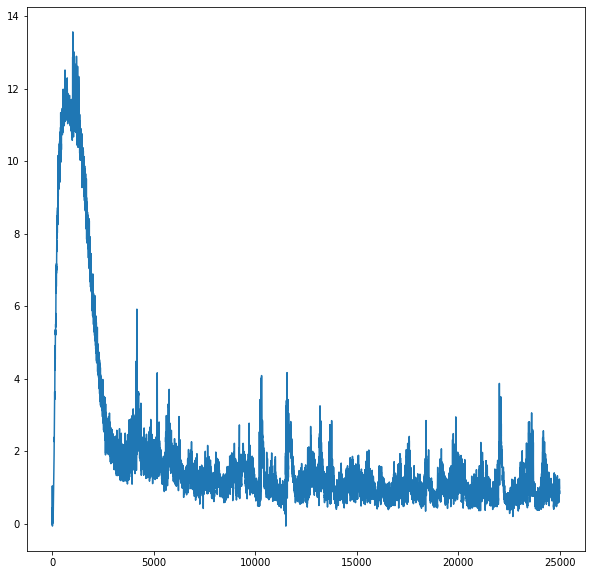

In [7]:
fig = plt.figure(figsize=(10, 10))
plt.plot(losses);

# Plot learned gradient field

In [8]:
import numpy as np

X = np.linspace(-4, 4, 30)
Y = np.linspace(-4, 4, 30)
n_sigma = sigmas.size(0)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device).expand(n_sigma, -1, -1)
grad_field = score_net(grid_tensor, sigmas)
grad_field_np = grad_field.detach().cpu().numpy()

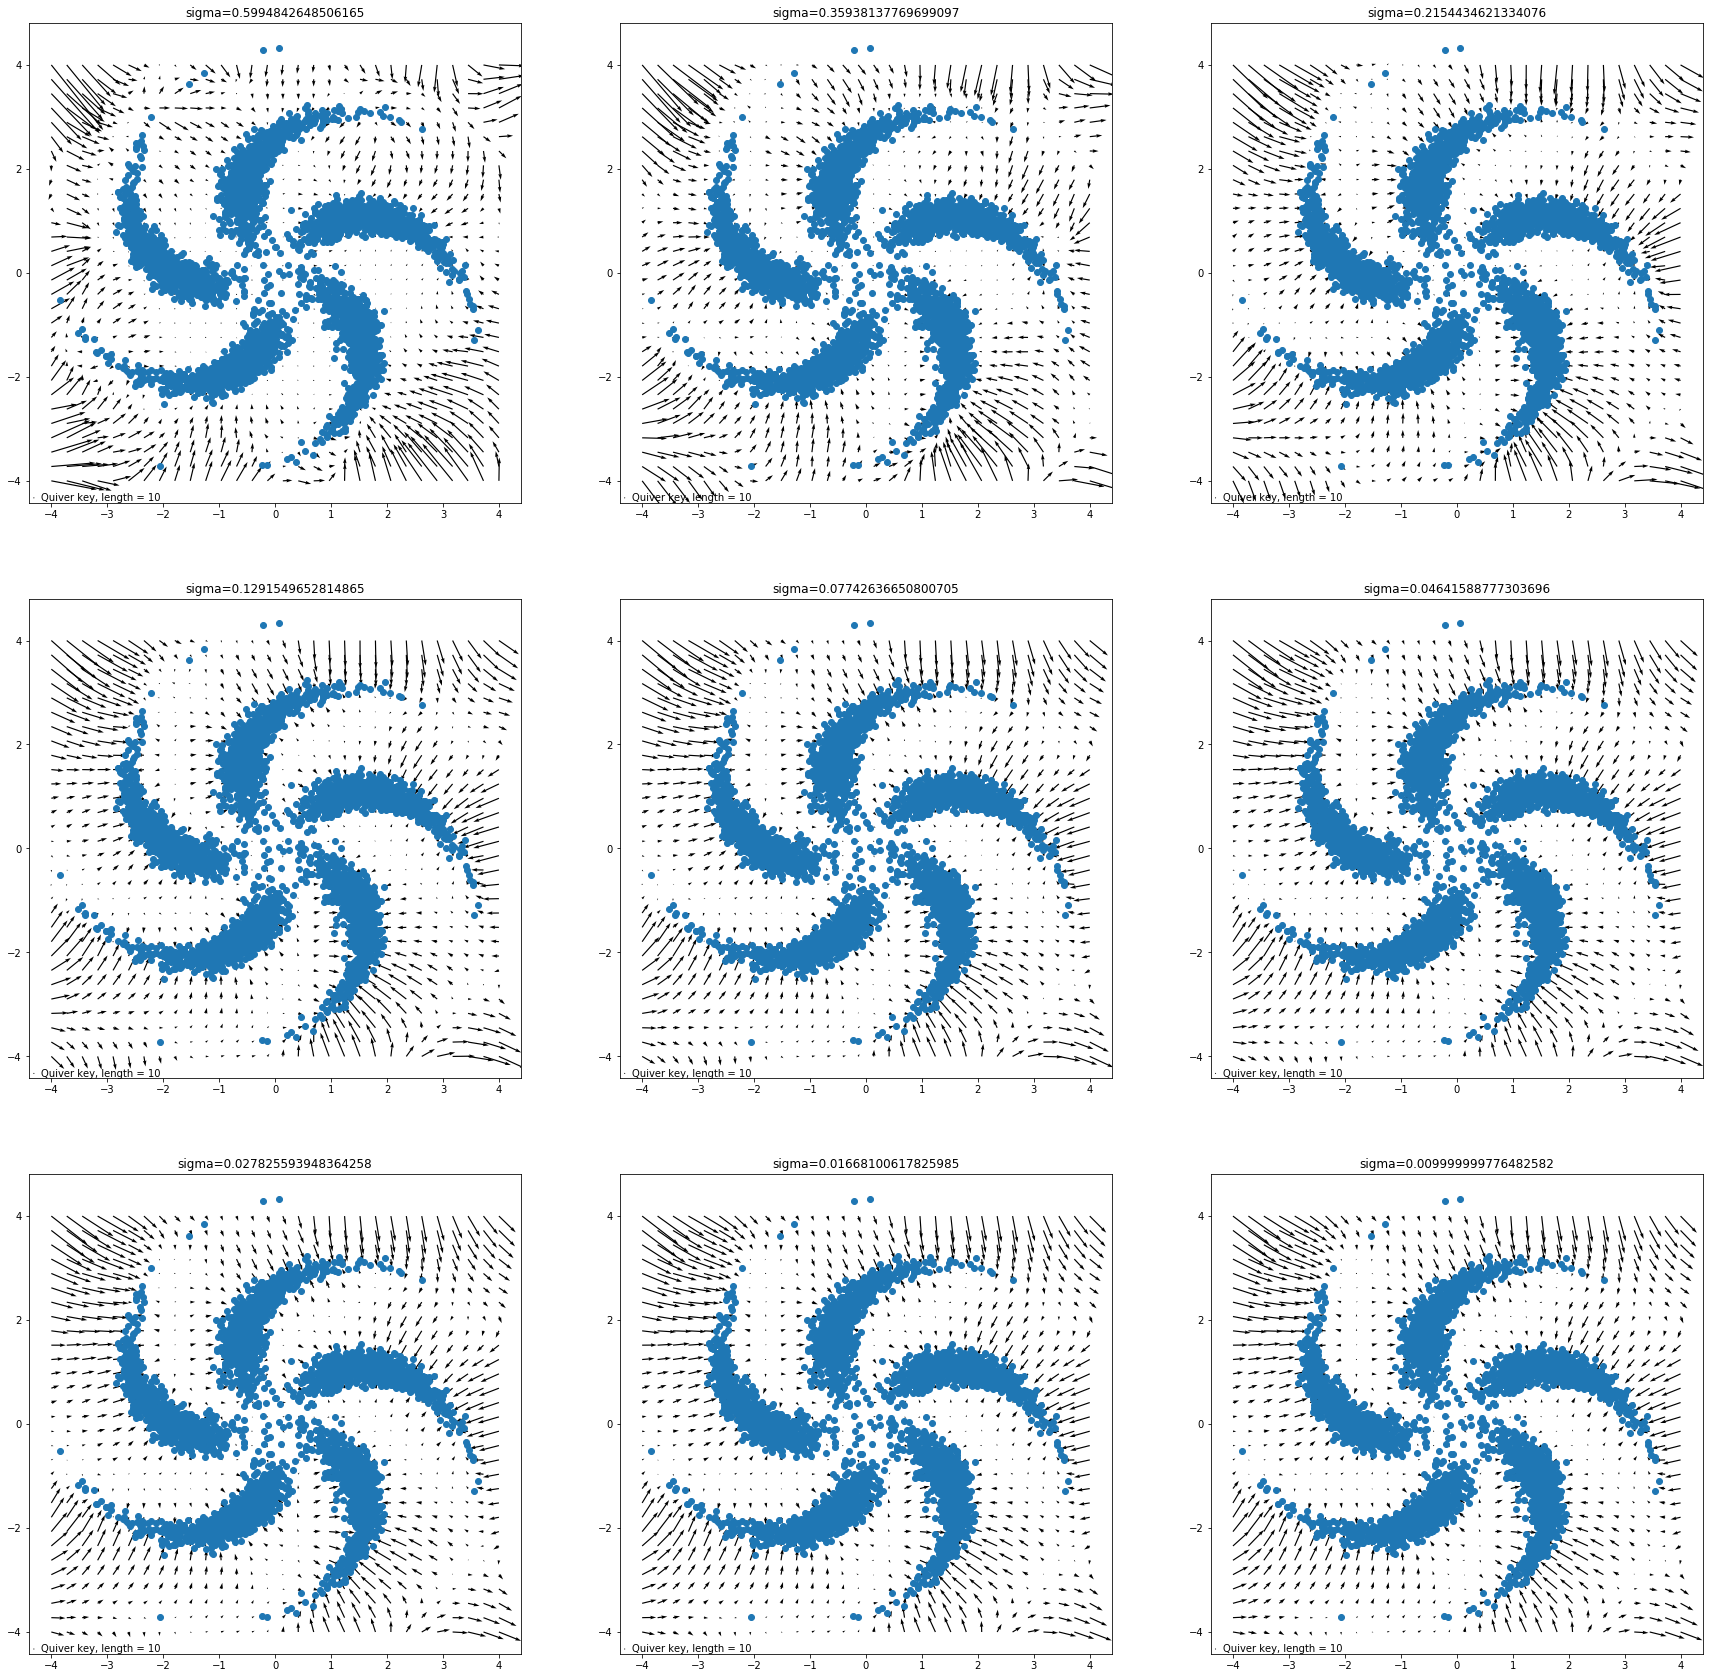

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
sample_data = toy_data.inf_train_gen('pinwheel', n_points=4096)
for i in range(n_sigma):
    q = ax[i // 3, i % 3].quiver(grid[..., 0], grid[..., 1], grad_field_np[i, :, 0], grad_field_np[i, :, 1])
    ax[i // 3, i % 3].quiverkey(q, X=0.01, Y=0.01, U=0.01, label='Quiver key, length = 10', labelpos='E')
    ax[i // 3, i % 3].scatter(sample_data[:, 0], sample_data[:, 1])
    ax[i // 3, i % 3].set_title("sigma={}".format(sigmas[i].item()))

# Visualize sampling

In [10]:
def get_prior(num_points, inp_dim):
    return (torch.rand(num_points, inp_dim) * 2. - 1.) * 4

def langevin_dynamics(model, sigmas, num_points=2048, dim=2, eps=1*1e-3, num_steps=10):
    with torch.no_grad():
        x_list = []
        model.eval()
        x = get_prior(num_points, dim).unsqueeze(0).cuda()
        x_list.append(x.clone())
        for sigma in sigmas:
            alpha = eps * ((sigma / sigmas[-1]))
            for t in range(num_steps):
                z_t = torch.randn_like(x)
                x += torch.sqrt(alpha) * z_t + (alpha / 2.) * model(x, sigma.view(1, -1))
                x_list.append(x.clone())
        return x, x_list
    
# def langevin_dynamics_lsd_test(f, l=1., e=.01, num_points=2048, n_steps=100, anneal=None):
#         x_k = get_prior(num_points, 2).cuda()
#         # sgld
#         if anneal == "lin":
#             lrs = list(reversed(np.linspace(e, l, n_steps)))
#         elif anneal == "log":
#             lrs = np.logspace(np.log10(l), np.log10(e))
#         else:
#             lrs = [l for _ in range(n_steps)]
#         x_k_list = [x_k.clone()]
#         for this_lr in lrs:
#             x_k += this_lr * f(x_k) + torch.randn_like(x_k) * e
#             x_k_list.append(x_k.clone())
#         final_samples = x_k.detach()
#         return final_samples, x_k_list

In [11]:
n_steps = 30
x_final, all_samples = langevin_dynamics(score_net, sigmas, eps=1e-3, num_steps=n_steps)
all_samples = [item.detach().cpu().squeeze().numpy() for item in all_samples]

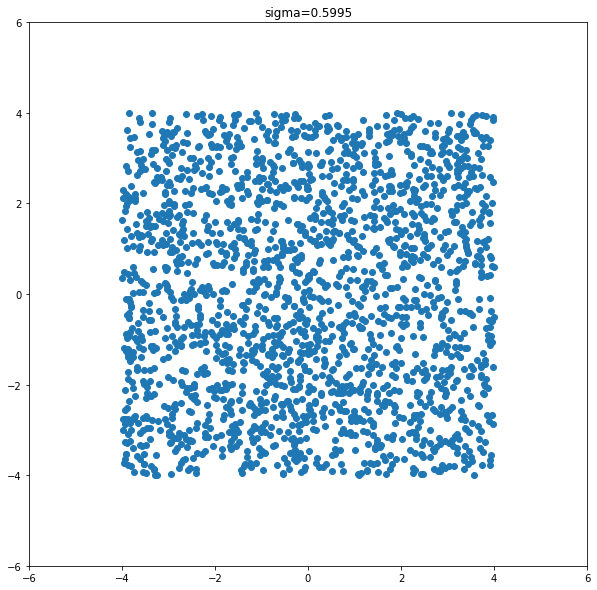

In [12]:
from matplotlib import animation, rc
rc('animation', html='html5')

def animate(i, data, scat):
    pts = data[i]
    scatter.set_offsets(pts)
    ax1.set_title("sigma={:.4f}".format(sigmas[i // n_steps].item()))
    return scatter,

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.set_title("sigma={:.4f}".format(sigmas[0].item()))
ax1.set_xlim(-6, 6)
ax1.set_ylim(-6, 6)
initial_pts = all_samples[0]
scatter = ax1.scatter(initial_pts[:, 0], initial_pts[:, 1])
anim = animation.FuncAnimation(fig, animate, frames=range(len(all_samples) - 1),
                                  fargs=(all_samples, scatter), interval=200)
anim